# Outages modeling of Generators for Adequacy Assesment
In this notebook we showcase some possible example of possible models for outages highlightening advantages and disadvantages of each. The dataset used can be found on https://transparency.entsoe.eu/.

# TODOS
- Change capacity modeling to Weibull distribution
- Confront Scenario results with ENSOEE data. Are there any abvious problems?
- Data Analysis on State Time an Capacity of the state are they correlated? ---> Not indipendent


In [2]:
#imports 

import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import expon
from scipy.optimize import curve_fit
from astropy.visualization import hist
#for fitting:
from scipy.stats import expon, rv_discrete
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#for plotting Markov Chain graph
import networkx as nx
import matplotlib.pyplot as plt


#helper functions

def import_df(path, cols = ['StartTS', 'EndTS', 'TimeZone', 'Status', 'Type', 'AreaCode',
       'AreaTypeCode', 'AreaName', 'MapCode', 'PowerResourceEIC', 'UnitName',
       'ProductionType', 'InstalledCapacity', 'AvailableCapacity',
       'Reason']):
    """
    imports and preprocess data_frame
    path: string containing path of csv file containing table
    cols: list of column names to select in df
    returns: non redundat dataframe with only failures
    """
    
    df = pd.read_csv(path, sep = "\t", parse_dates = [0,1])
    df = df[cols] #selects only column
    df = df.drop_duplicates(subset = ["UnitName","StartTS"]) #deletes redundant rows
    #df = df[(df["Reason"] == "Failure")] # WHERE | (df["Reason"] == 'Foreseen Maintenance')
    #maybe can do df[df["Reason"] in reasons]?
    return df

def get_week(date):
    """
    input: date in date_time format
    output: what week of the year the date corresponds to
    """
    return date.week


def truncate(number, digits) -> float:
    # Improve accuracy with floating point operations, to avoid truncate(16.4, 2) = 16.39 or truncate(-1.13, 2) = -1.12
    nbDecimals = len(str(number).split('.')[1]) 
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

def markov_graph(transitions, seed = 42, digits = 4, title = ""):
    """
    input: transitions, a dictionary having as 
    keys: touples with 2 elements being the from state and from state
    values: the transition probability
    output: markov chain graph
    """
    G = nx.MultiDiGraph()

    for transition, probability in transitions.items():
        state_from, state_to = transition
        if probability != 0: 
        #if probability state_from to state_to is not 0 we add an edge to the graph
            G.add_edge(state_from, state_to, weight=truncate(probability, digits))

    #create positions of nodes: dictionary with coordinates
    pos = nx.spring_layout(G, seed) 

    # Increase the scale to avoid overlap
    pos = {k: [v[0] * 2, v[1] * 2] for k, v in pos.items()}

    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black',
            connectionstyle='arc3,rad=0.1')

    # Annotate edges manually with adjusted positions to avoid overlap
    for edge, weight in labels.items():
        (x, y) = pos[edge[0]]
        text_x = 3/4*x + 1/4*pos[edge[1]][0]
        text_y = 3/4*y + 1/4*pos[edge[1]][1]
        #shift text to avoid overlap
        text_y += 0.2 if edge[0] == edge[1] else 0


        plt.text(text_x, text_y, f"{weight}", fontsize=8, color='blue', verticalalignment='center',
                 horizontalalignment='center')
    plt.title(title)
    plt.show()
    
    
def combine_overlaps(df):
    """
    this functions combines any time overlaps present in the dataframe for each generator
    so that for every time t there is at most one row describing the generator at time t.
    df: dataframe containing UnitName, StartTS, EndTS
    """

    # Step 1: Sort the DataFrame
    df.sort_values(by=["UnitName", "StartTS"], inplace=True)

    # Step 2 and 3: Combine overlapping intervals
    result = []
    current_interval = None
    n_rows = df.shape[0]
    perc = n_rows // 100

    for k, row in df.iterrows():
        if k % perc == 0:
            print(f"percentage of rows parsed = {k / n_rows *100:.2f}%")
        if current_interval is None:
             current_interval = row.copy()
        elif row["StartTS"] >= current_interval["EndTS"] or row["UnitName"] != current_interval["UnitName"]:
            # No overlap or new UnitID
            result.append(current_interval)
            current_interval = row.copy()
        else:
            # Overlapping intervals, update the EndTS
            current_interval["EndTS"] = row["StartTS"]

    result_df = pd.DataFrame(result)

    return result_df


def get_markov_probs(df, states_column):
    """
    input:
    df: dataframe having as columns: states_column, "ProductionType", "StartTS", "UpTime"
    states_column: string with name of column where the state of the generator is saved
    output: dictionary having as keys tuples with two states and the associated probability transition
    """
    states = list(df[states_column].unique())
    states.append("Running")
    transitions = []
    for x in states:
        for y in states:
            transitions.append((x,y))
            
    transitions_counter = dict(zip(transitions, [0]*len(transitions)))
    GenGroups = df.groupby("UnitName")
    previous_state = "Running"
    current_state = "Running"
    for unit_name, unit_df in GenGroups:
        unit_df = unit_df.sort_values(["StartTS"])
        #count transition occurante for unit
        for index, row in unit_df.iterrows():
            uptime = row["RunningTime"]
            #get current state from row
            current_state = row[states_column]

            if pd.isna(uptime):
                #if uptime == "Nan" then it was the first recorded instance of the generator in the dataframe so before it was running.
                previous_state = "Running"
            elif uptime > 10 / (60 * 24): # and previous_state != "Running"
                #if the generator had some time between the previous row than the previous state was running
                #and we must add 1 to previousprevious state and running
                transitions_counter[(previous_state, "Running")] += 1
                previous_state = "Running"    

            transitions_counter[(previous_state, current_state)] += 1
            #the current state becomes the previous_state
            previous_state = current_state

    #get the transtions probabilities
    transitions_probs = transitions_counter
    counter_dict = dict(zip(states, [0]*len(states)))
    for state in states:
        for transition, counter in transitions_probs.items():
            if transition[0] == state:
                counter_dict[state] += counter 

    for transition, counter in transitions_probs.items():
        if counter_dict[transition[0]] != 0:
            #if transition[0] occurs at least one time
            transitions_probs[transition] = transitions_probs[transition] / counter_dict[transition[0]]
    return transitions_probs

def weighted_values(values, probabilities, size):
    bins = np.add.accumulate(probabilities)
    return values[np.digitize(np.random.random_sample(size), bins)]

def next_state_markov(markov, current_state):
    possible_states = []
    transition_probs = []
    for key, prob in markov.items():
        if key[0] == current_state and prob != 0:
            possible_states.append(key[1])
            transition_probs.append(prob)
    return weighted_values(np.array(possible_states), np.array(transition_probs),1)[0]


# Import Data Frame

In [3]:
#Dataframe example
#repository = "UnavailabilityOfGenerationUnits"
path = r'U:\ENTSO-E Transparency Platform\UnavailabilityOfGenerationUnits_15.1.A_B'

# Enclose the path in double quotes
repository = f'{path}'

#print(os.listdir(repository))

file_name = os.listdir(repository)[0]
complete_path = os.path.join(repository,file_name)

df = pd.read_csv(complete_path, sep = "\t", parse_dates = [0,1])

#Dataframe snippet
#df.head(15)

FileNotFoundError: [Errno 2] No such file or directory: 'U:\\ENTSO-E Transparency Platform\\UnavailabilityOfGenerationUnits_15.1.A_B'

In [4]:
#create full table: check whether it work, it takes a while
"""
df = pd.DataFrame()
k = 0
for file_name in os.listdir(repository):
    #print(file_name)
    complete_path = os.path.join(repository,file_name)
    new_df = pd.read_csv(complete_path, sep = "\t", parse_dates = [0,1])
    new_df = new_df.drop_duplicates(subset = ["UnitName","StartTS"])
    #new_df = combine_overlaps(new_df)
    if k % 20 == 0:
        print(k)
    k += 1
    df = pd.concat([df,new_df])
"""

'\ndf = pd.DataFrame()\nk = 0\nfor file_name in os.listdir(repository):\n    #print(file_name)\n    complete_path = os.path.join(repository,file_name)\n    new_df = pd.read_csv(complete_path, sep = "\t", parse_dates = [0,1])\n    new_df = new_df.drop_duplicates(subset = ["UnitName","StartTS"])\n    #new_df = combine_overlaps(new_df)\n    if k % 20 == 0:\n        print(k)\n    k += 1\n    df = pd.concat([df,new_df])\n'

In [12]:
#otherwise import the following full dataset
data_path = "../outagesmodelingdata/"
df = pd.read_csv(data_path+"deltaWithEverything_df.csv", parse_dates = [0,1])
df["StartTS"] = pd.to_datetime(df["StartTS"])
df["EndTS"] = pd.to_datetime(df["EndTS"])
df = df.sort_values(["UnitName","StartTS"])


In [13]:
from pathlib import Path
path = Path(data_path + "deltaWithEverything_df.csv")
print(path.parent.absolute())
print(data_path)

/home/frulcino/JRC/OoutagesModeling4AdequacyAssesment/../outagesmodelingdata
../outagesmodelingdata/


In [7]:
#Combine overlaps fo that every generator is only at one state at the time
df = combine_overlaps(df)


percentage of rows parsed = 0.00%
percentage of rows parsed = 1.00%
percentage of rows parsed = 2.00%
percentage of rows parsed = 3.00%
percentage of rows parsed = 4.00%
percentage of rows parsed = 5.00%
percentage of rows parsed = 6.00%
percentage of rows parsed = 7.00%
percentage of rows parsed = 8.00%
percentage of rows parsed = 9.00%
percentage of rows parsed = 10.00%
percentage of rows parsed = 11.00%
percentage of rows parsed = 12.00%
percentage of rows parsed = 13.00%
percentage of rows parsed = 14.00%
percentage of rows parsed = 15.00%
percentage of rows parsed = 16.00%
percentage of rows parsed = 17.00%
percentage of rows parsed = 18.00%
percentage of rows parsed = 19.00%
percentage of rows parsed = 20.00%
percentage of rows parsed = 21.00%
percentage of rows parsed = 22.00%
percentage of rows parsed = 23.00%
percentage of rows parsed = 24.00%
percentage of rows parsed = 25.00%
percentage of rows parsed = 26.00%
percentage of rows parsed = 27.00%
percentage of rows parsed = 28

In [8]:
#combine countries
df["MapCode"] = df["MapCode"].apply(lambda x: x[0:2])

## Occurances by generator during the year.
In this sections we consider for every week of the year how many outages happen in average during that week.
We observe that no clear dependence arises between part of the year and number of outages.

In [9]:
#import all dataframes and for each week count number of occurances
count_df = df.groupby(["ProductionType","MapCode","Reason",pd.Grouper(key = "StartTS", freq = "M")]).count()
count_df = count_df.rename(columns = {"Status": "Count"})
count_df = count_df.reset_index() #ungroups
count_df["Week"] = count_df["StartTS"].apply(get_week) #get week number
count_df = count_df[count_df["StartTS"] < datetime.datetime(2022, 1, 1, 1, 00,00)] #remove predictions


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


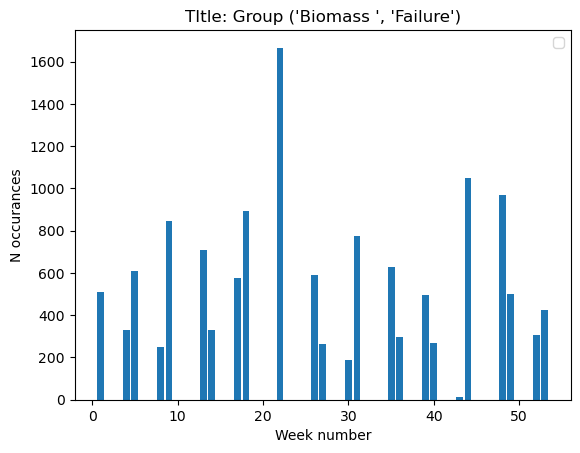

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


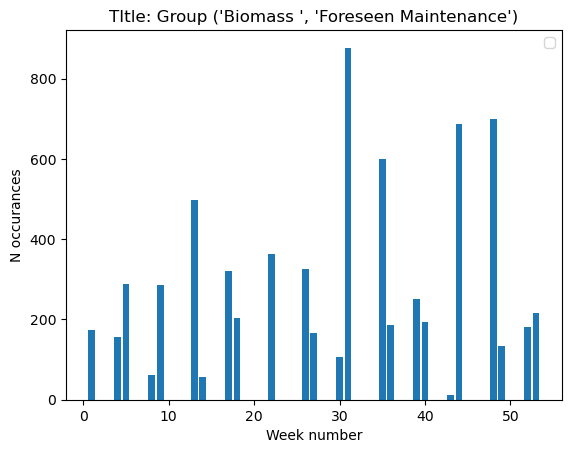

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


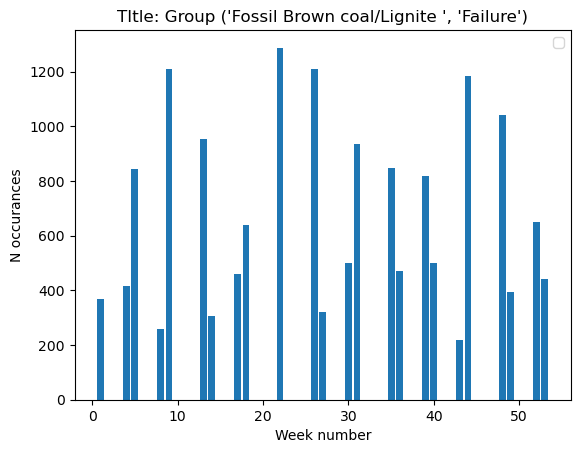

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


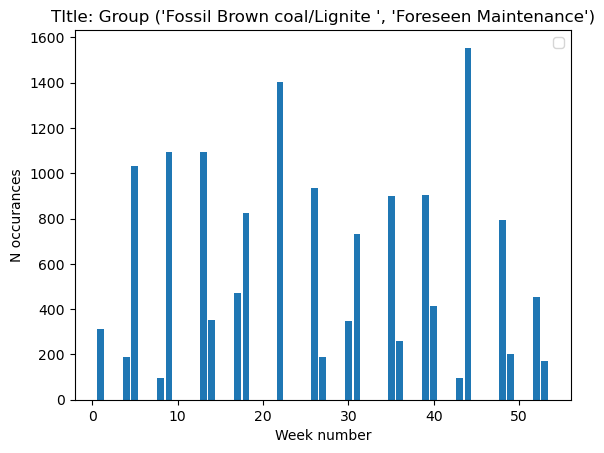

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


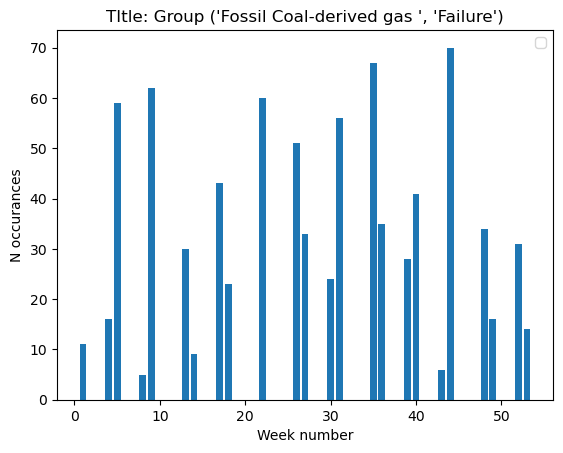

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


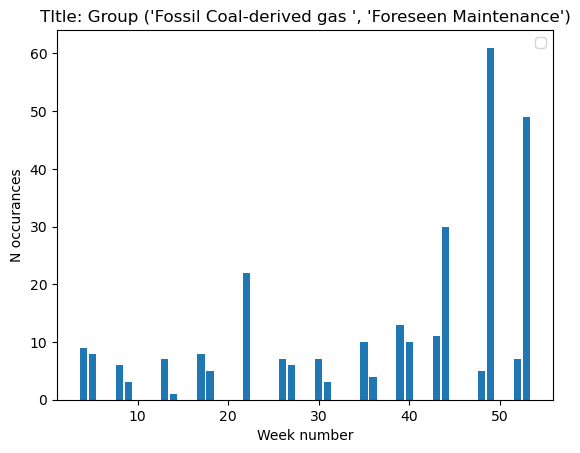

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


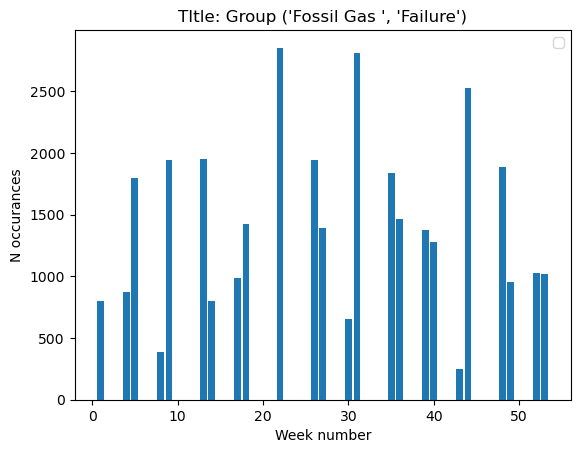

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


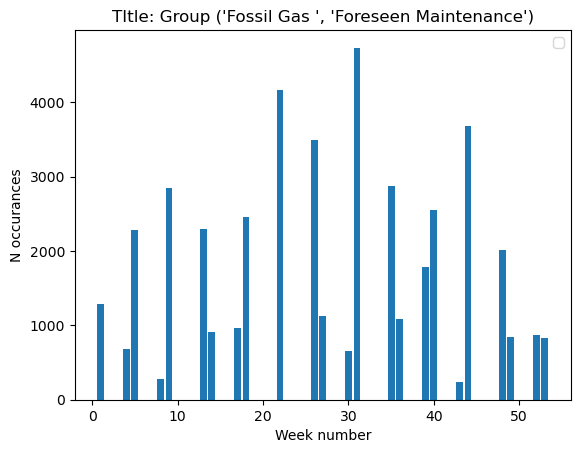

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


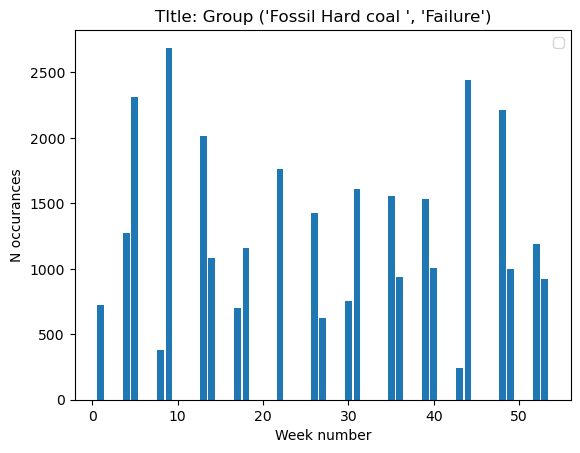

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


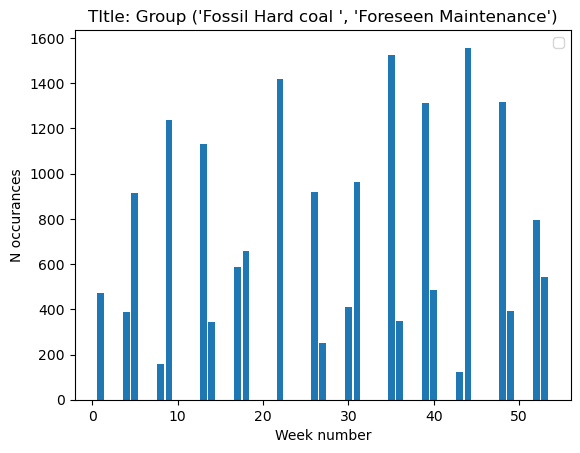

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


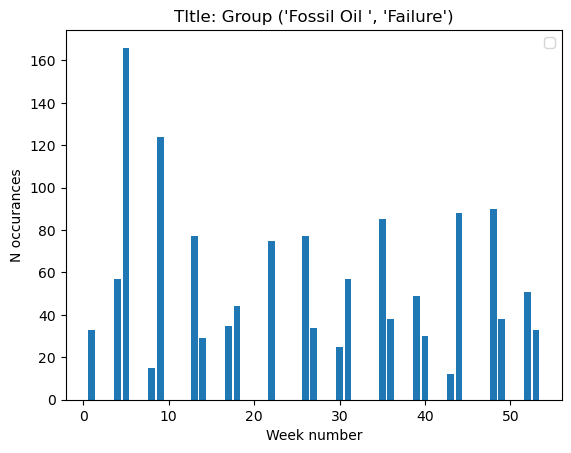

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


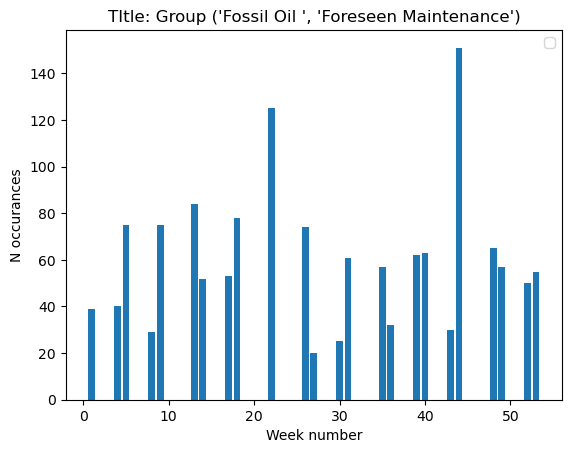

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


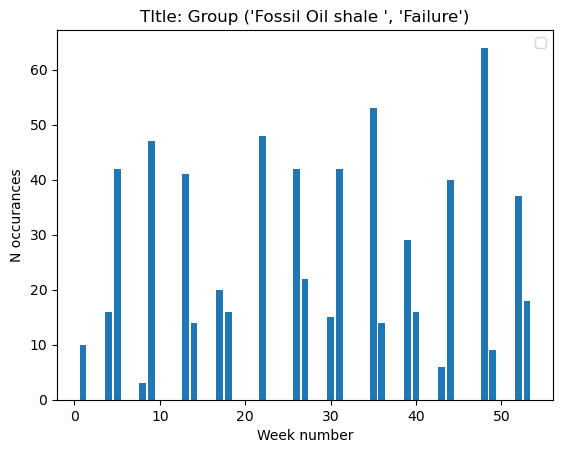

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


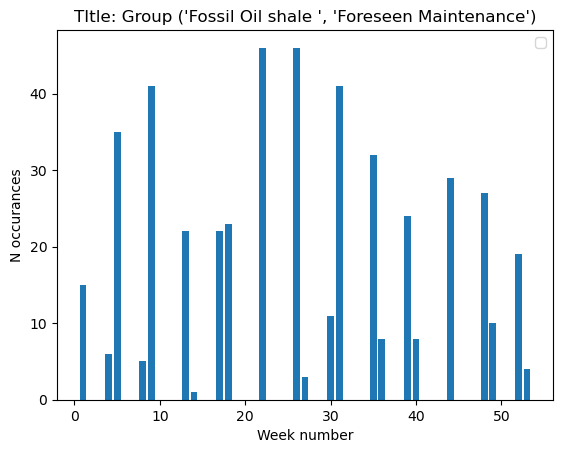

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


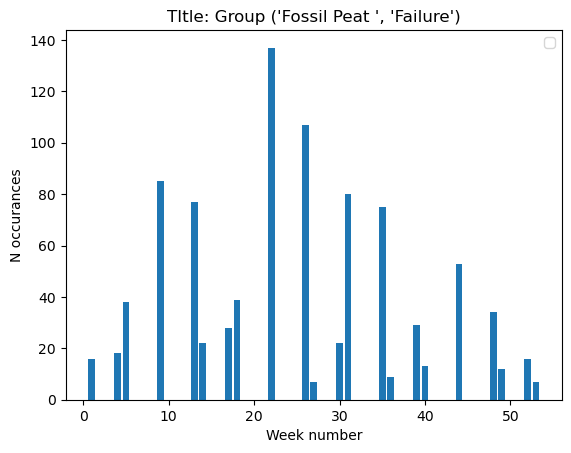

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


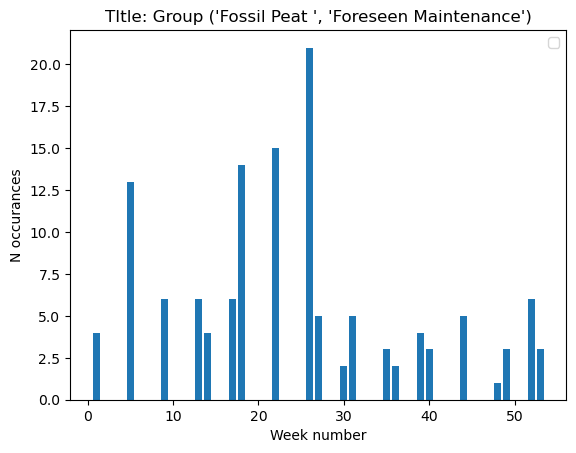

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


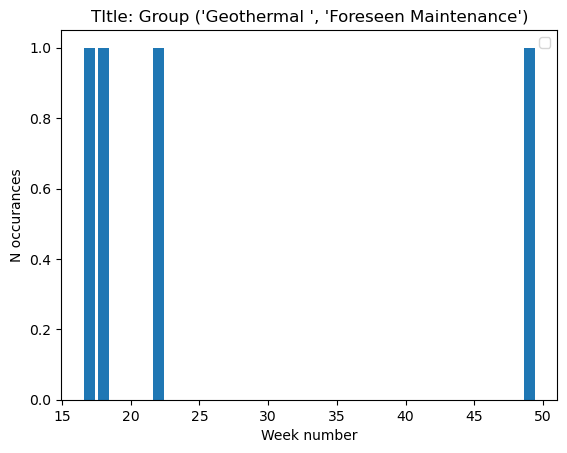

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


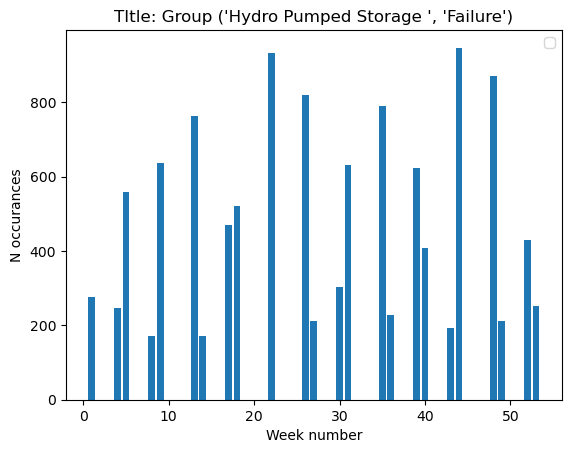

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


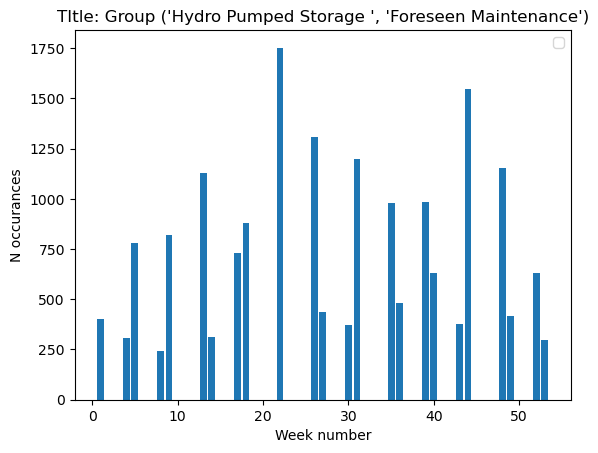

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


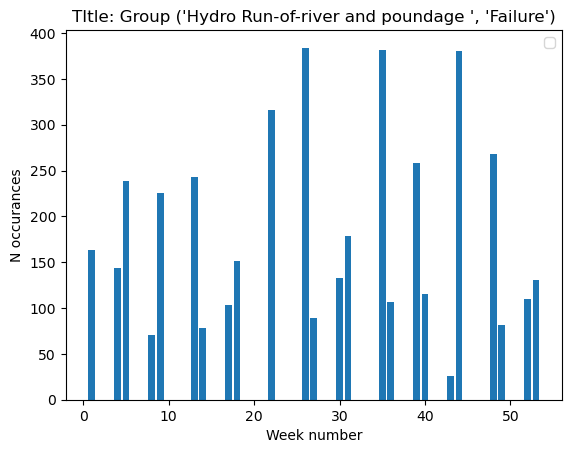

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


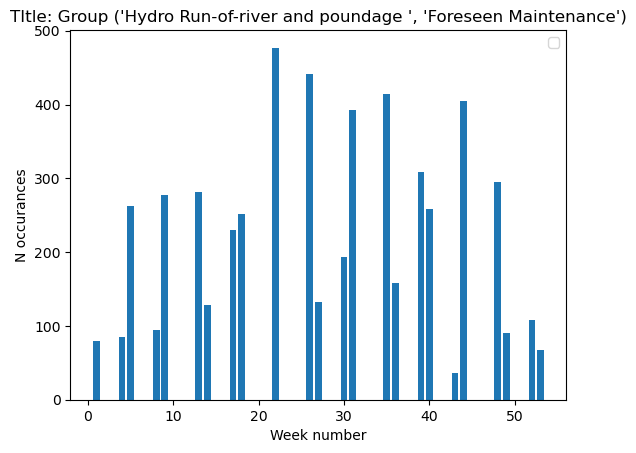

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


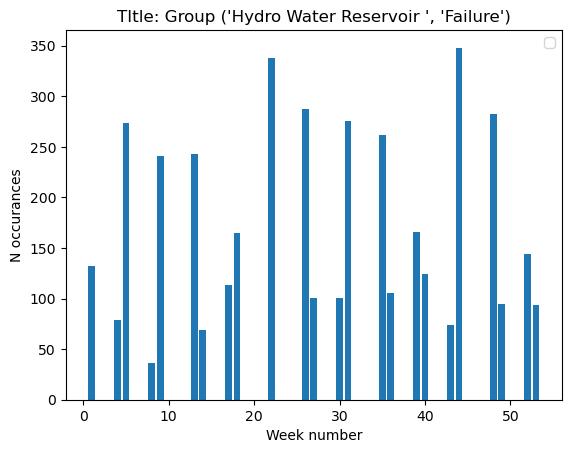

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


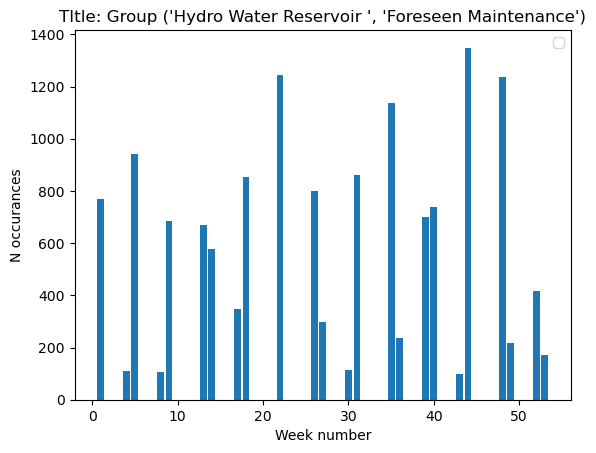

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


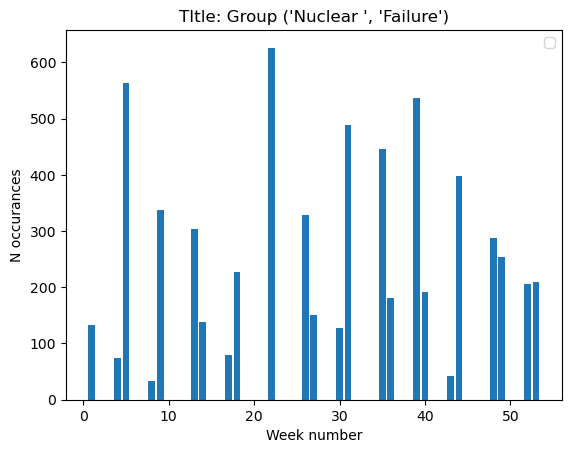

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


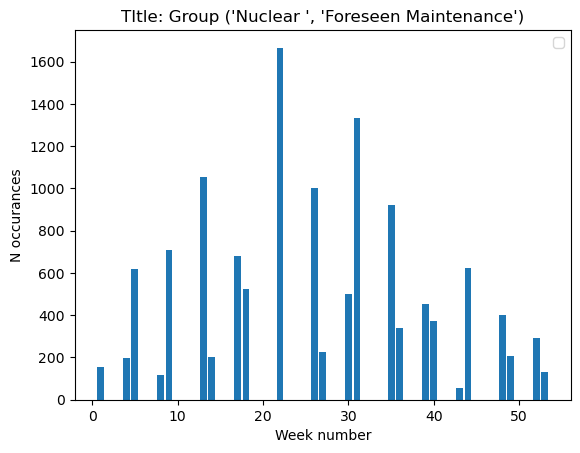

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


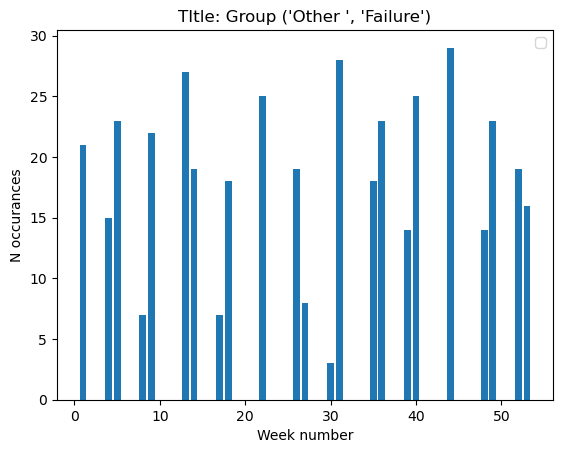

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


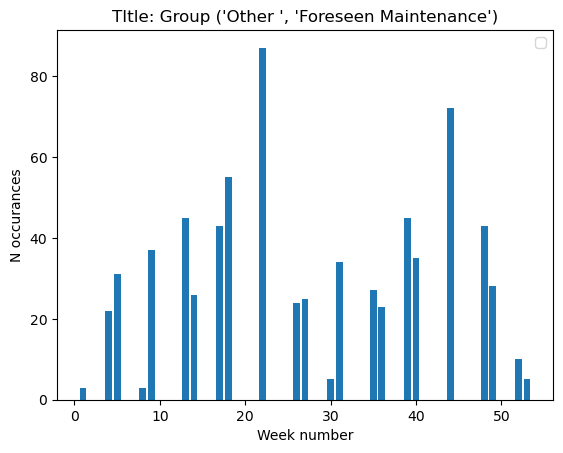

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


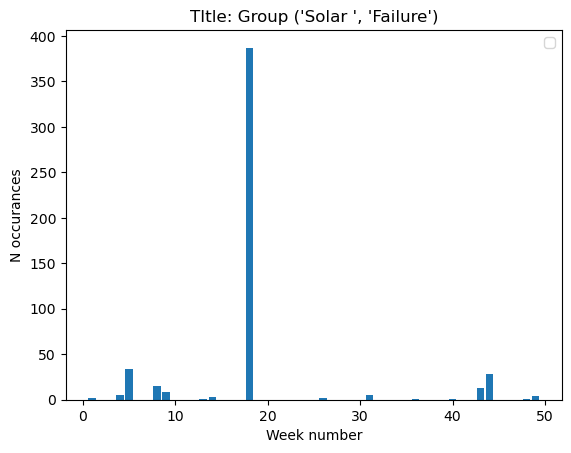

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


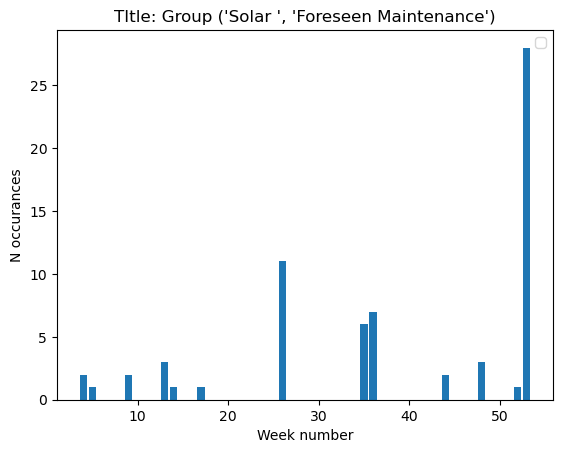

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


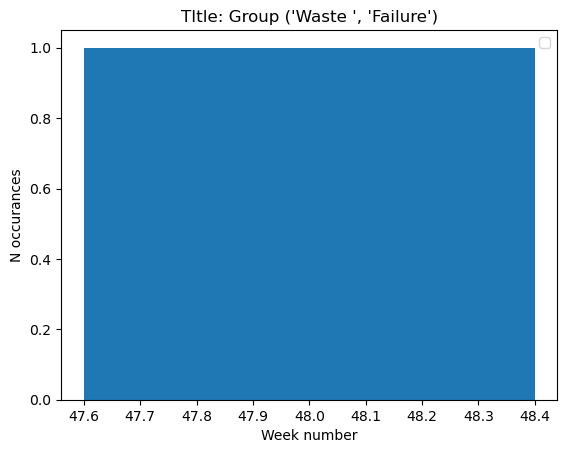

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


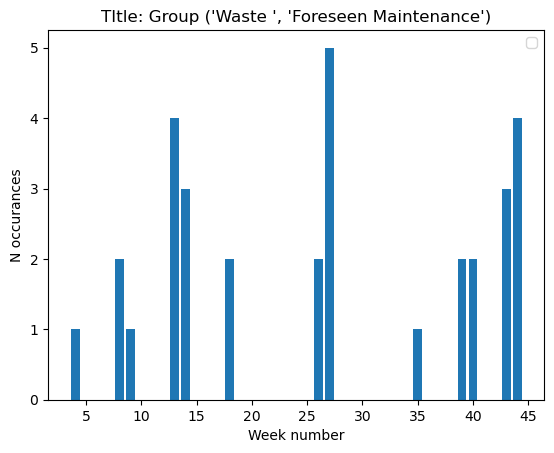

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


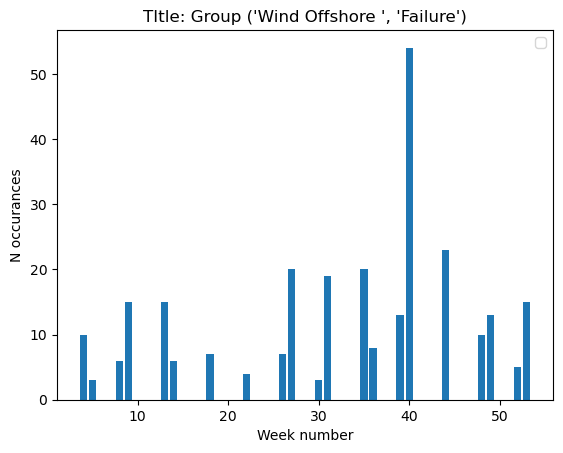

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


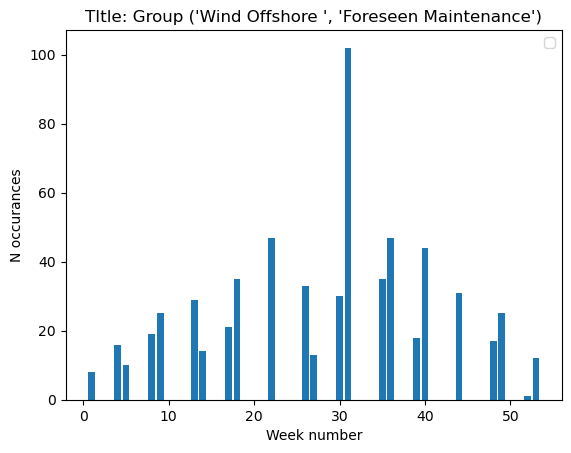

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


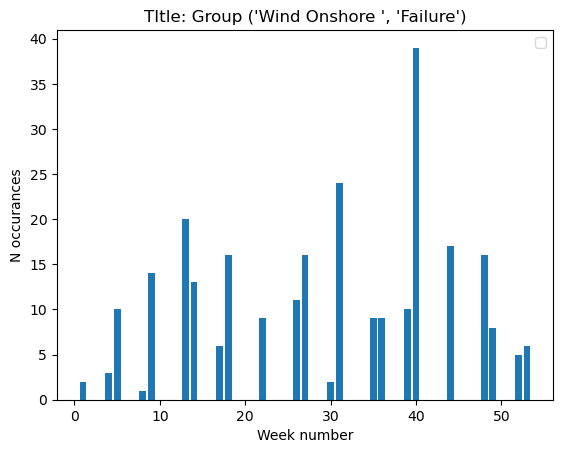

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


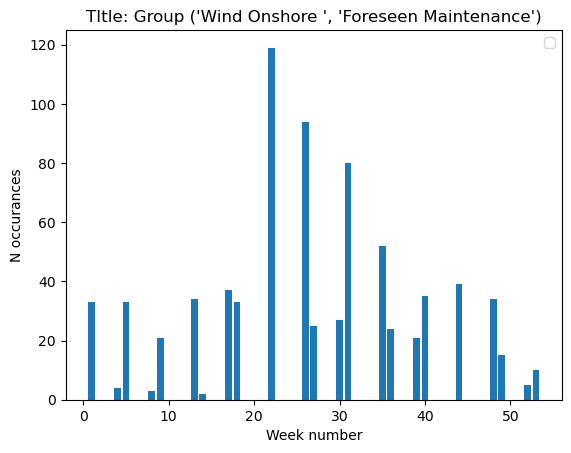

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


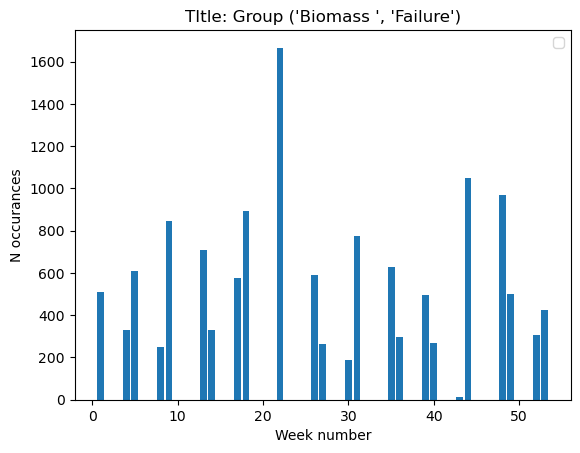

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


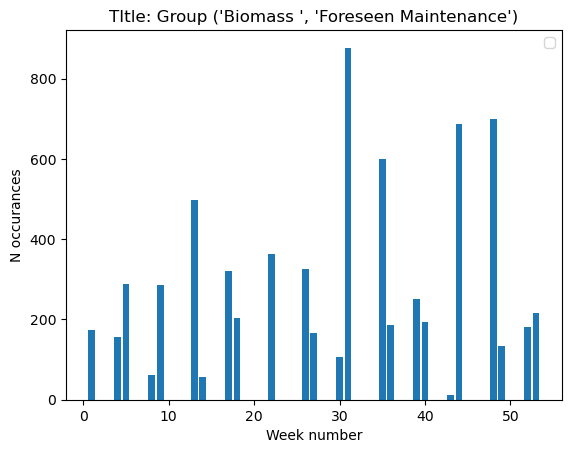

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


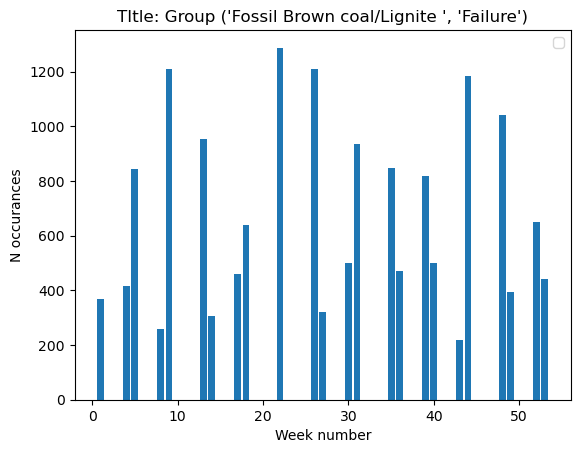

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


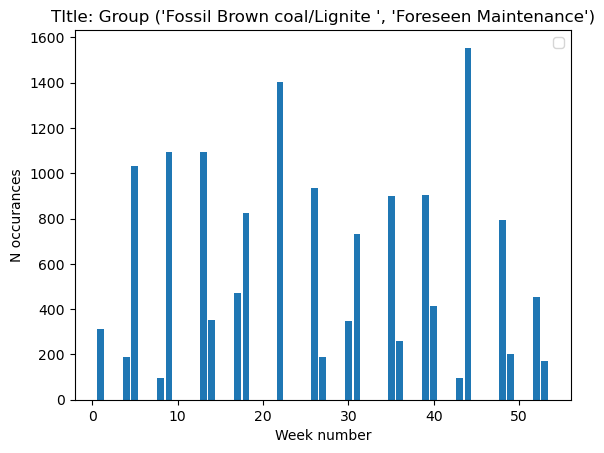

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


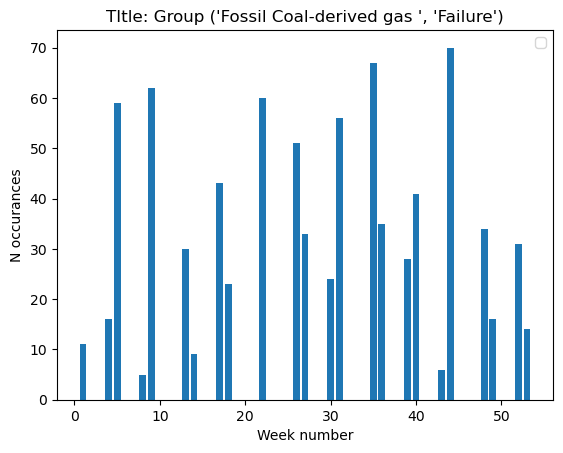

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


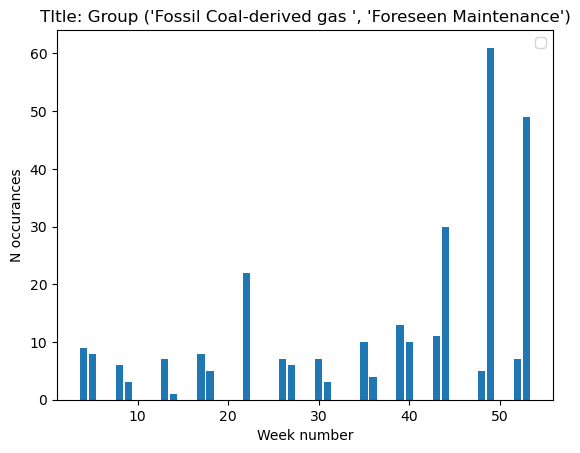

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


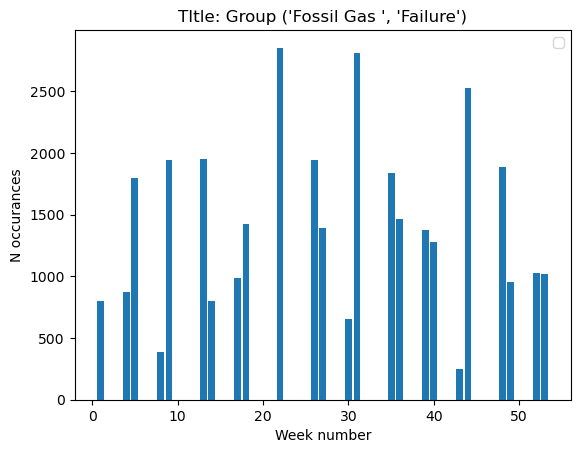

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


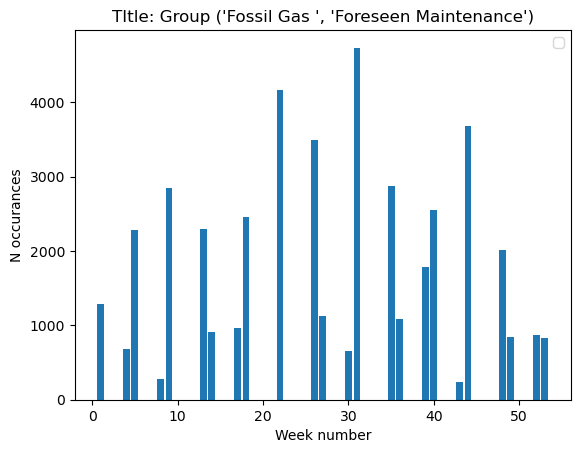

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


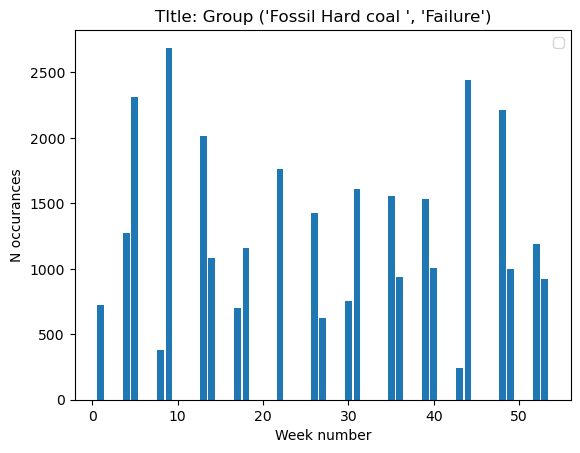

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


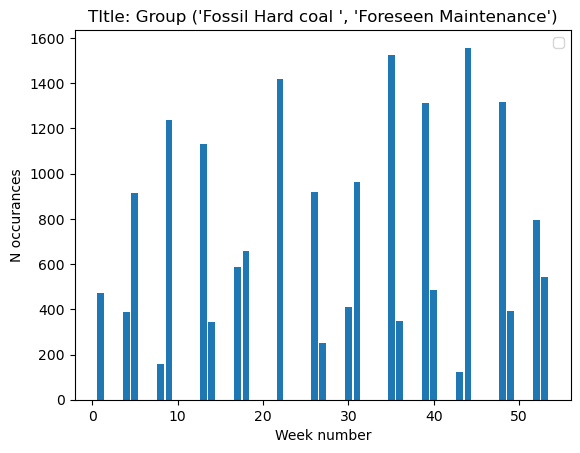

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


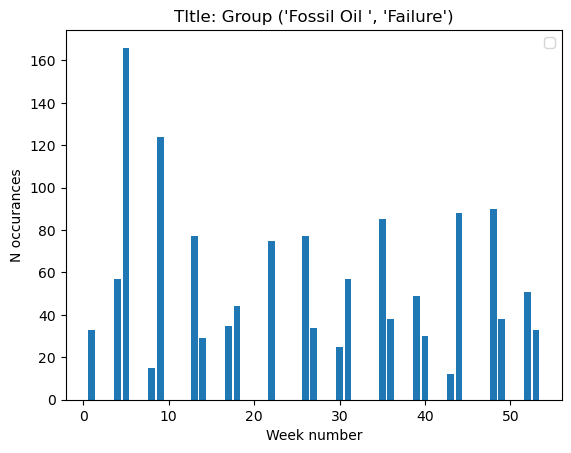

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


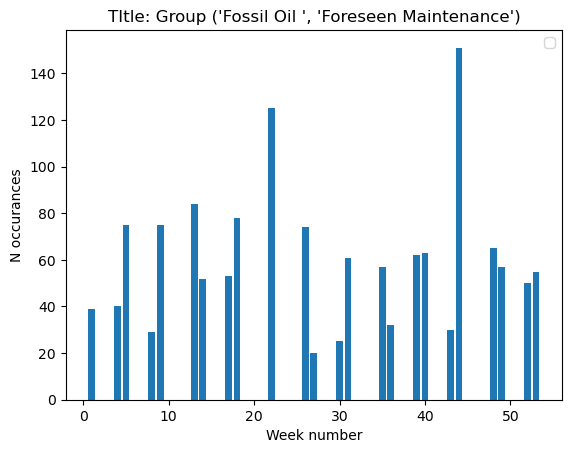

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


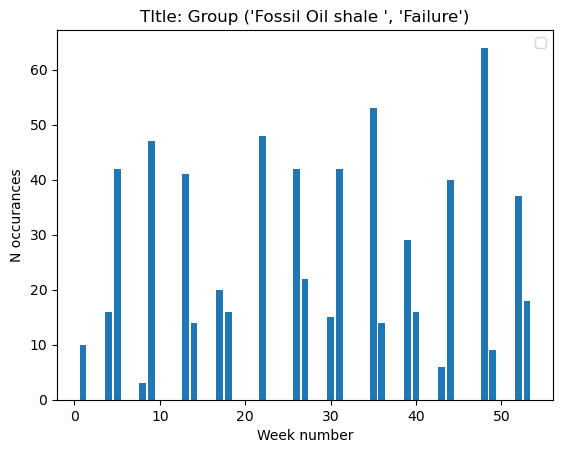

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


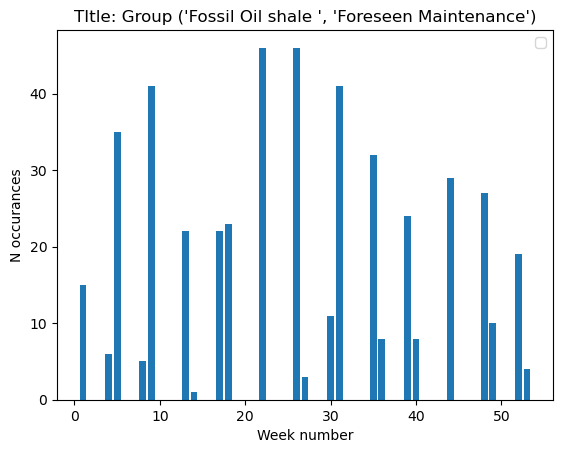

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


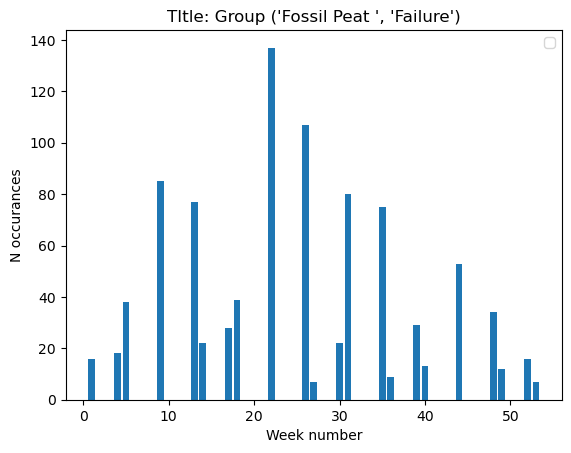

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


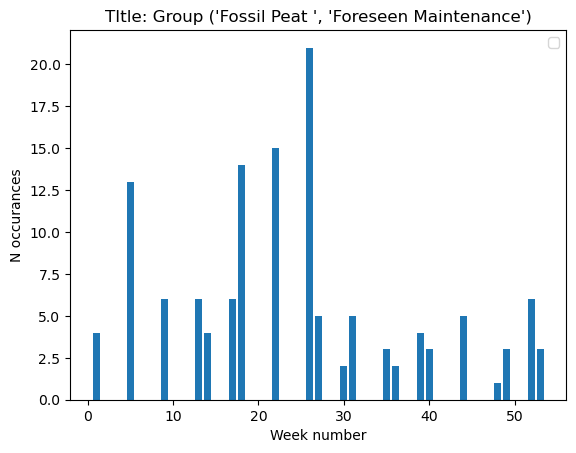

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


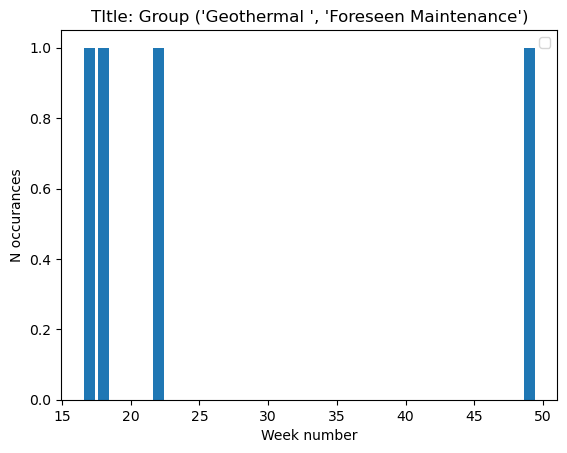

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


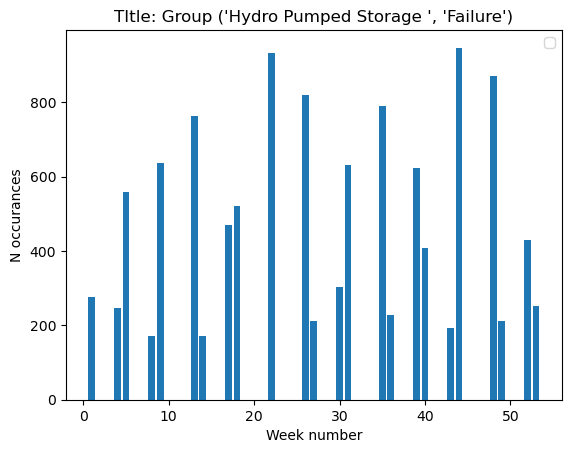

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


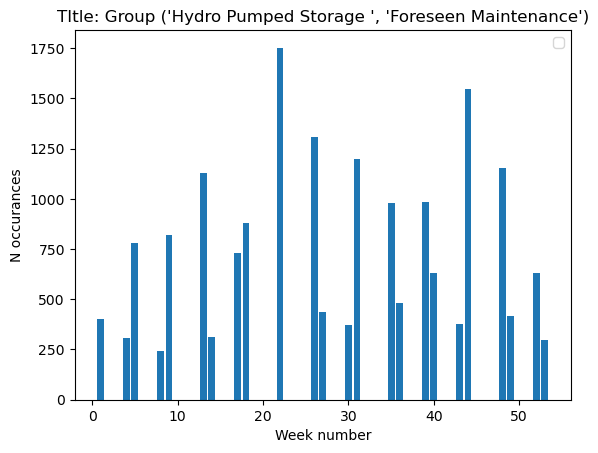

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


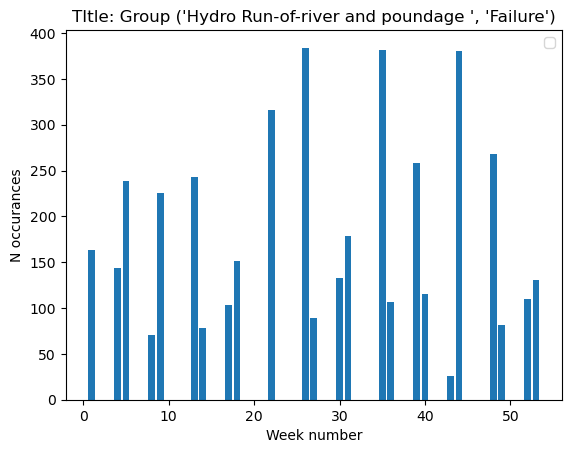

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


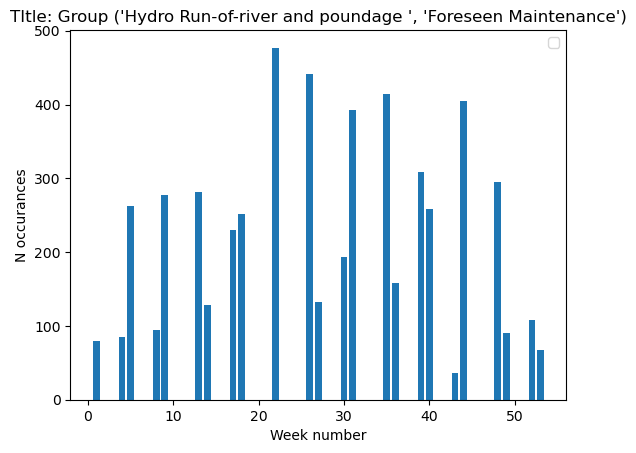

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


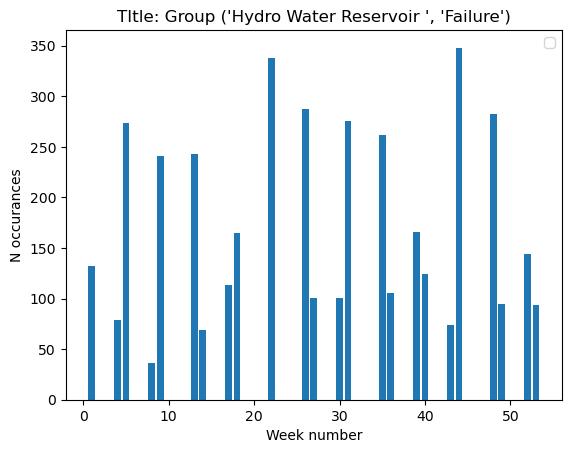

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


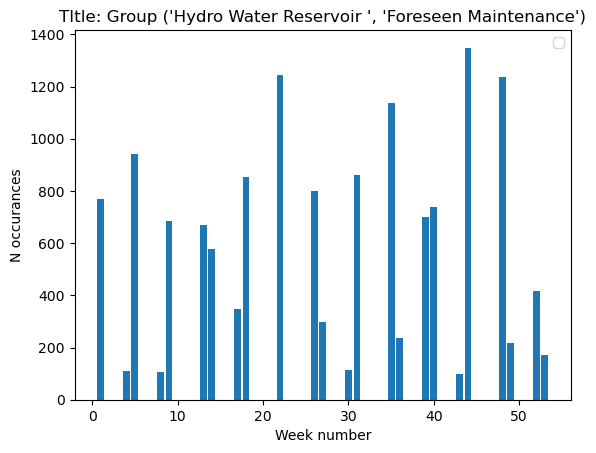

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


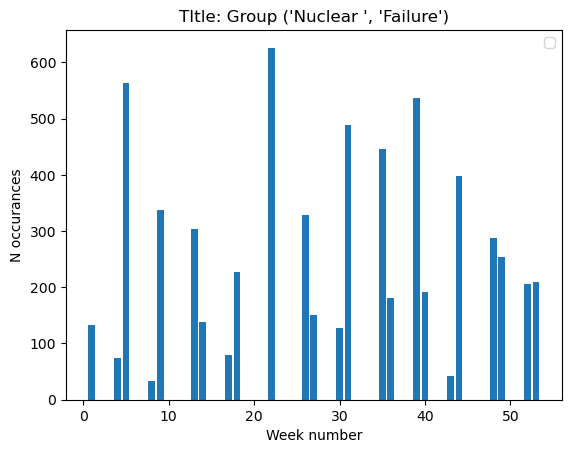

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


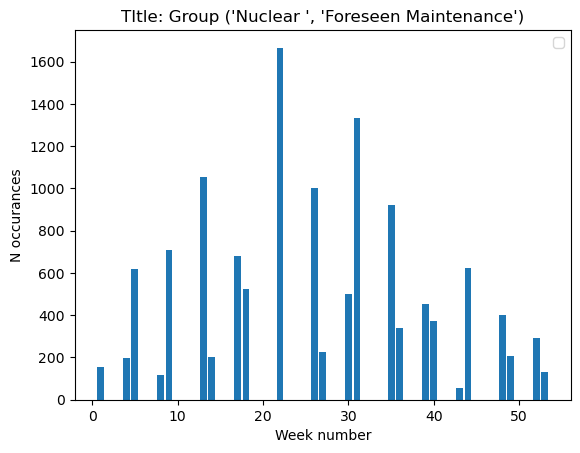

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


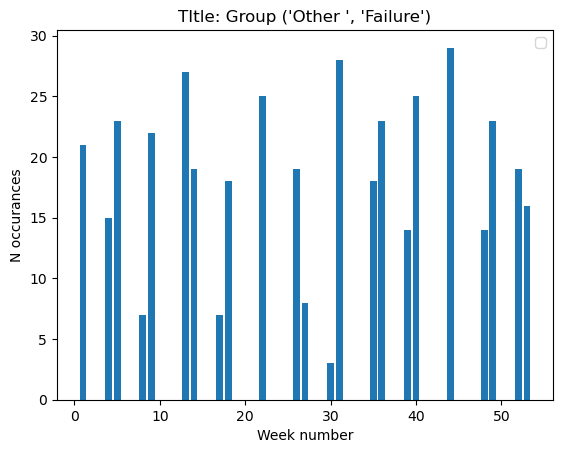

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


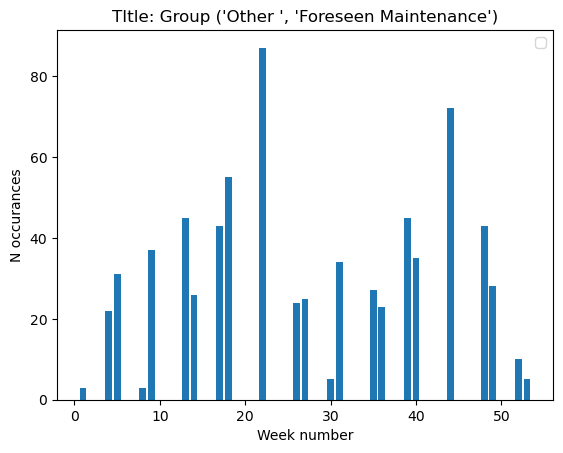

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


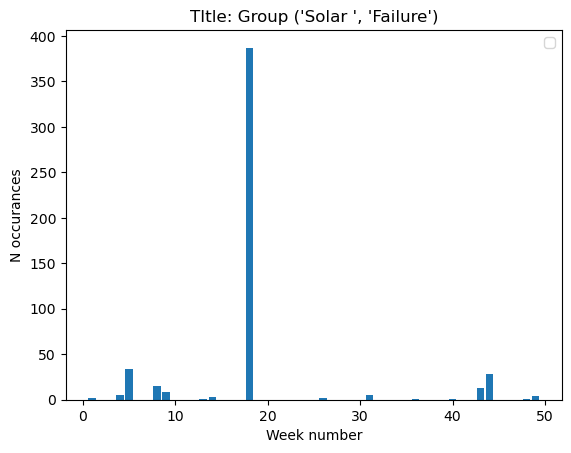

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


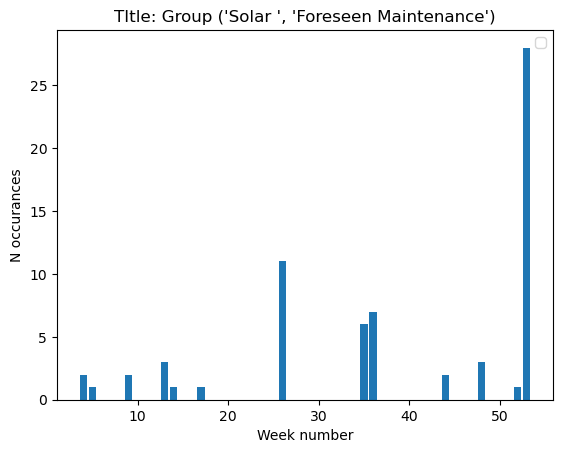

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


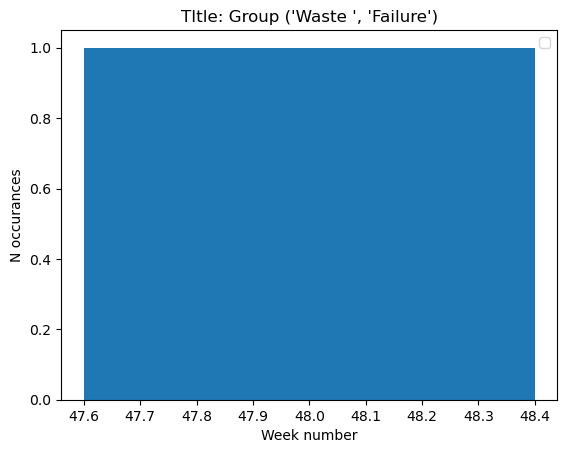

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


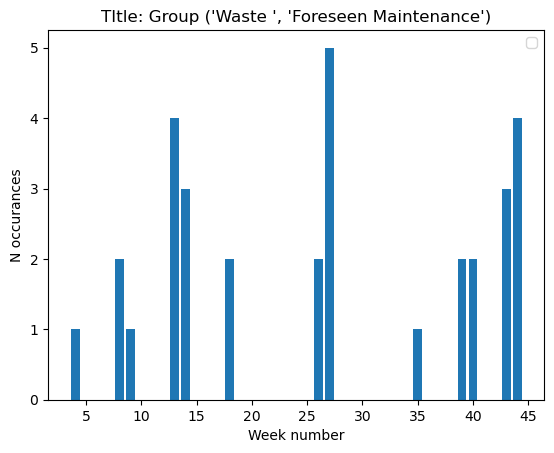

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


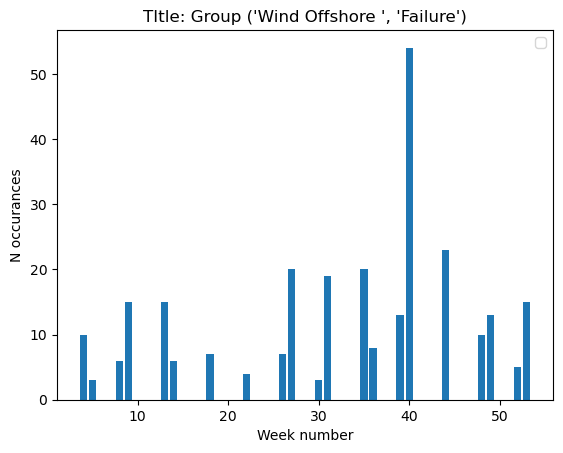

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


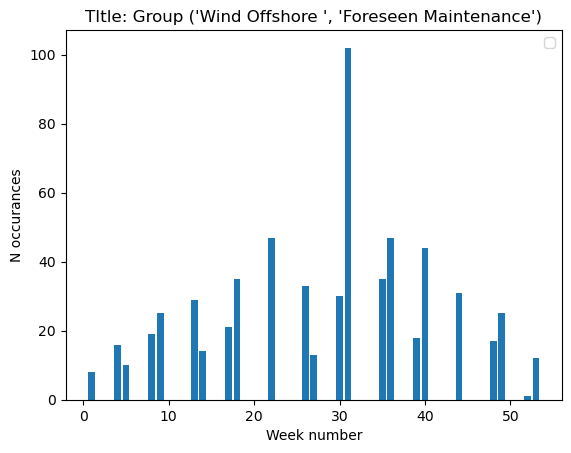

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


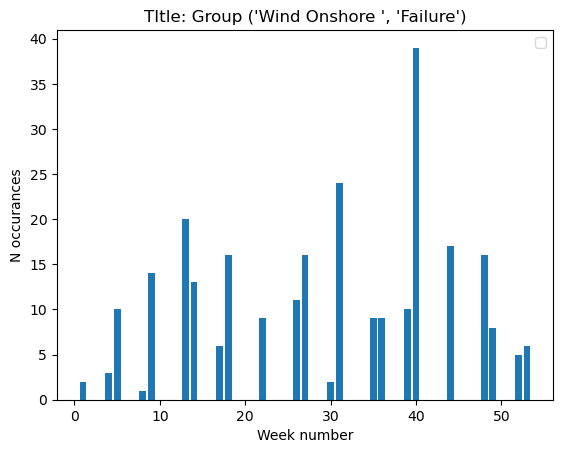

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


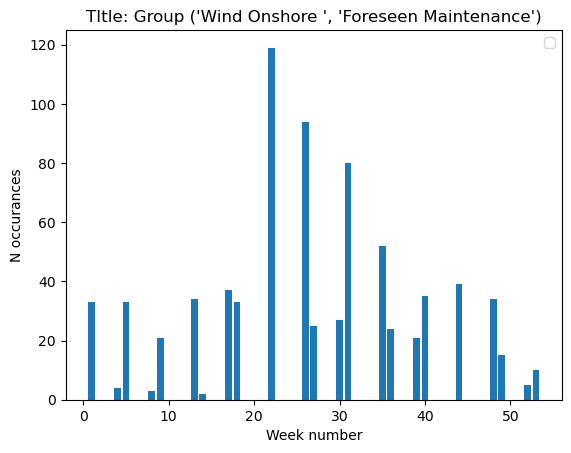

In [10]:

#calculate average occurances
n_years = 8
distributions = count_df.groupby(["ProductionType","Reason","Week"])["Count"].sum() #count contingencees for every week
#distributions["Count"] = distributions["Count"]/n_years
distributions = distributions.reset_index()
grouped_distributions = distributions.groupby(["ProductionType","Reason"])

#plot for every type of generator 
for (group_name, group_df) in grouped_distributions:
    if group_name[1] in ["Failure","Foreseen Maintenance"]: #plot only failures and Foressen Maintenances
        plt.figure()
        plt.bar(group_df["Week"],group_df["Count"])
        plt.xlabel('Week number')
        plt.ylabel('N occurances')
        plt.title( f'TItle: Group {group_name}')
        plt.legend()
        plt.show()
        
#plot for every type of generator 
for (group_name, group_df) in grouped_distributions:
    if group_name[1] in ["Failure","Foreseen Maintenance"]: #plot only failures and Foressen Maintenances
        plt.figure()
        plt.bar(group_df["Week"],group_df["Count"])
        plt.xlabel('Week number')
        plt.ylabel('N occurances')
        plt.title( f'TItle: Group {group_name}')
        plt.legend()
        plt.show()

**Why are there some weeks without failures???**

In [11]:
#weeks with failures:
weeks_with_failures = distributions[(distributions["Reason"]=="Failure")]["Week"].unique()
print(weeks_with_failures)

[ 1  4  5  8  9 13 14 17 18 22 26 27 30 31 35 36 39 40 43 44 48 49 52 53]


## State time modeling
In this section we model the time a generator spends in a certain state.
We model the random variable time in each state with a exponential distribution using the maximum likelyhood estimator (MLE).


In [12]:
#Change state_column to look ad different state distributions
state_column = "Type"

#def state_time_distribution_fitting(df, state_column):

states = list(df[state_column].unique())
delta_df = df
delta_df = delta_df.sort_values(by = ["UnitName", "StartTS"])

for state in states:
    #calculate time spend in each state
    delta_df[state+"Time"] = [np.datetime64("NaT")]*df.shape[0]
    state_df = delta_df[delta_df[state_column] == state]
    delta_df.loc[delta_df[state_column] == state, state+"Time"] = state_df["EndTS"] - state_df["StartTS"]
    delta_df[state+"Time"] = (delta_df[state+"Time"] /  np.timedelta64(1, 'h'))
    
for unit, unit_df in delta_df.groupby("UnitName"):                             
    shifted_endts = pd.to_datetime(np.array([np.datetime64("NaT")] + list(unit_df["EndTS"][:-1])))
    start_ts = delta_df.loc[delta_df["UnitName"] == unit, "StartTS"]
    delta_df.loc[delta_df["UnitName"] == unit, "RunningTime"] = start_ts - shifted_endts

delta_df["RunningTime"] = (delta_df["RunningTime"] /  np.timedelta64(1, 'h'))
delta_df.loc[delta_df["RunningTime"] == 0, "RunningTime"] = np.nan

states = states + ["Running"]


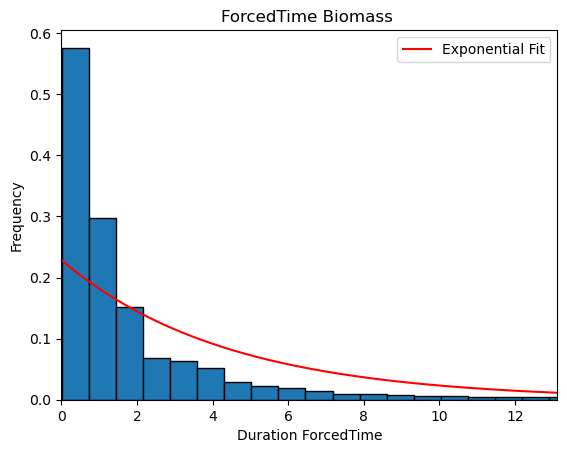

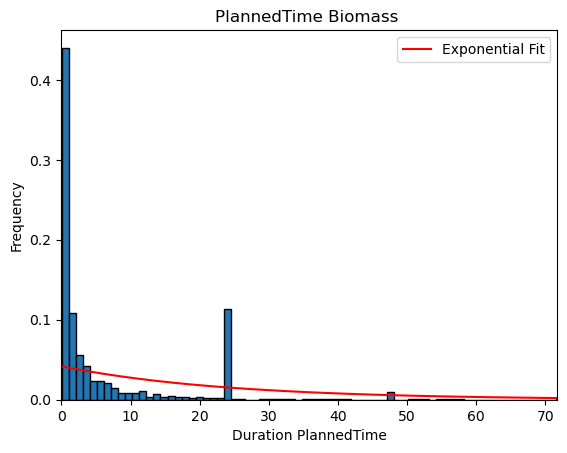

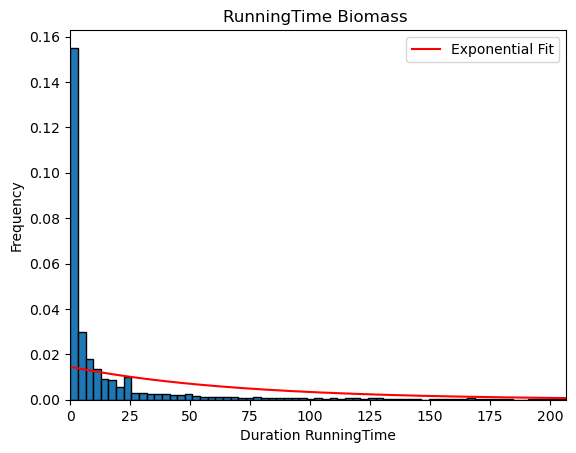

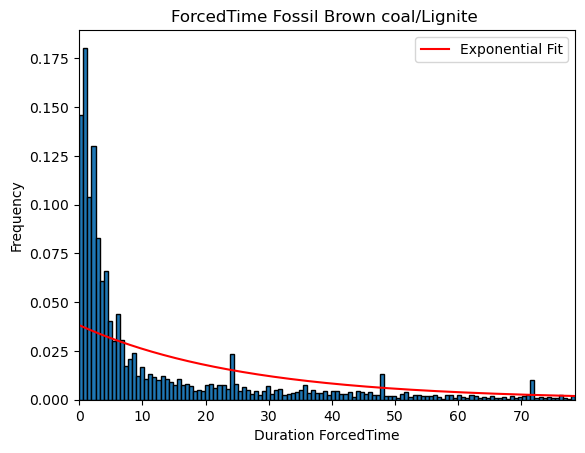

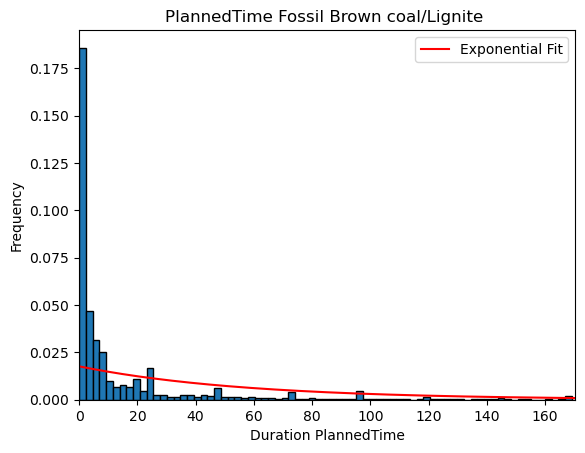

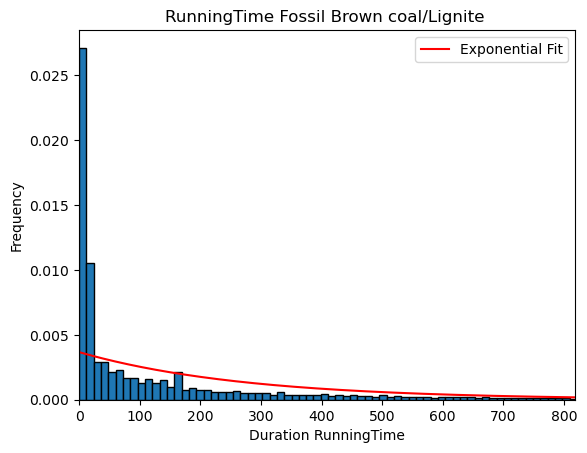

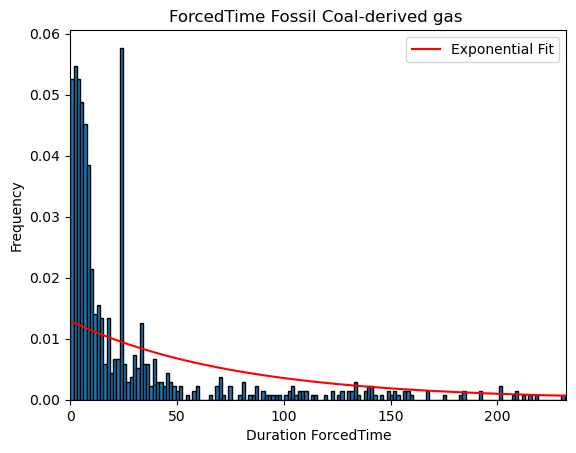

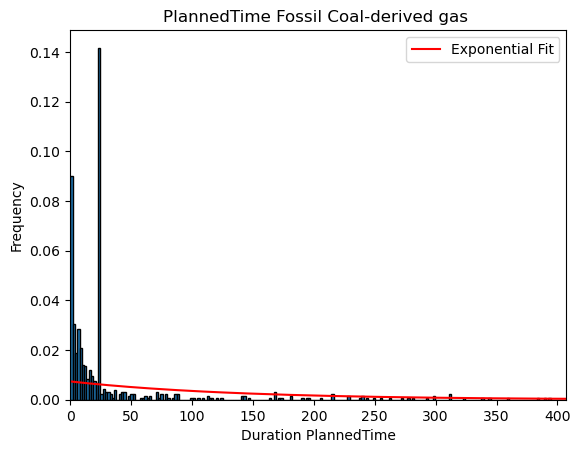

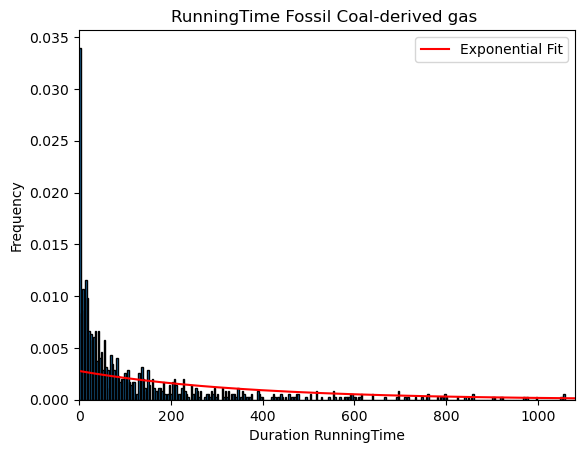

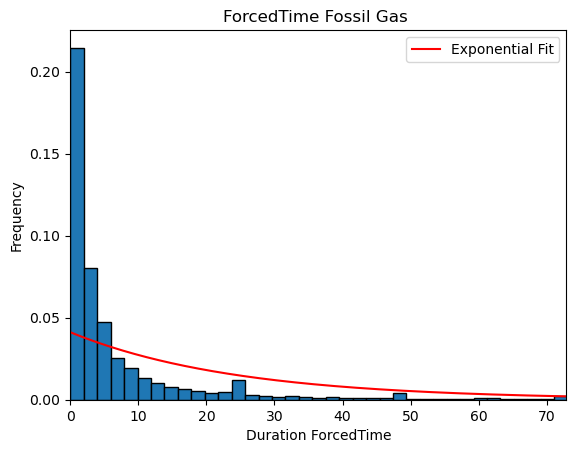

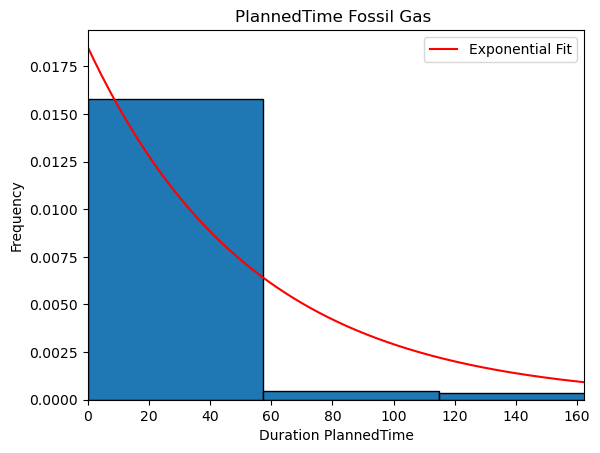

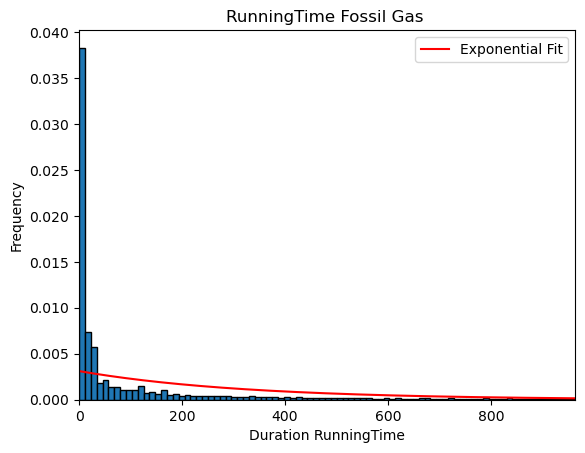

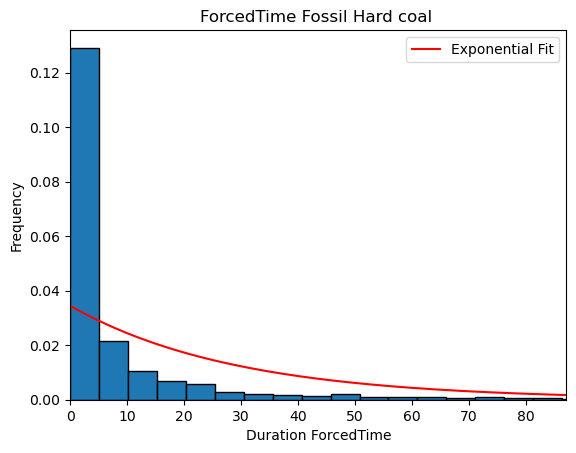

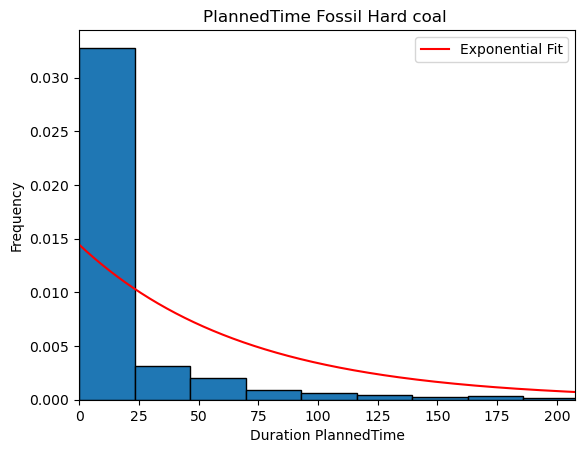

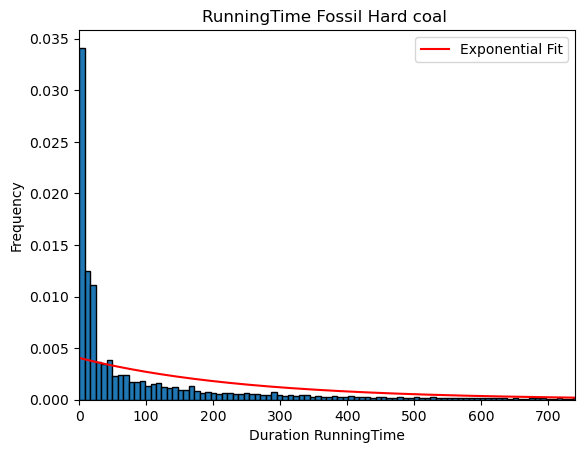

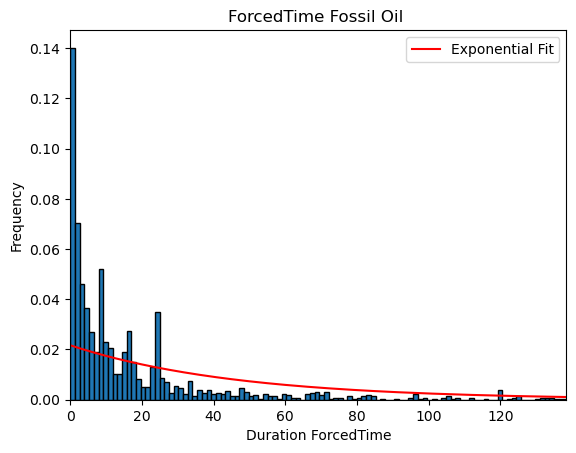

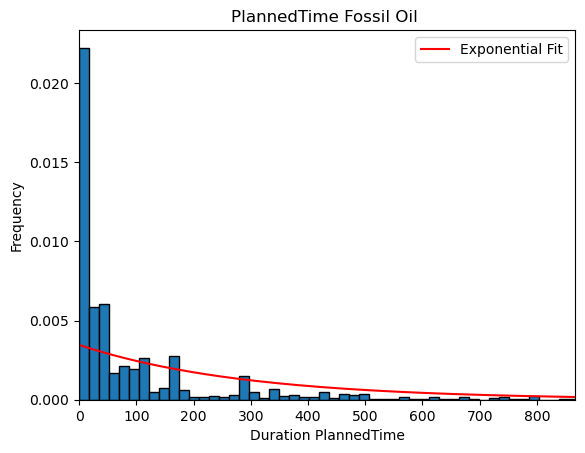

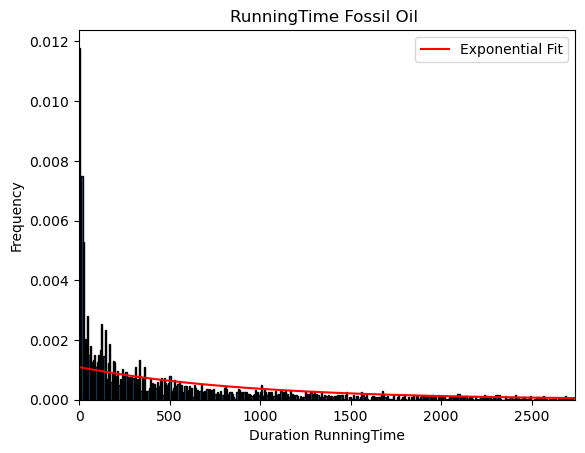

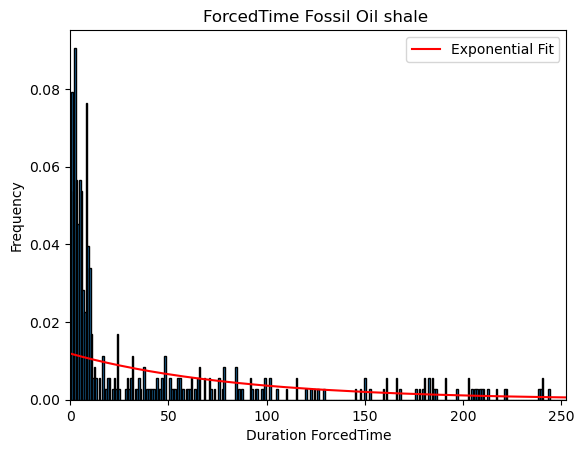

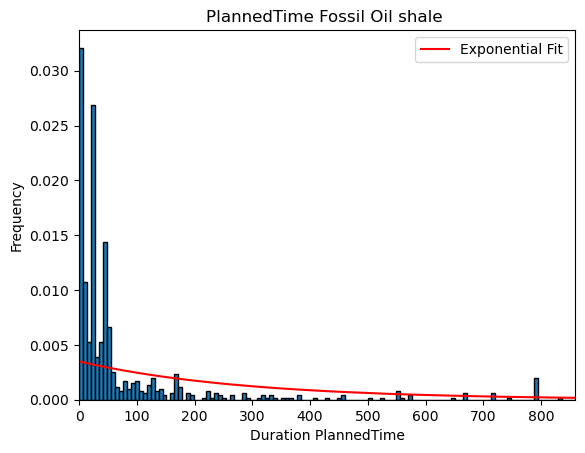

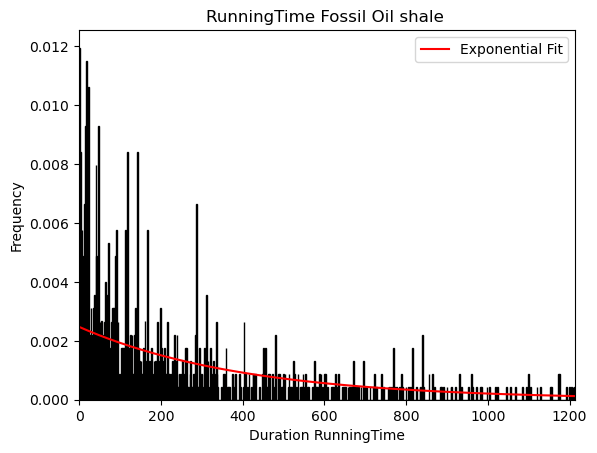

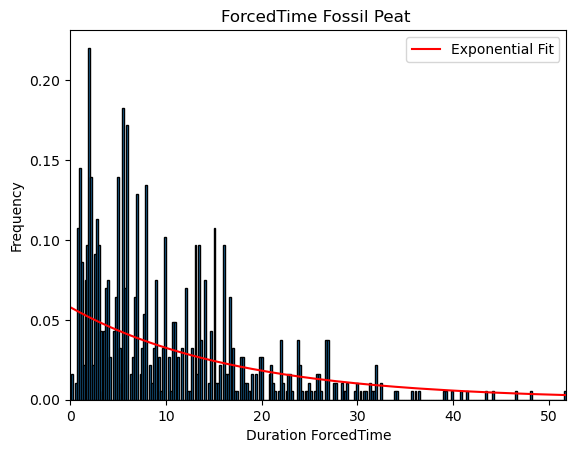

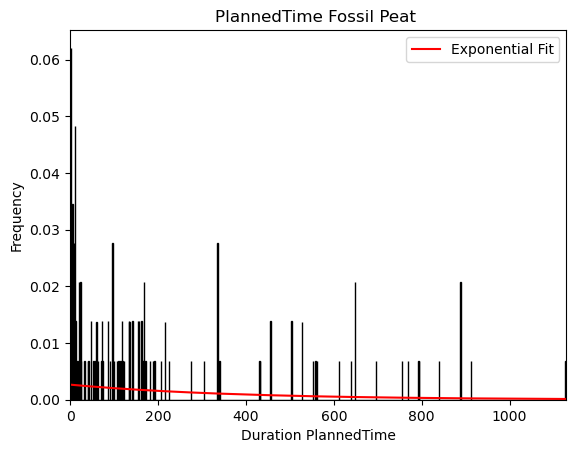

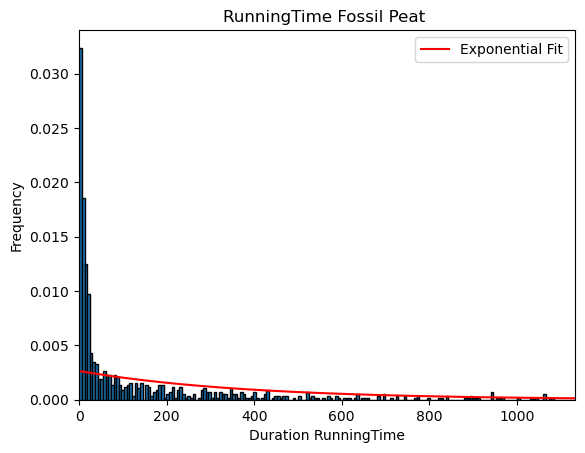

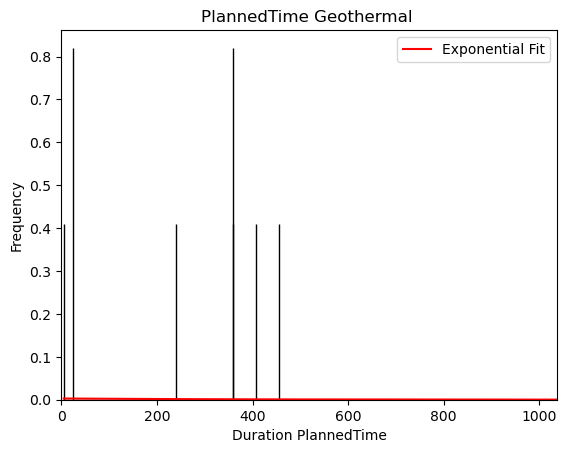

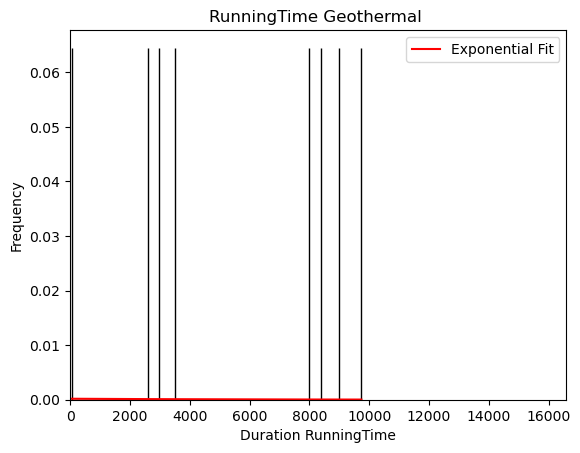

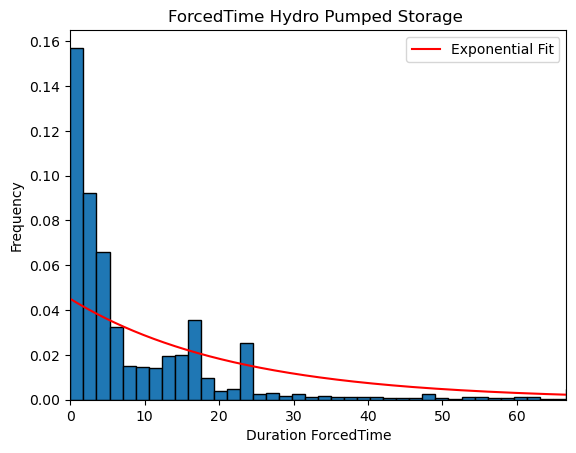

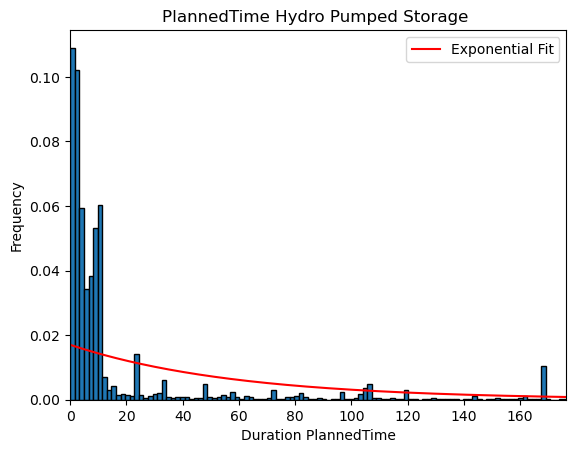

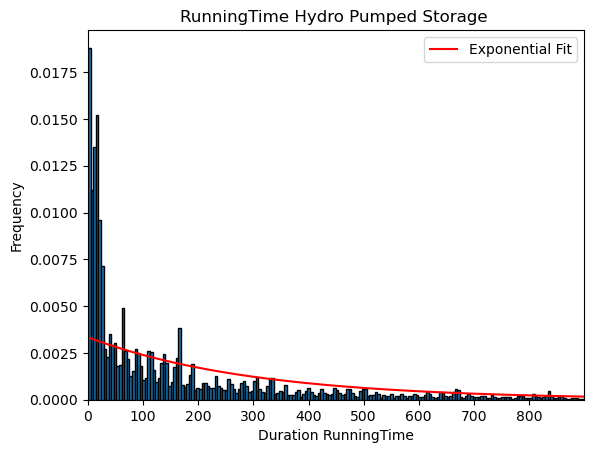

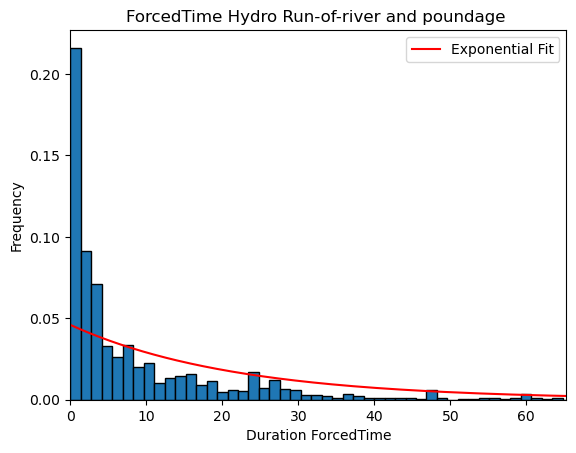

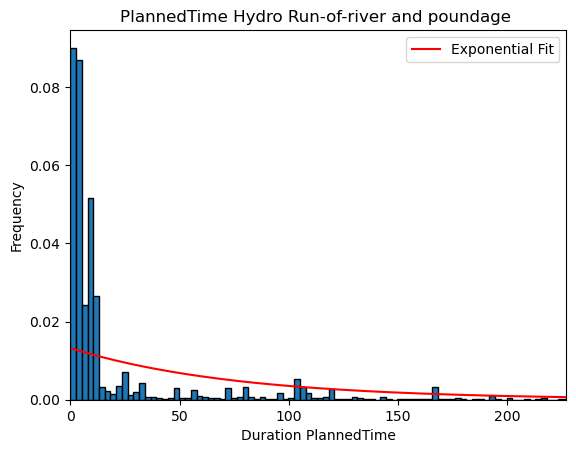

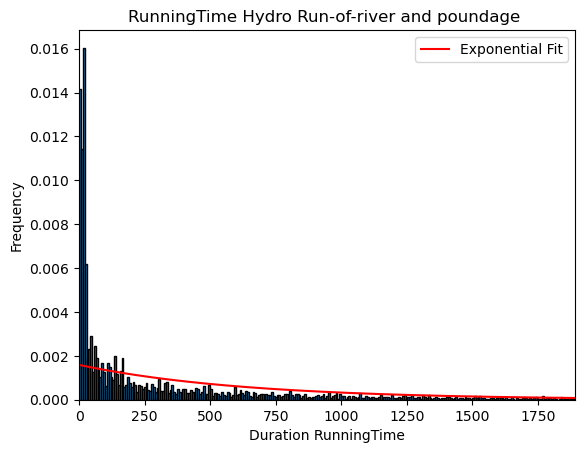

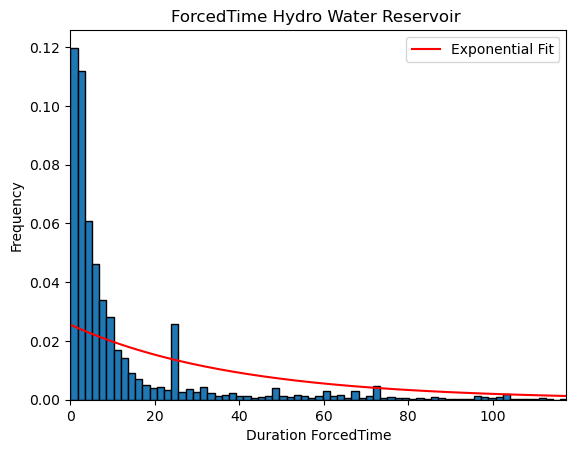

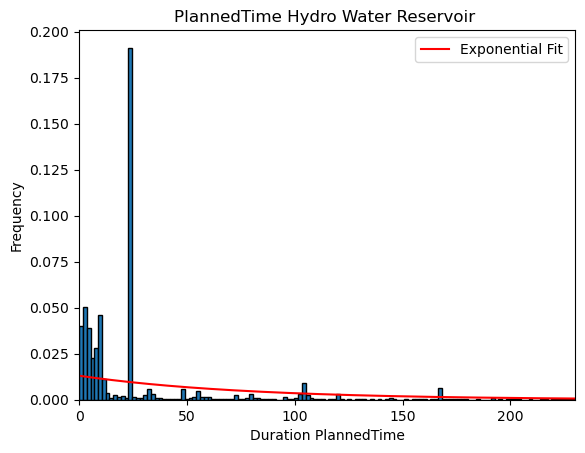

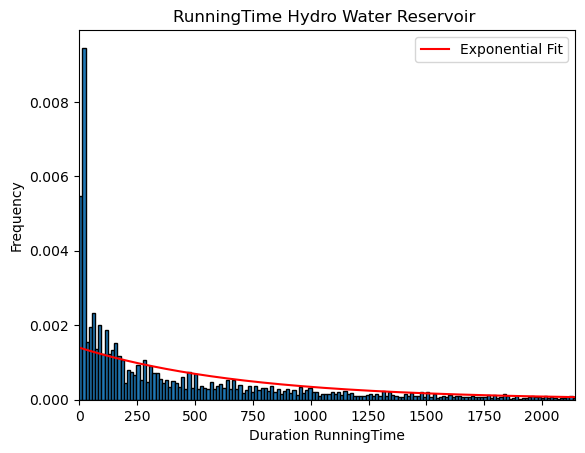

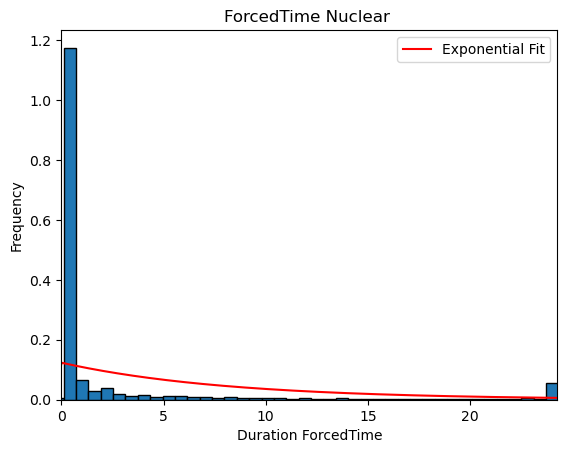

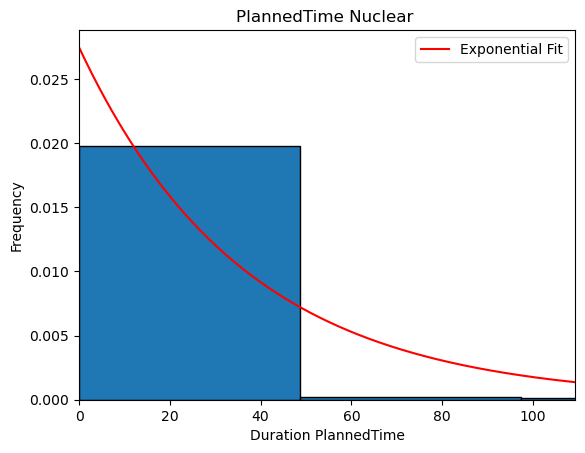

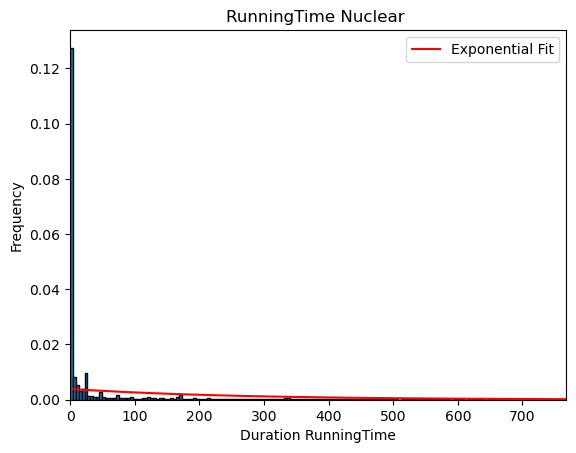

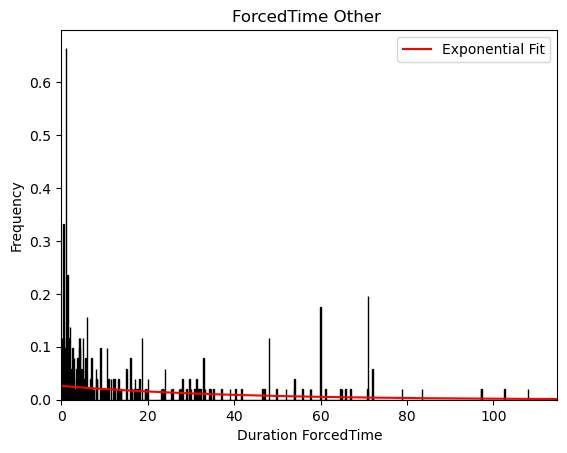

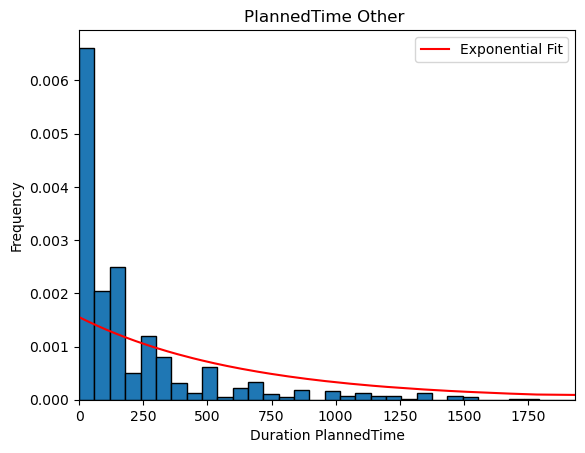

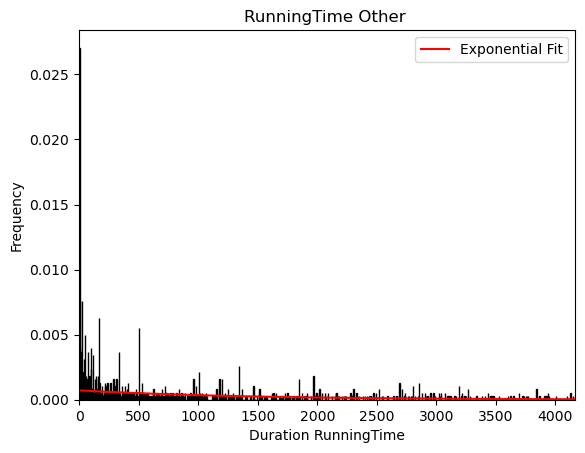

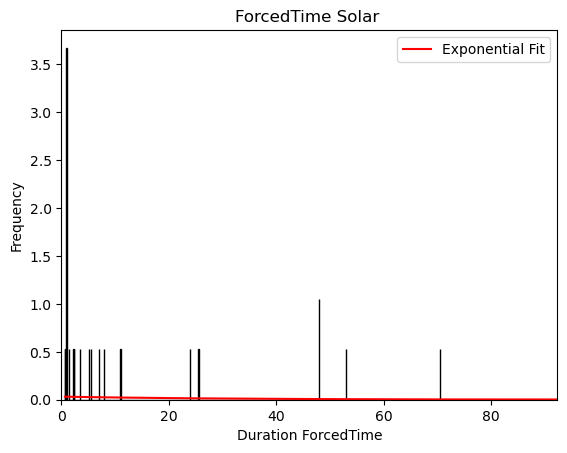

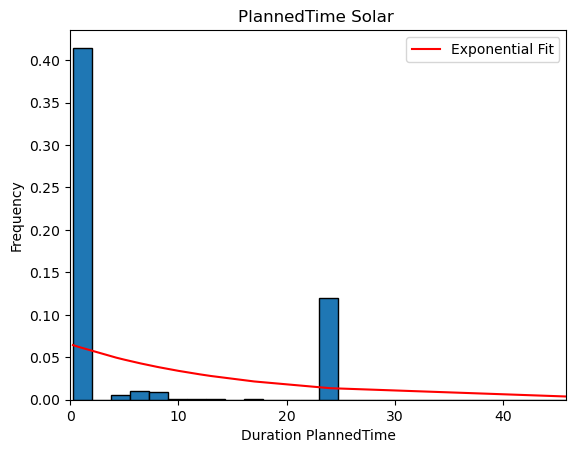

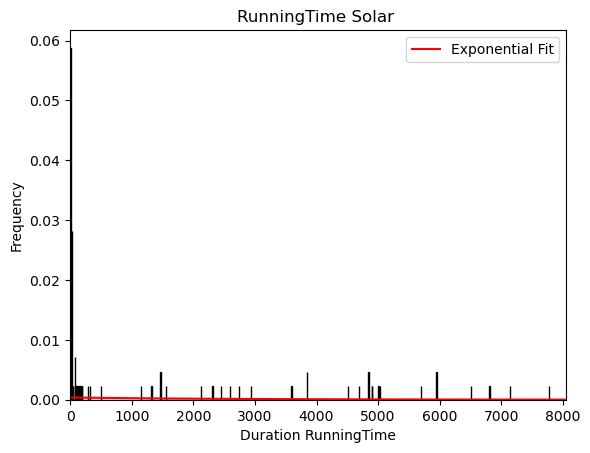

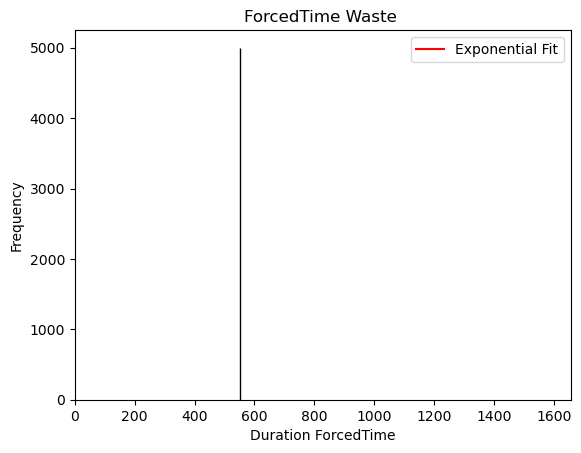

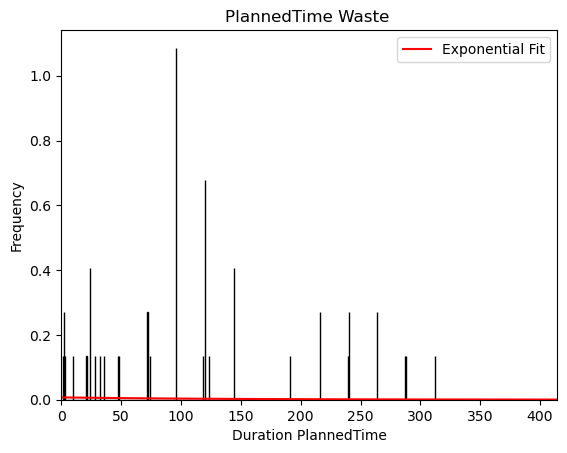

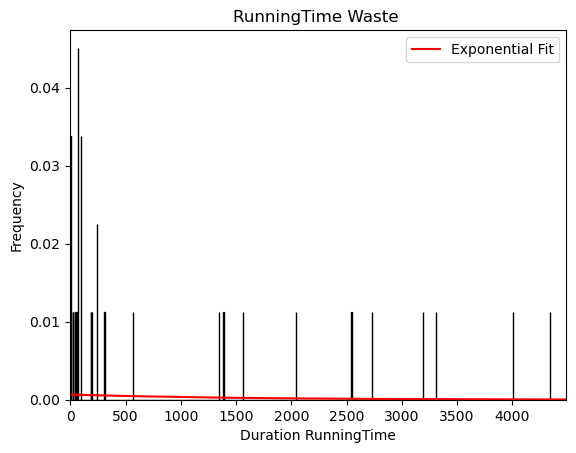

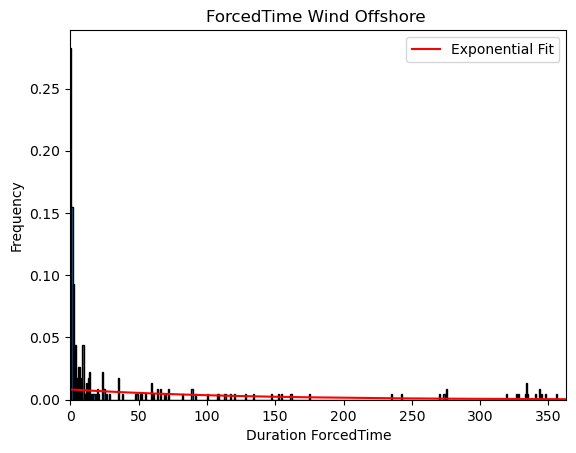

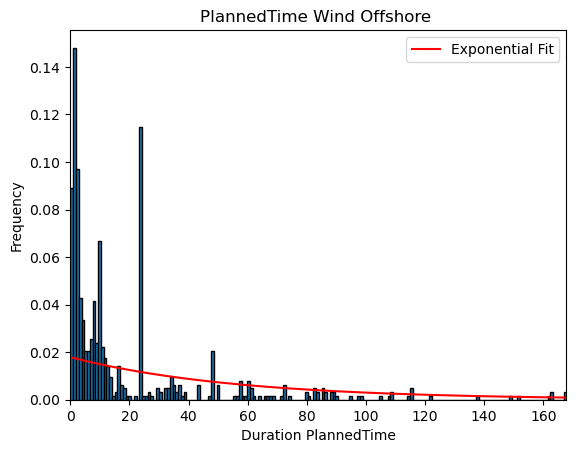

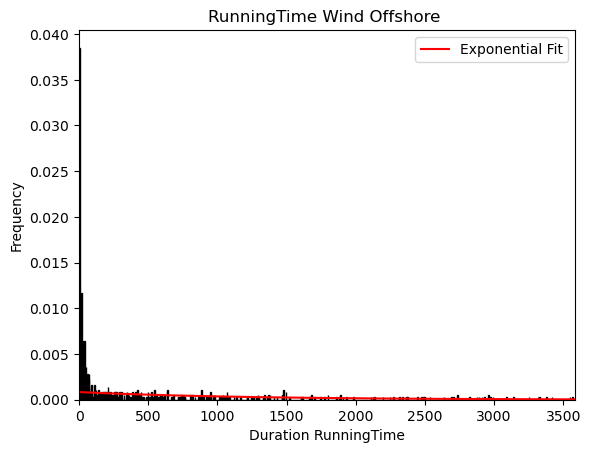

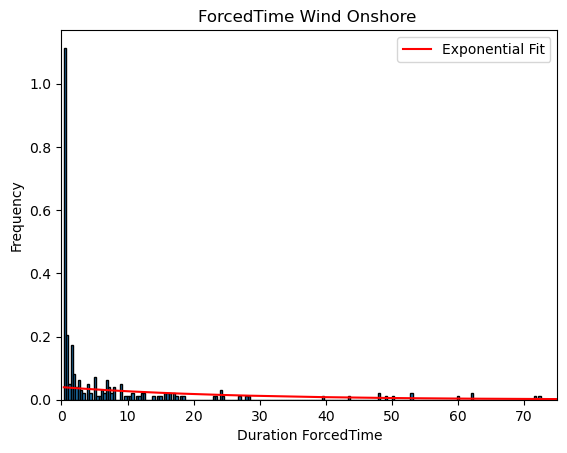

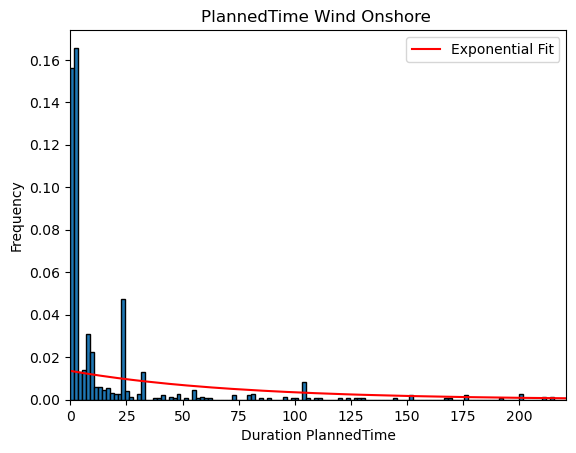

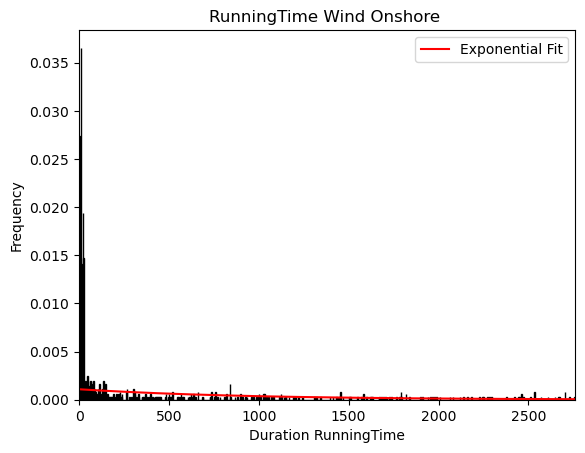

In [13]:

#fit outages distributions
params = pd.DataFrame() #create empty parameter table
grouped_delta = delta_df.groupby(["ProductionType"])
params["ProductionType"] = grouped_delta.first().reset_index()["ProductionType"]
for state in states:
    params[state + "Time"] = [np.nan]*len(list(params["ProductionType"]))


def exponential_fit(x, scale):
    return expon.pdf(x, scale=scale)


for group_name, group_df in grouped_delta:
    
    #We drop NaN valued rows
    #group_df = group_df.dropna(subset = ["UpTime","OffTime"])
    
    for state in states:
        if not pd.isna(group_df[state+"Time"].mean()):
            # Fit the data to the exponential function
            mean = group_df[state+"Time"].mean()
            state_scale = mean
            params.loc[params["ProductionType"] == group_name, state+"Time"] = state_scale
            plt.figure()
            plt.xlim(0, 3*mean)  # Adjust the values as needed
            #plt.ylim(0, 1)  # Adjust the values as needed
            plt.hist(group_df[state + "Time"], bins=5000, edgecolor='black', density=True)
            # Plot the fitted exponential distribution
            x = np.sort(group_df[state + "Time"])
            plt.plot(x, exponential_fit(x, scale = state_scale), 'r-', label='Exponential Fit')
            plt.xlabel(f'Duration {state + "Time"}')
            plt.ylabel('Frequency')
            plt.title(f'{state}Time {group_name}')
            plt.legend()
            plt.show()


#return

# Markov Chain modeling
In reality we may have more states: 
- On
- Off
- Mai (Maintenance) <br>
We can model the passage from one state to an other as a Homogeneous Markov State:
that is givens a state S1 we model the probability of going to each of the states: On, Off, Mai
and we assume this probability does not depend upon the states before S1.

In this section first we try to understand whether Maintenance has some regularity which may make it easy to predict in the future.
Then, given a set of States we try to model the transition probabilities of the associated Markov Chaint between each pair of states.


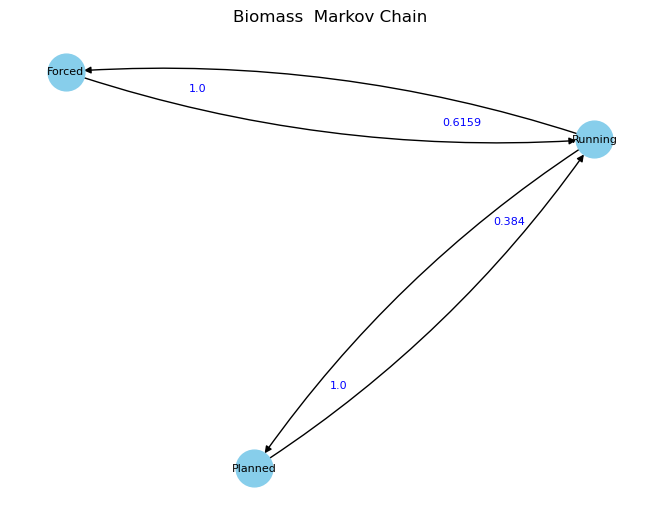

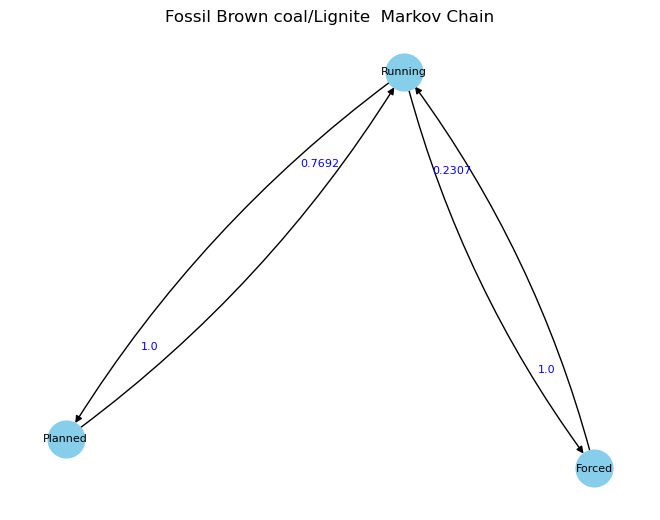

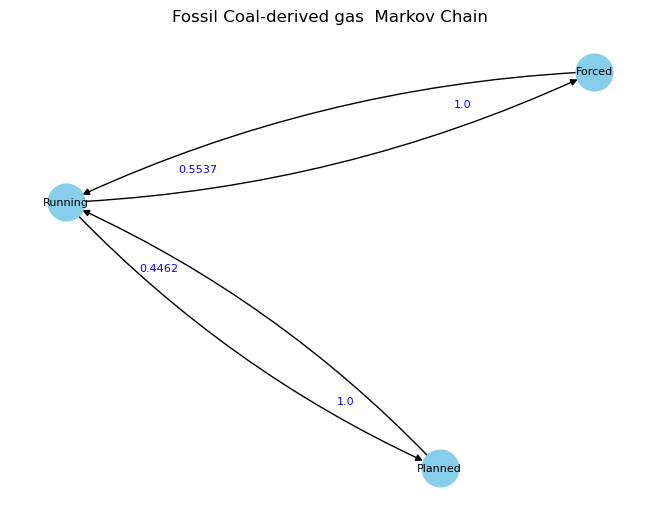

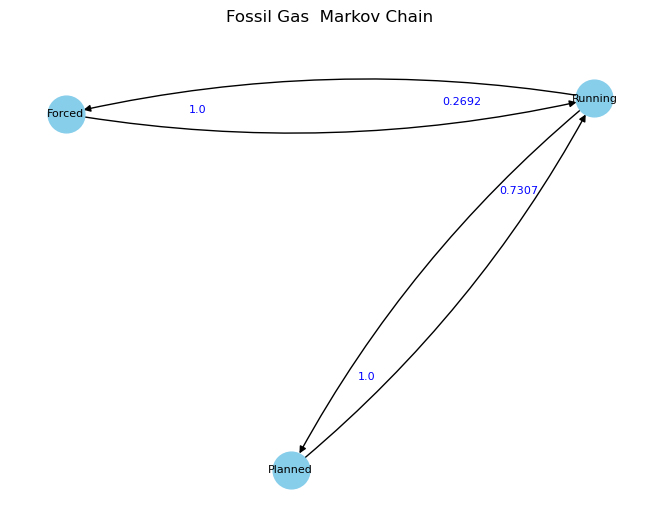

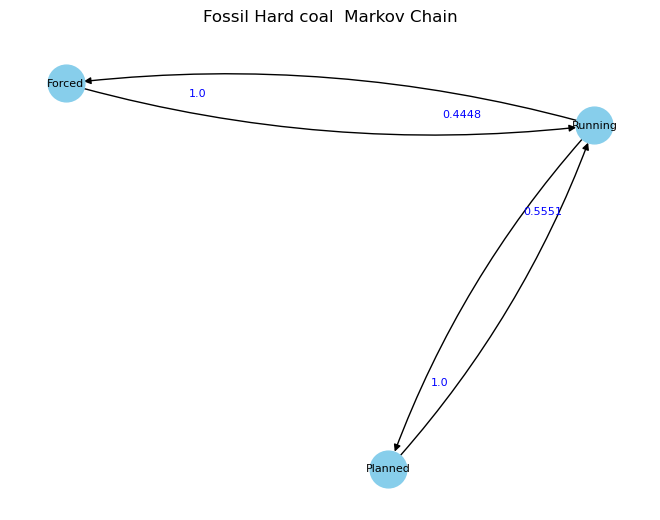

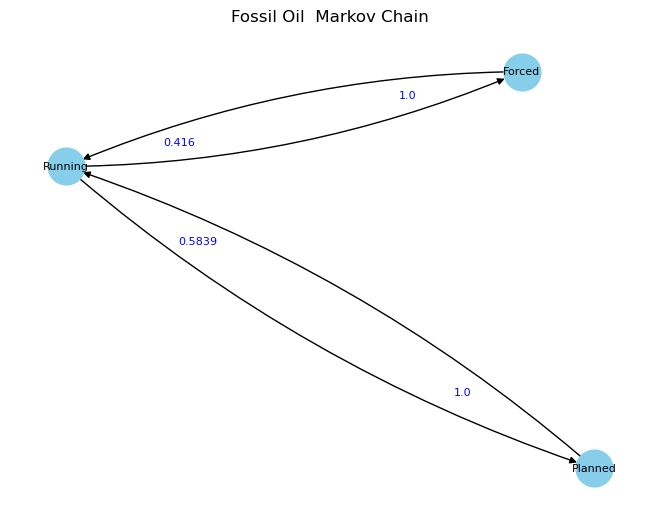

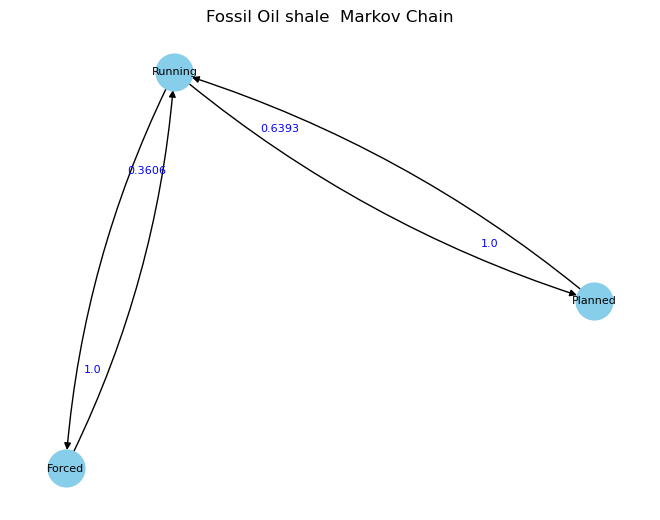

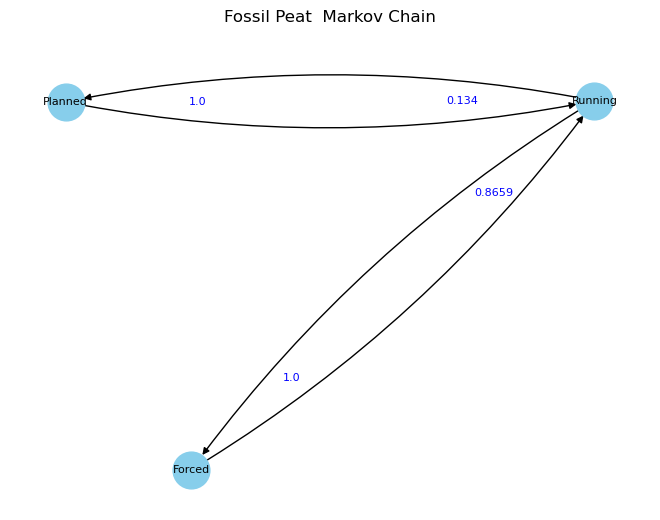

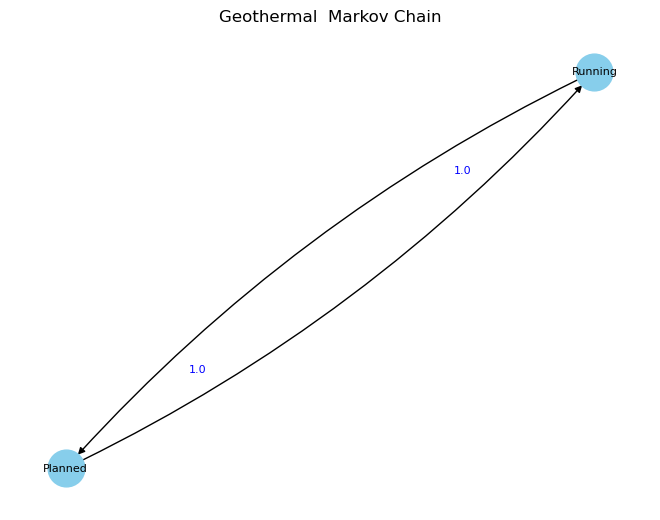

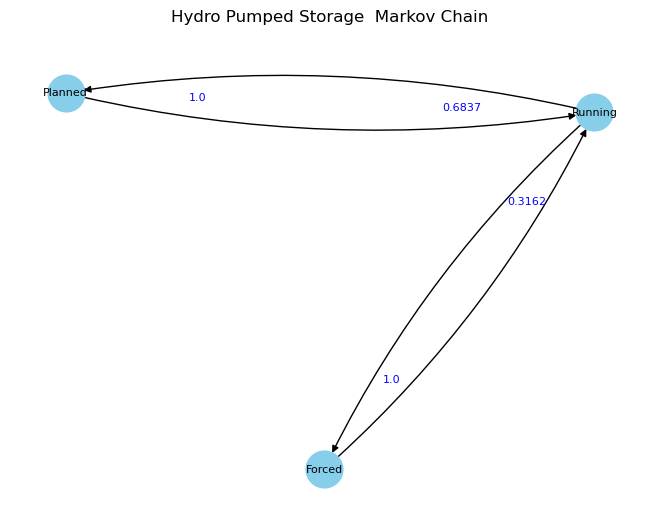

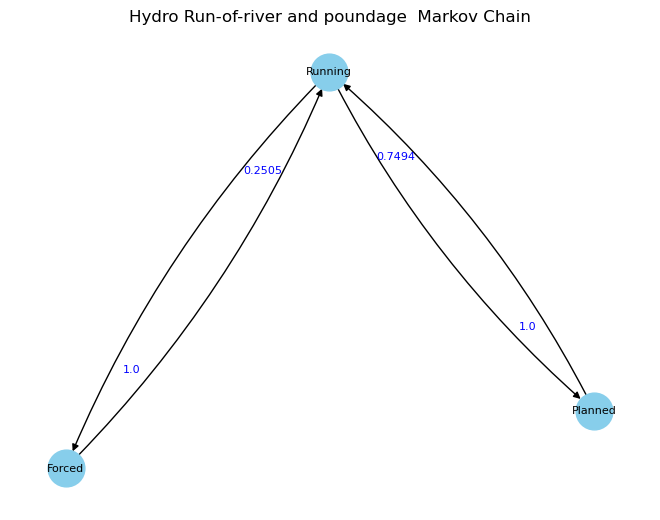

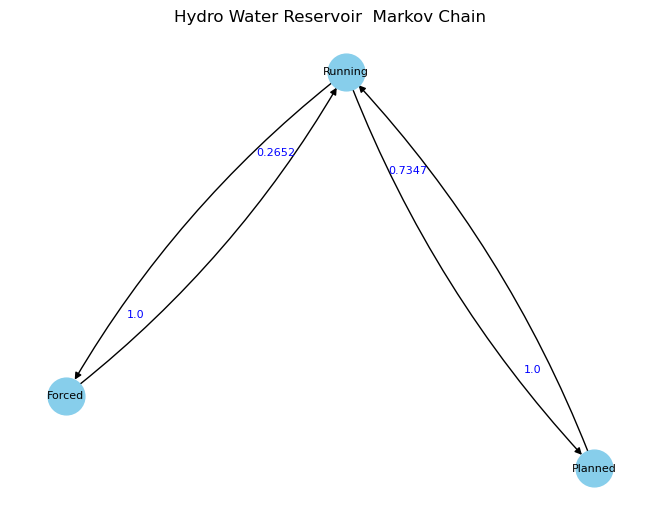

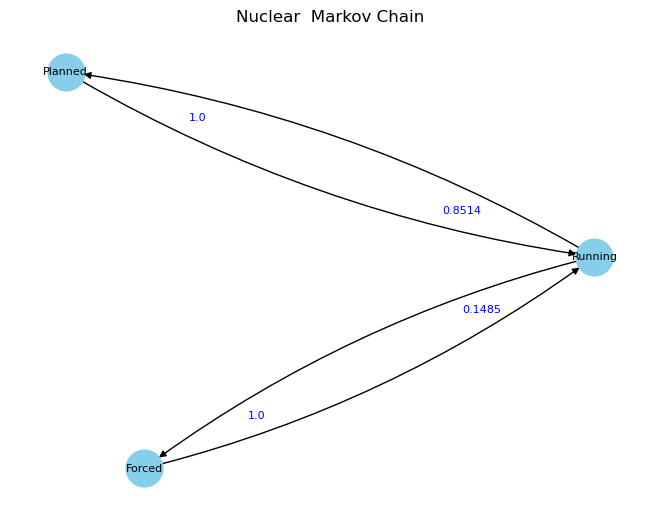

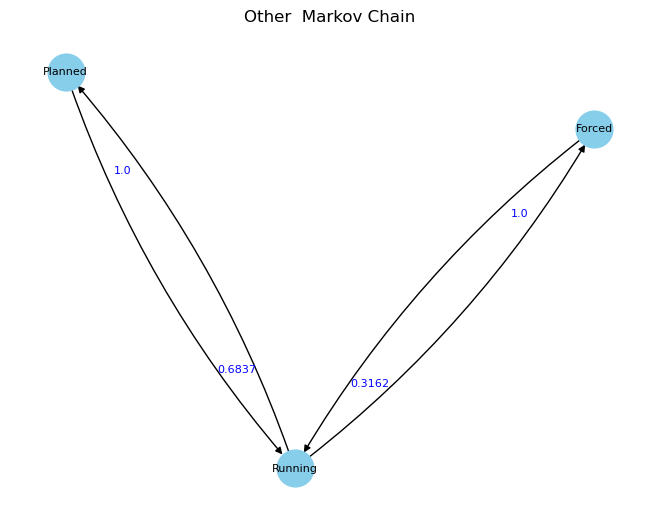

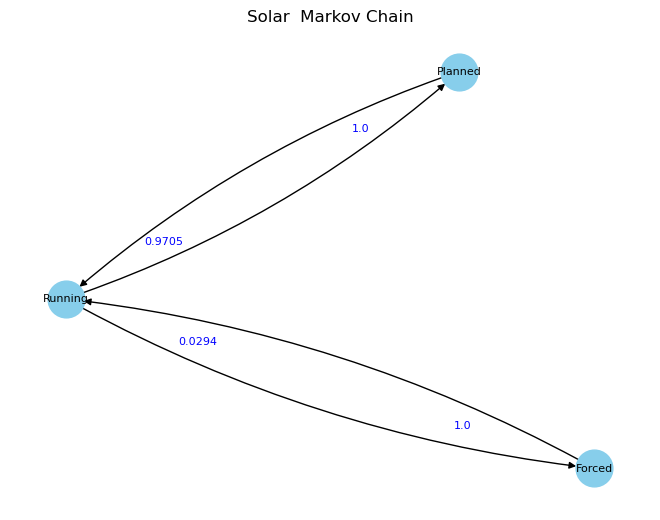

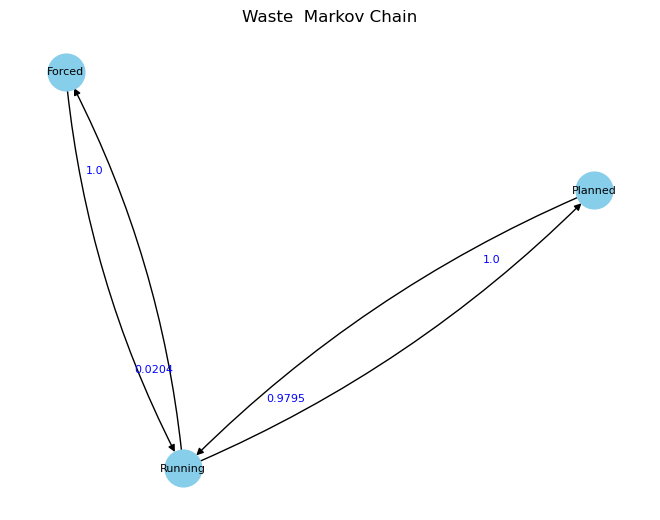

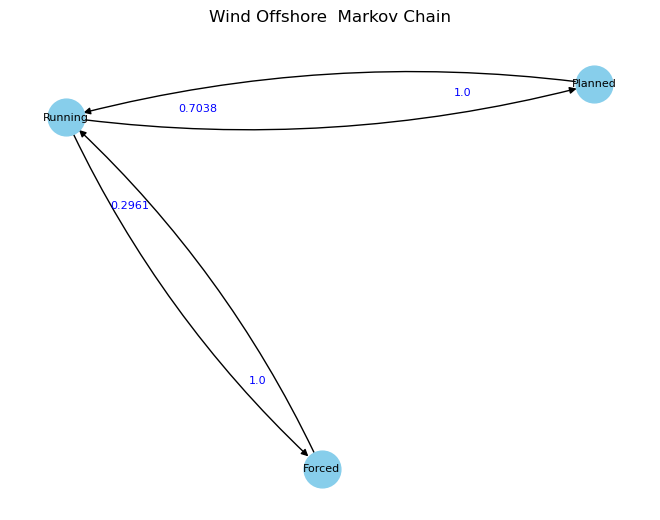

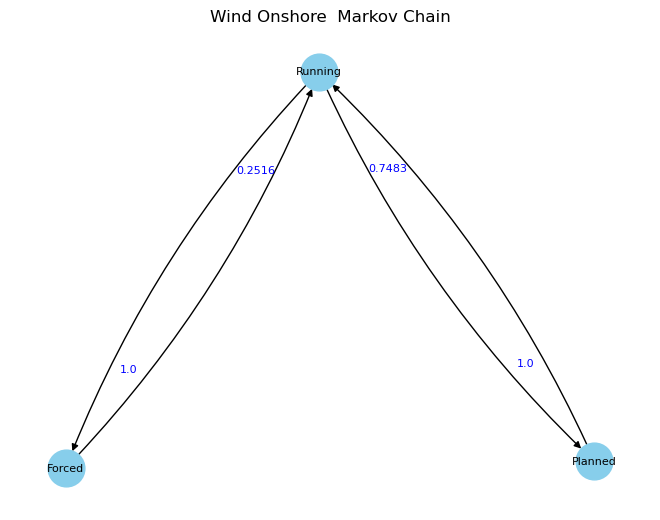

In [19]:
df = delta_df[delta_df["Reason"] != "Shutdown" ] #remove shutdowns 

markov_d= {}
#Create a list containing tuples rapresenting all possible state changes (x,y) := x --> y
#data is a dataframe containing the correct "UpTime" between the states considered

GenTypeGroup_df = df.groupby("ProductionType")

#We can use different states
#print markov chain for each type of generator
for production_type, data in GenTypeGroup_df:
    transitions_probs = get_markov_probs(data, "Type")
    markov_d[production_type] = transitions_probs
    markov_graph(transitions_probs, title = f"{production_type} Markov Chain")

#t_probs = dict(transitions_probs)
#for key, value in transitions_probs.items():
#    if value < 0.05:
#        del t_probs[key]
#print graph
    

# Capacity Modeling

C:\Users\riccaga\AppData\Local\Temp\1\ipykernel_11348\1037839417.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df["ProductionType"] == production_type[0]) & (df["Type"] == production_type[1]), "p.u."] = PU


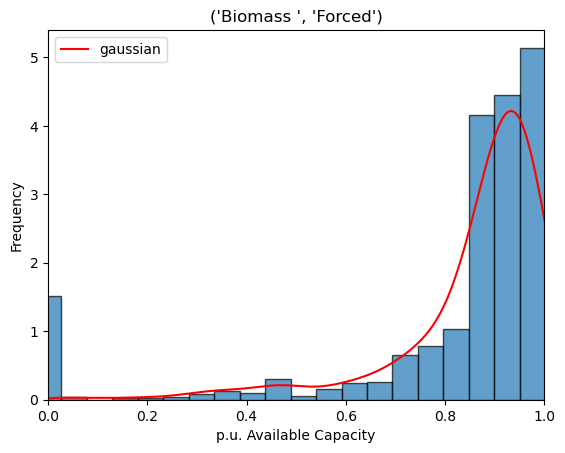

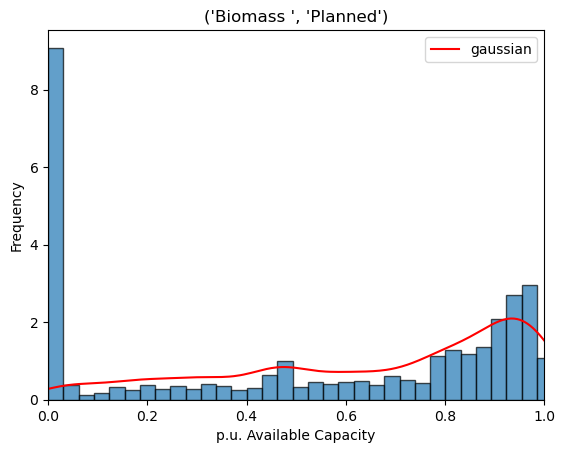

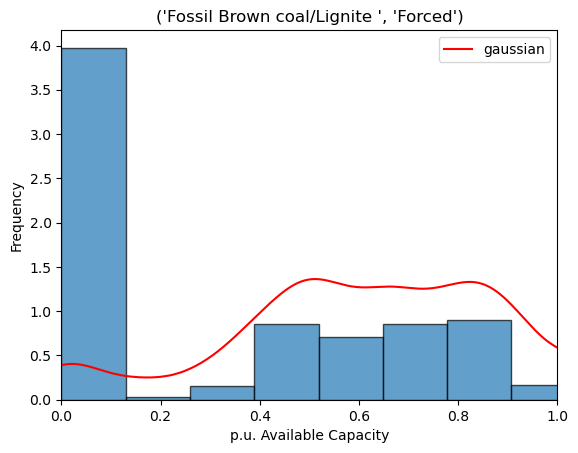

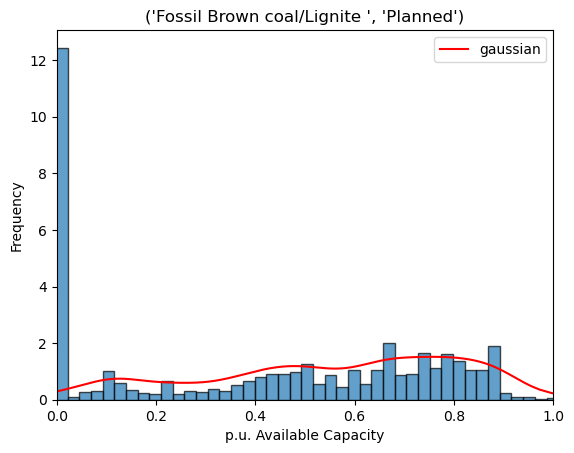

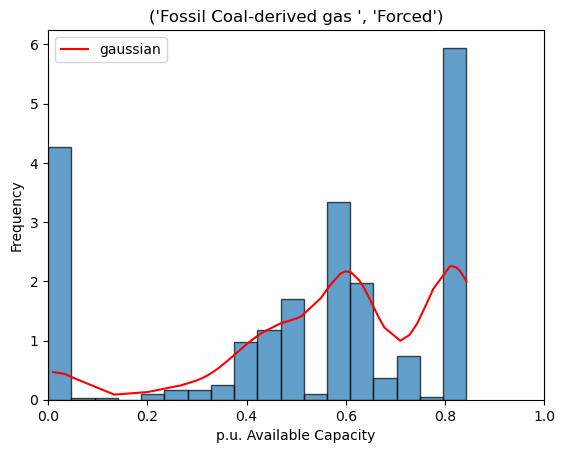

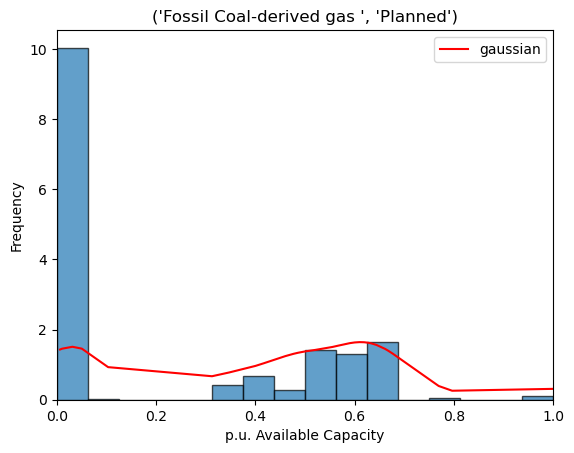

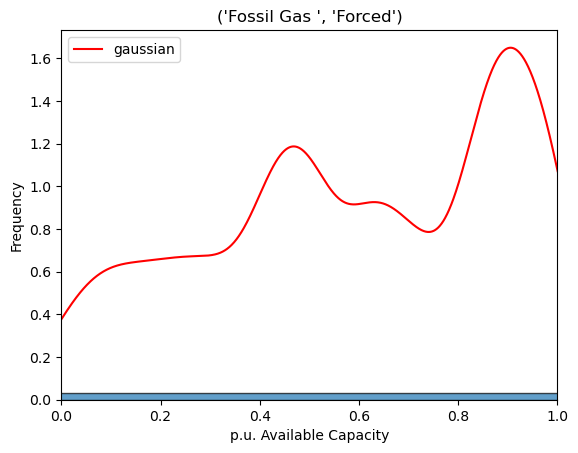

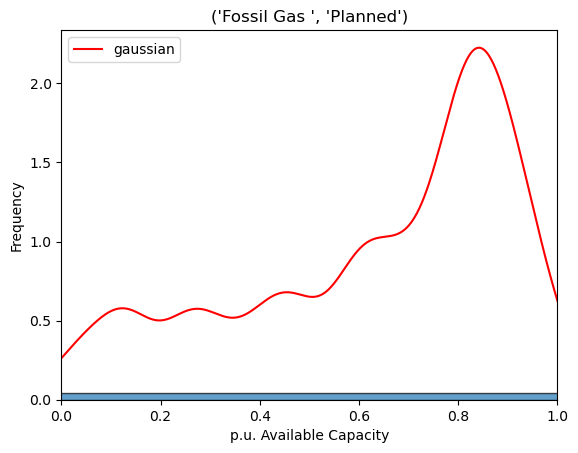

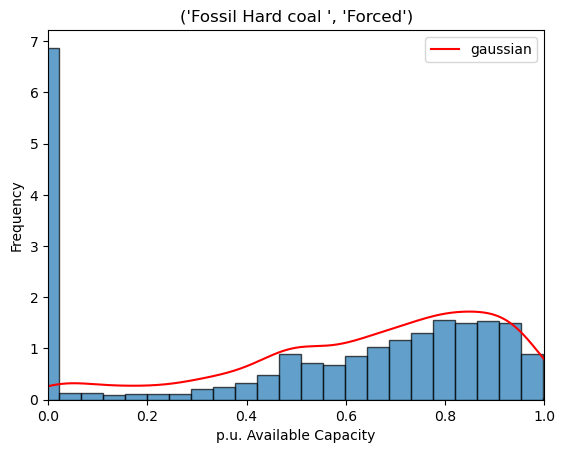

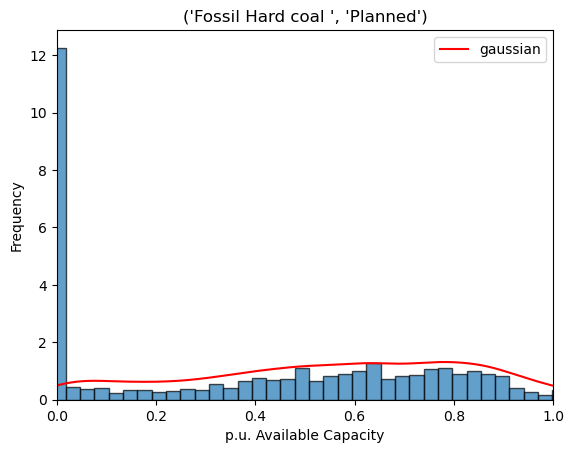

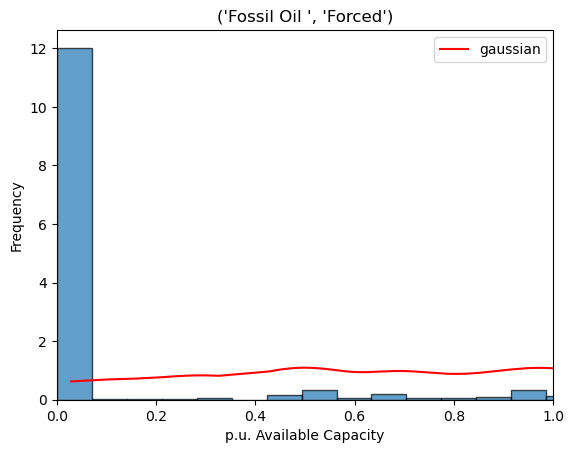

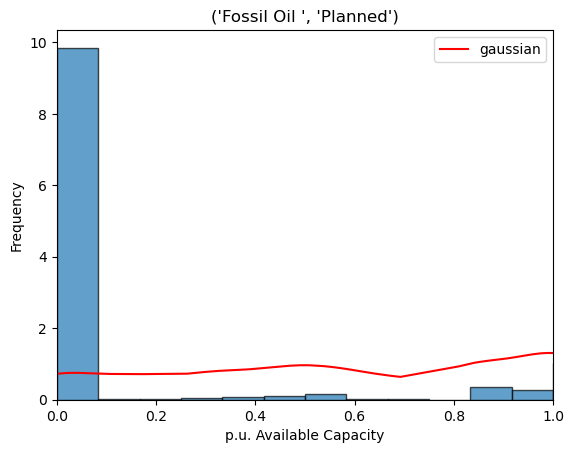

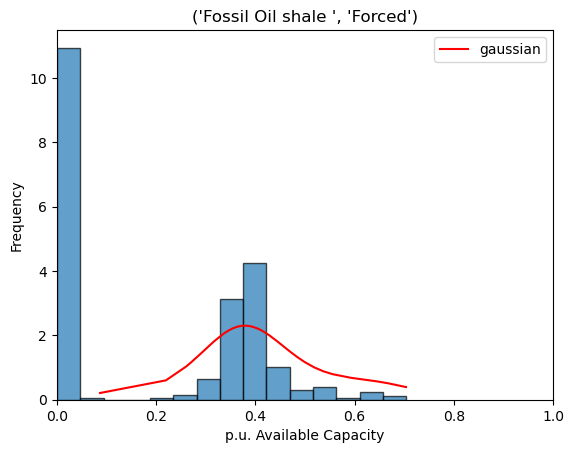

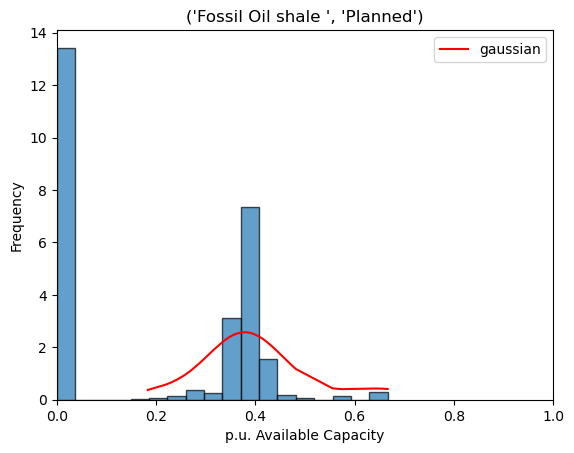

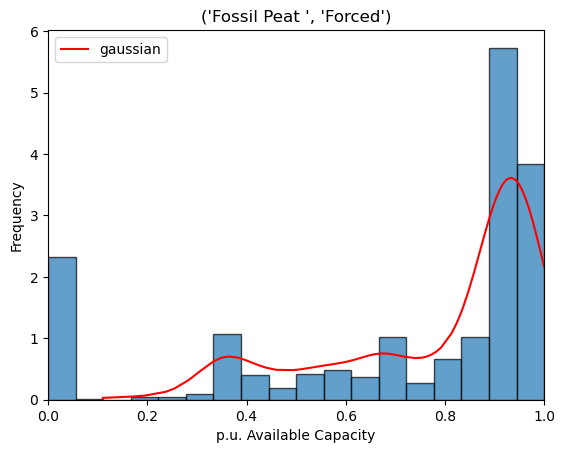

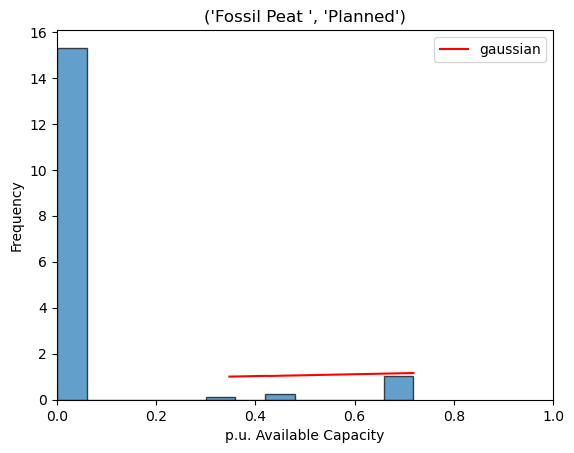

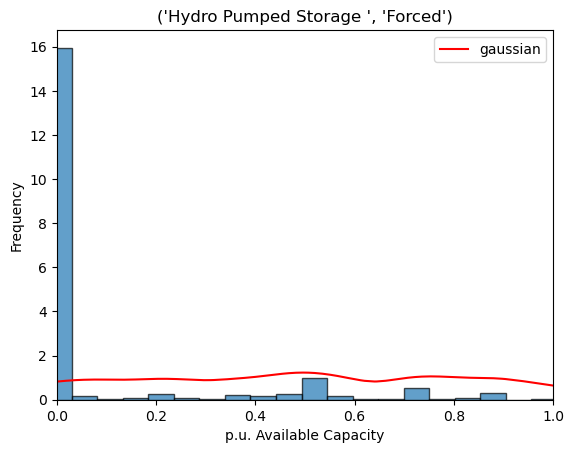

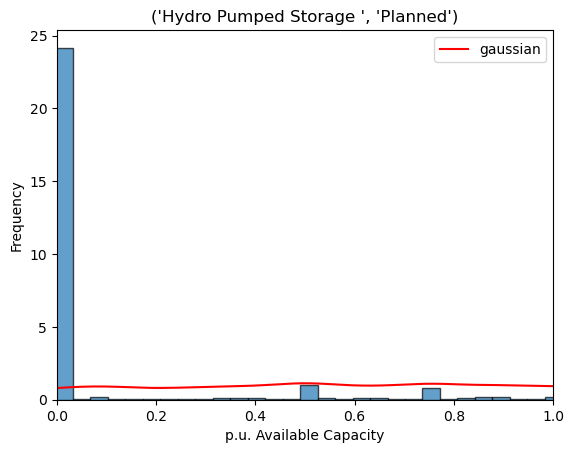

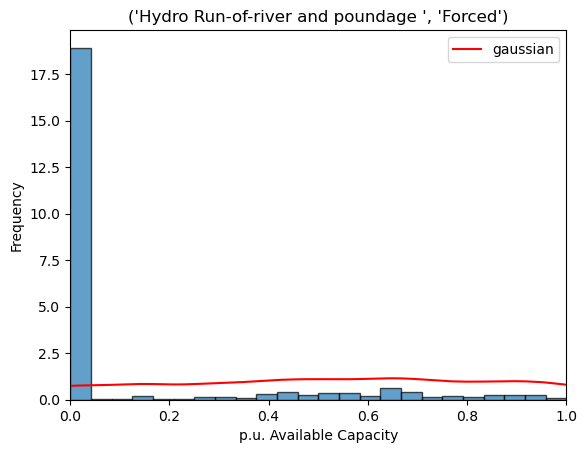

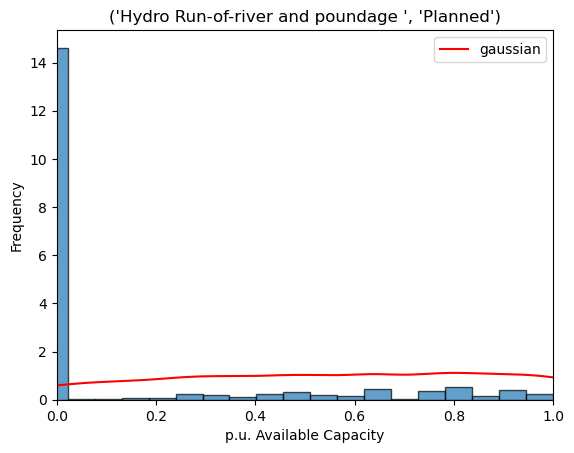

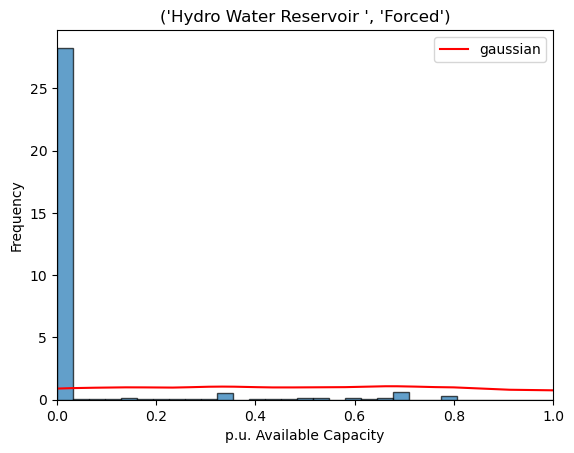

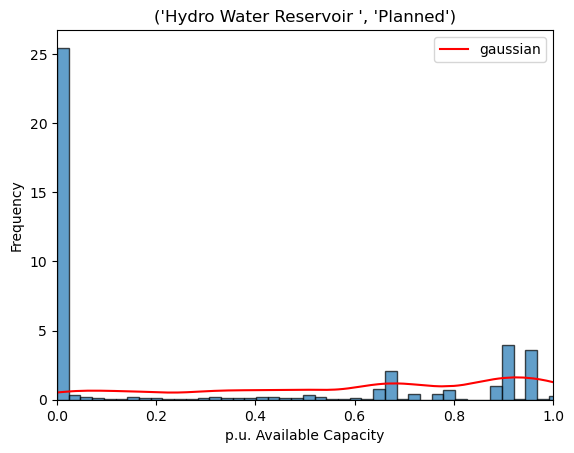

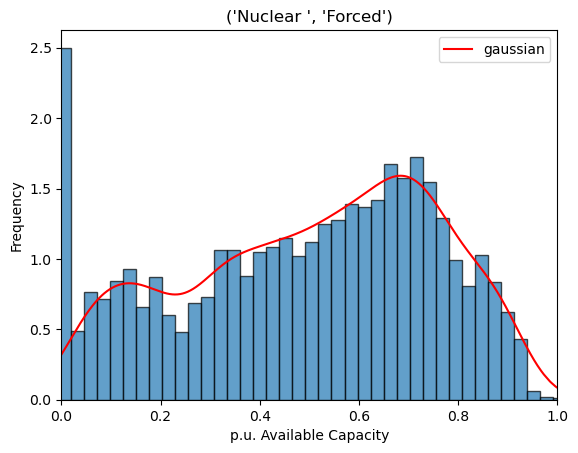

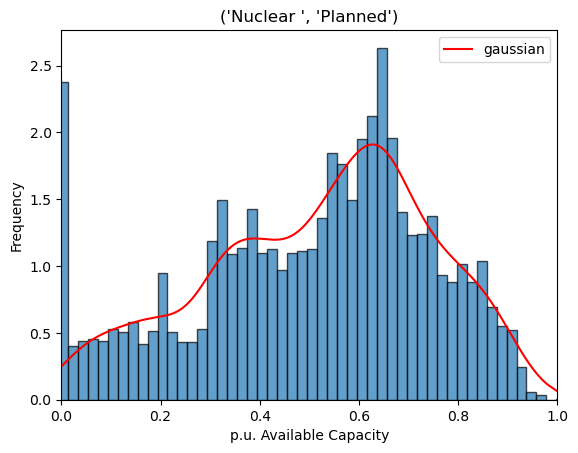

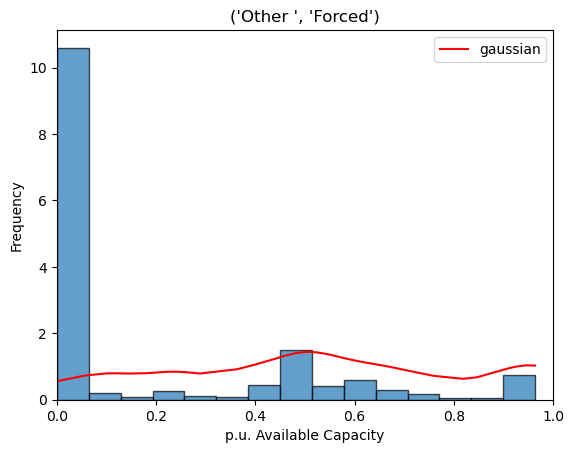

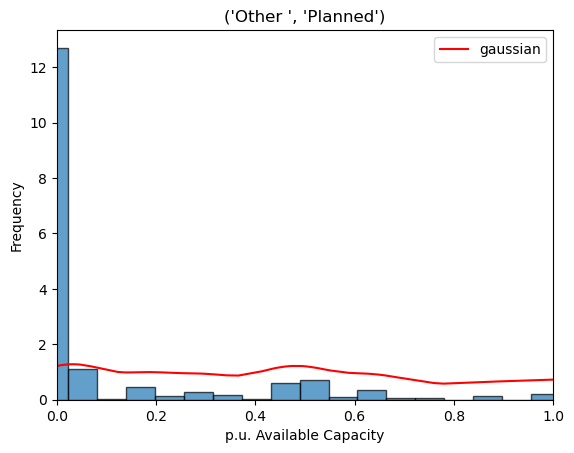

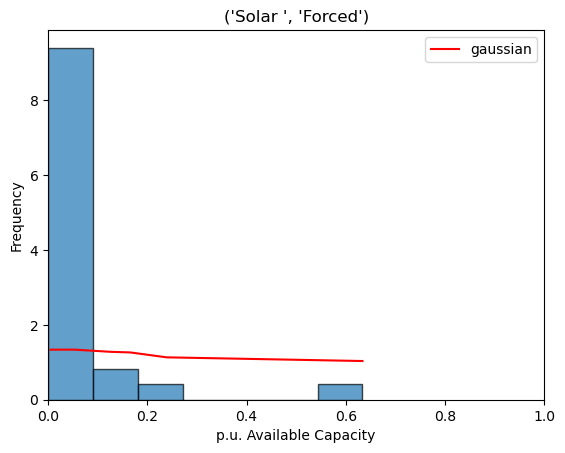

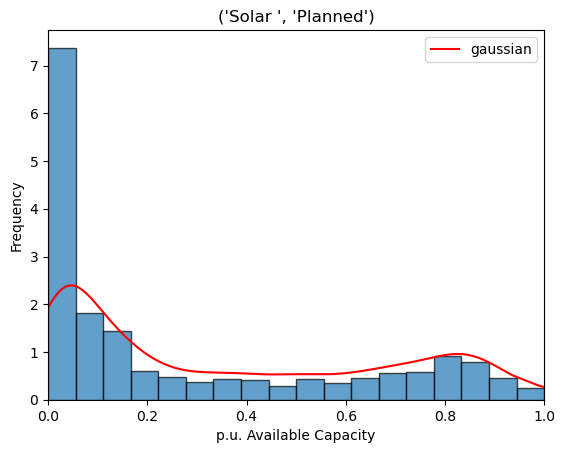

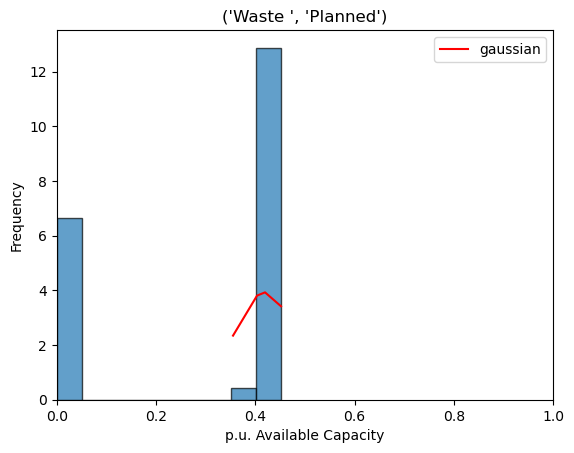

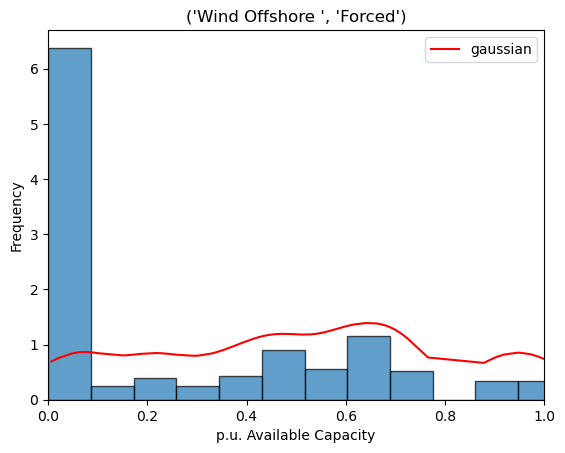

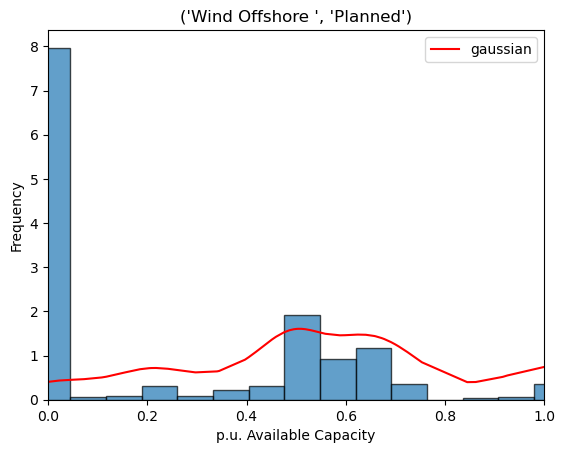

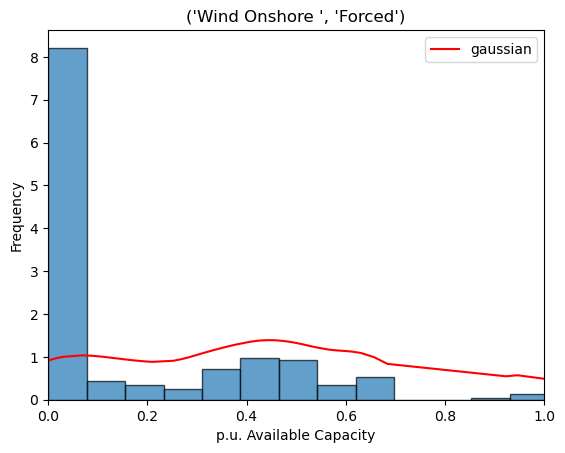

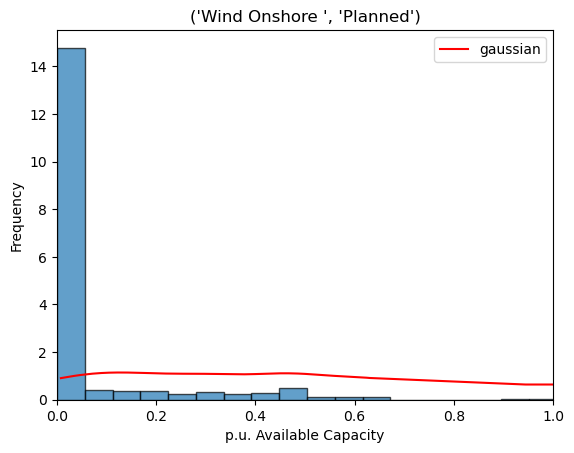

In [15]:
#With Kernel density estimation
grouped_df = df.groupby(["ProductionType", "Type"])
pdf_pu = {}
#idea: calculate prob for capacity = 0, remove and the use non parametric fit.
for production_type, prod_df in grouped_df:
    #calculate per unit available capacity
    PU = prod_df["AvailableCapacity"] / prod_df["InstalledCapacity"]
    df.loc[(df["ProductionType"] == production_type[0]) & (df["Type"] == production_type[1]), "p.u."] = PU
    PU = PU[~np.isnan(PU)]
    p_0 = np.sum(PU == 0) / len(PU)
    PUplus = np.sort(PU[PU != 0]) #non zero capacities
    if len(PUplus) != 0:
        
        colors = ["r"]
        kernels = ["gaussian"]
        lw = 2
        plt.figure()
        for color, kernel in zip(colors, kernels):
            kde = KernelDensity(kernel=kernel, bandwidth=0.05).fit(PUplus[:, np.newaxis])
            pdf_pu[production_type] = (p_0, kde)
            log_dens = kde.score_samples(PUplus[:, np.newaxis]) * len(PUplus) / len(PU) #scale to be prob on non zero values
            Y = np.exp(log_dens)
            plt.plot(PUplus, Y, color = color, label = kernel)
            
    
        # Plot histogram

        plt.xlim(0, 1)
        
        plt.hist(PU, bins=min(500, int(np.ceil(len(PU) ** (1. / 3))*3/2)) + 3 , edgecolor='black', alpha=0.7, density = True)

        # Customize the plot (add labels, title, etc.)
        plt.xlabel('p.u. Available Capacity')
        plt.ylabel('Frequency')
        plt.title(f'{production_type}')
        plt.legend()
        plt.show()

# Generating Scenarios

First the model is run for some time where the data is not saved to make the system reach an equilibrium state (in the beginning all the generators start in the running state but this is not realistic). Otherwise we can simply take the last recorded instance of the state of the generator an reroll the counter.

In [16]:
#Starting state --> we roll random running time for every generator the end
# todo: make the markov chaing run for a while to make the various generators get further in states
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
grouped  = df.groupby(["UnitName"]).first().reset_index()
gen_names = list(grouped["UnitName"])
gen_types = list(grouped["ProductionType"])
n_gens = len(gen_names)
pre_run_hours = 6*30*24 #time the chain is run for before producing data

states = ["Running", "Forced", "Planned"]
state_df = pd.DataFrame({"UnitName": gen_names, "ProductionType": gen_types, "State":["Running"]*n_gens, "Counter":[0]*n_gens, "Capacity":[1]*n_gens})
perc = np.ceil(pre_run_hours / 100)

for h in np.arange(pre_run_hours):
    
    if h % (perc) == 0:
        print(f"{h/pre_run_hours *100} %")
        print(state_df.head(5))
    
    for index, gen_row in state_df[state_df["Counter"] == 0].iterrows():
        gen_name = gen_row["UnitName"] #remove?
        gen_type = gen_row["ProductionType"]
        current_state = gen_row["State"]
        markov = markov_d[gen_type] #get associate markov chain
        
        new_state = next_state_markov(markov, current_state) #get new state of the generator
        
        scale = params.loc[params["ProductionType"] == gen_type, new_state + "Time"]
        new_counter = np.ceil(np.random.exponential(scale, 1)) #get number of hours spent in new_state
        
        #get the capacity of the generator in the currnent state
        if new_state == "Running":
            new_capacity = 1
        elif (gen_type, new_state) in pdf_pu.keys():
            p_zero, pu_pdf = pdf_pu[(gen_type, new_state)]
            if np.random.random_sample(1)[0] <= p_zero:
                new_capacity = 0
            else:
                new_capacity = pu_pdf.sample(1)
                if new_capacity < 0:
                    new_capacity = 0
                elif new_capacity > 1:
                    new_capacity = 1
        else:
            #todo this should not happen
            #print(f"no capacity distribution for {gen_type}")
            new_capacity = 1
        
        state_df.loc[index, ["State", "Counter", "Capacity"]] = [new_state, new_counter, new_capacity]
        
    state_df.loc[state_df["Counter"] != 0, "Counter"] -= 1
    
#idea: 
# while t < 10 years roll dices take final state and final counter

0.0 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running        0         1
1  ABO¿O 2  Fossil Hard coal   Running        0         1
2  ABOÑO 1  Fossil Hard coal   Running        0         1
3  ABOÑO 2  Fossil Hard coal   Running        0         1
4    ABTH7  Fossil Hard coal   Running        0         1
1.0185185185185186 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      225  1.000000
1  ABO¿O 2  Fossil Hard coal   Running      536  1.000000
2  ABOÑO 1  Fossil Hard coal   Planned        2  0.000000
3  ABOÑO 2  Fossil Hard coal   Planned       30  0.792785
4    ABTH7  Fossil Hard coal   Running       17  1.000000
2.037037037037037 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      181  1.000000
1  ABO¿O 2  Fossil Hard coal   Running      492  1.000000
2  ABOÑO 1  Fossil Hard coal   Planned      213  0.000000
3  ABOÑO 2  Fossil Hard c

23.425925925925924 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      363  1.000000
1  ABO¿O 2  Fossil Hard coal   Running      262  1.000000
2  ABOÑO 1  Fossil Hard coal   Planned       66  0.751134
3  ABOÑO 2  Fossil Hard coal   Running      411  1.000000
4    ABTH7  Fossil Hard coal   Running       43  1.000000
24.444444444444443 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      319  1.000000
1  ABO¿O 2  Fossil Hard coal   Running      218  1.000000
2  ABOÑO 1  Fossil Hard coal   Planned       22  0.751134
3  ABOÑO 2  Fossil Hard coal   Running      367  1.000000
4    ABTH7  Fossil Hard coal   Planned       74  0.731898
25.462962962962965 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      275  1.000000
1  ABO¿O 2  Fossil Hard coal   Running      174  1.000000
2  ABOÑO 1  Fossil Hard coal   Running        2  1.000000
3  ABOÑO 

46.85185185185185 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal    Forced       13       0.0
1  ABO¿O 2  Fossil Hard coal   Running        1       1.0
2  ABOÑO 1  Fossil Hard coal   Running      325       1.0
3  ABOÑO 2  Fossil Hard coal   Running      242       1.0
4    ABTH7  Fossil Hard coal   Running      123       1.0
47.87037037037037 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running       12       1.0
1  ABO¿O 2  Fossil Hard coal   Planned      253       0.0
2  ABOÑO 1  Fossil Hard coal   Running      281       1.0
3  ABOÑO 2  Fossil Hard coal   Running      198       1.0
4    ABTH7  Fossil Hard coal   Running       79       1.0
48.888888888888886 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Planned       83  0.544756
1  ABO¿O 2  Fossil Hard coal   Planned      209  0.000000
2  ABOÑO 1  Fossil Hard coal   Running      237  1.000000
3  ABOÑO 2 

70.27777777777777 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      495       1.0
1  ABO¿O 2  Fossil Hard coal   Running       57       1.0
2  ABOÑO 1  Fossil Hard coal   Running       38       1.0
3  ABOÑO 2  Fossil Hard coal   Running      236       1.0
4    ABTH7  Fossil Hard coal   Running       54       1.0
71.29629629629629 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      451       1.0
1  ABO¿O 2  Fossil Hard coal   Running       13       1.0
2  ABOÑO 1  Fossil Hard coal   Running      690       1.0
3  ABOÑO 2  Fossil Hard coal   Running      192       1.0
4    ABTH7  Fossil Hard coal   Running       10       1.0
72.31481481481481 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      407  1.000000
1  ABO¿O 2  Fossil Hard coal   Running      532  1.000000
2  ABOÑO 1  Fossil Hard coal   Running      646  1.000000
3  ABOÑO 2  

93.7037037037037 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      859       1.0
1  ABO¿O 2  Fossil Hard coal   Running       61       1.0
2  ABOÑO 1  Fossil Hard coal   Planned       62       0.0
3  ABOÑO 2  Fossil Hard coal   Running      138       1.0
4    ABTH7  Fossil Hard coal   Running       12       1.0
94.72222222222221 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      815  1.000000
1  ABO¿O 2  Fossil Hard coal   Running       17  1.000000
2  ABOÑO 1  Fossil Hard coal   Planned       18  0.000000
3  ABOÑO 2  Fossil Hard coal   Running       94  1.000000
4    ABTH7  Fossil Hard coal   Planned       60  0.497289
95.74074074074073 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      771  1.000000
1  ABO¿O 2  Fossil Hard coal   Running      135  1.000000
2  ABOÑO 1  Fossil Hard coal   Running      159  1.000000
3  ABOÑO 2  F

In [20]:
state_df

UnitName     ProductionType    State  Counter  Capacity
0                   ABO¿O 1  Fossil Hard coal   Planned       44  0.197451
1                   ABO¿O 2  Fossil Hard coal   Running      158  1.000000
2                   ABOÑO 1  Fossil Hard coal   Running      103  1.000000
3                   ABOÑO 2  Fossil Hard coal   Running       66  1.000000
4                     ABTH7  Fossil Hard coal   Running      311  1.000000
...                     ...                ...      ...      ...       ...
2101               ÉB_GT123        Fossil Gas   Running      219  1.000000
2102  Öresundsverket CHP G1        Fossil Gas   Running      515  1.000000
2103  Öresundsverket CHP G2        Fossil Gas   Running      270  1.000000
2104                  ÚJ_GT        Fossil Gas   Planned       37  0.562065
2105                  ÚJ_ST        Fossil Gas   Running       46  1.000000

[2106 rows x 5 columns]

In [22]:
# Generating Scenarios
# given a dataframe having UnitName and UnitType create scenarios for each UnitName
# 
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
start_time = np.datetime64("2023-01-01T00:00:00")
end_time = np.datetime64("2023-06-01T00:00:00")

tot_hours = (end_time - start_time) / np.timedelta64(1, "h")
data_list = []
current_time = start_time
#state_df = pd.DataFrame({"UnitName": gen_names, "ProductionType": gen_types, "State":["Running"]*n_gens, "Counter":[0]*n_gens, "Capacity":[1]*n_gens})

perc = np.ceil(tot_hours / 100)
columns = ["TimeStamp"] + gen_names

for h in np.arange(tot_hours):
    
    if h % (10*perc) == 0:
        print(f"{h/tot_hours *100} %")
        print(state_df.head(5))
    
    for index, gen_row in state_df[state_df["Counter"] == 0].iterrows():
        gen_name = gen_row["UnitName"] #remove?
        gen_type = gen_row["ProductionType"]
        current_state = gen_row["State"]
        markov = markov_d[gen_type] #get associate markov chain
        
        new_state = next_state_markov(markov_d, current_state) #get new state of the generator
        
        scale = params.loc[params["ProductionType"] == gen_type, new_state + "Time"]
        new_counter = np.ceil(np.random.exponential(scale, 1)) #get number of hours spent in new_state
        
        #get the capacity of the generator in the currnent state
        if new_state == "Running":
            new_capacity = 1
        elif (gen_type, new_state) in pdf_pu.keys():
            p_zero, pu_pdf = pdf_pu[(gen_type, new_state)]
            if np.random.random_sample(1)[0] <= p_zero:
                new_capacity = 0
            else:
                new_capacity = pu_pdf.sample(1)
                if new_capacity < 0:
                    new_capacity = 0
                elif new_capacity > 1:
                    new_capacity = 1
        else:
            #todo this should not happen
            #print(f"no capacity distribution for {gen_type}")
            new_capacity = 1
        
        state_df.loc[index, ["State", "Counter", "Capacity"]] = [new_state, new_counter, new_capacity]
        
    state_df.loc[state_df["Counter"] != 0, "Counter"] -= 1
    current_time = current_time + np.timedelta64(1, "h") #move forward one hour
    new_row = [current_time] + list(state_df["Capacity"])
    row_d = dict(zip(columns, new_row))
    data_list.append(row_d)

scenario = pd.DataFrame(data_list)
   

0.0 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running        1       1.0
1  ABO¿O 2  Fossil Hard coal   Planned        1       0.0
2  ABOÑO 1  Fossil Hard coal   Running        1       1.0
3  ABOÑO 2  Fossil Hard coal   Planned        1       0.0
4    ABTH7  Fossil Hard coal   Running        1       1.0
10.20971302428256 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running       59       1.0
1  ABO¿O 2  Fossil Hard coal   Running      435       1.0
2  ABOÑO 1  Fossil Hard coal   Planned       23       1.0
3  ABOÑO 2  Fossil Hard coal   Running      249       1.0
4    ABTH7  Fossil Hard coal   Running       57       1.0
20.41942604856512 %
  UnitName     ProductionType    State  Counter  Capacity
0  ABO¿O 1  Fossil Hard coal   Running      244       1.0
1  ABO¿O 2  Fossil Hard coal   Running       65       1.0
2  ABOÑO 1  Fossil Hard coal   Running      577       1.0
3  ABOÑO 2  Fossil Hard co

In [80]:
# Generating Scenarios with a ENSOEE like format

#I want to generate, time in each state and capacity. one dictionary for each type of generator with 
gen_types_scenarios = {}
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
start_time = np.datetime64("2023-01-01T00:00:00")
finish_time = np.datetime64("2050-06-01T00:00:00")
current_time = start_time

#state_df = pd.DataFrame({"UnitName": gen_names, "ProductionType": gen_types, "State":["Running"]*n_gens, "Counter":[0]*n_gens, "Capacity":[1]*n_gens})
columns = ["StartTS", "EndTS", "Type", "AvailableCapacity", "StateTime"]
gen_types = list(delta_df["ProductionType"].unique())
gen_types.remove("Geothermal ")
current_states = dict(zip(gen_types, ["Running"]*len(gen_types)))


for gen_type in gen_types:
    print(f"Creating {gen_type} scenario")
    markov = markov_d[gen_type] #get associate markov chain
    current_time = start_time
    data_list = []
    while current_time <= finish_time:
    #current_time += np.timedelta64(1,"h")
        current_state = current_states[gen_type]
        new_state = next_state_markov(markov, current_state) #get new state of the generator
        current_states[gen_type] = new_state

        scale = params.loc[params["ProductionType"] == gen_type, new_state + "Time"]
        time_in_state = np.timedelta64(int(np.random.exponential(scale, 1)),"h") #get number of hours spent in new_state
        
        #get the capacity of the generator in the current state
        if new_state == "Running":
            new_capacity = 1
        elif (gen_type, new_state) in pdf_pu.keys():
            p_zero, pu_pdf = pdf_pu[(gen_type, new_state)]
            if np.random.random_sample(1)[0] <= p_zero:
                new_capacity = 0
            else:
                new_capacity = pu_pdf.sample(1)[0,0]
                if new_capacity < 0:
                    new_capacity = 0
                elif new_capacity > 1:
                    new_capacity = 1
        else:
            #todo this should not happen
            #print(f"no capacity distribution for {gen_type}")
            new_capacity = 1
        end_time = current_time + time_in_state
        # ["StartTS", "EndTS", "Type", "Available Capacity", "StateTime"]
        new_row = [current_time, end_time, new_state, new_capacity, time_in_state / np.timedelta64(1,"h")]
        row_dict = dict(zip(columns, new_row))
        data_list.append(row_dict)
        current_time = end_time
        
    gen_types_scenarios[gen_type] = pd.DataFrame(data_list)



Creating Fossil Hard coal  scenario
Creating Fossil Oil  scenario
Creating Fossil Gas  scenario
Creating Solar  scenario
Creating Hydro Water Reservoir  scenario
Creating Fossil Brown coal/Lignite  scenario
Creating Hydro Pumped Storage  scenario
Creating Nuclear  scenario
Creating Wind Onshore  scenario
Creating Hydro Run-of-river and poundage  scenario
Creating Biomass  scenario
Creating Fossil Peat  scenario
Creating Wind Offshore  scenario
Creating Fossil Oil shale  scenario
Creating Other  scenario
Creating Waste  scenario
Creating Fossil Coal-derived gas  scenario


miao plotting
miao plotting2
miao plotting3


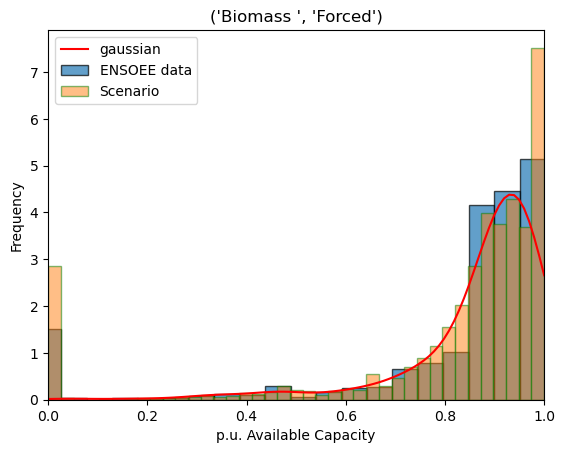

miao plotting
miao plotting2
miao plotting3


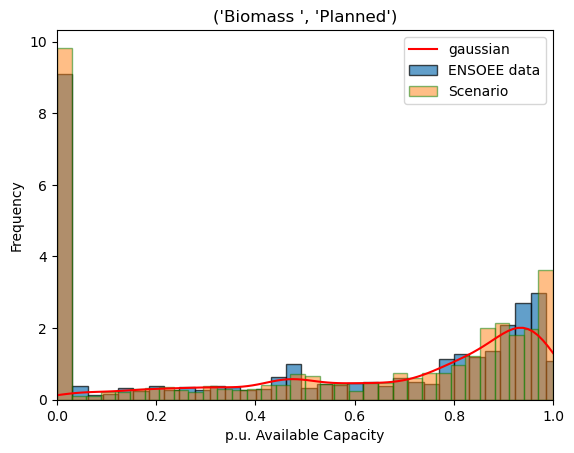

miao plotting
miao plotting2
miao plotting3


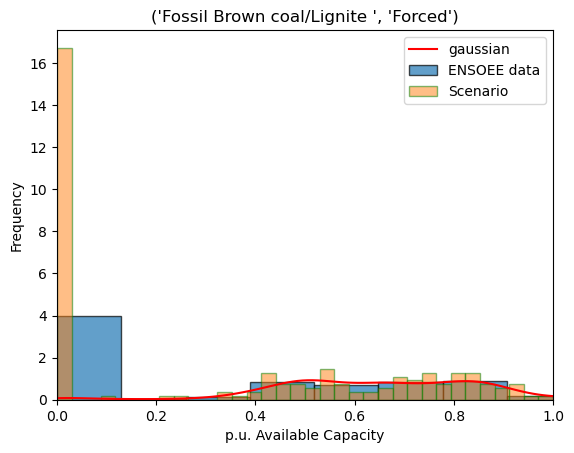

miao plotting
miao plotting2
miao plotting3


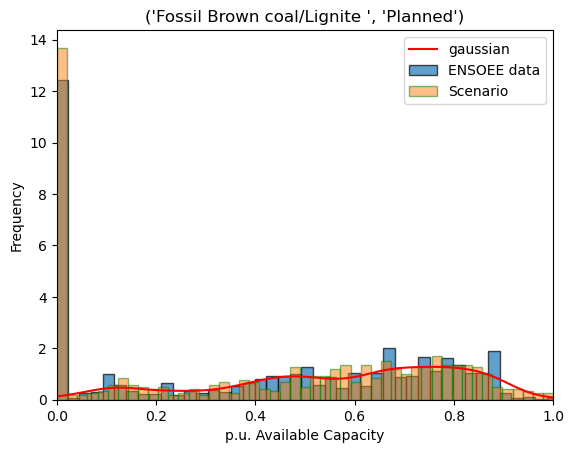

miao plotting
miao plotting2
miao plotting3


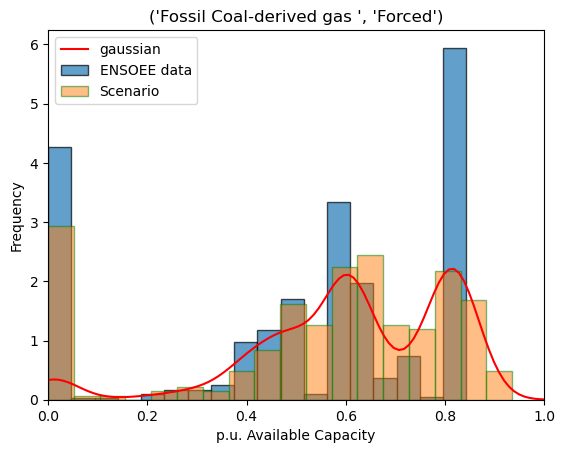

miao plotting
miao plotting2
miao plotting3


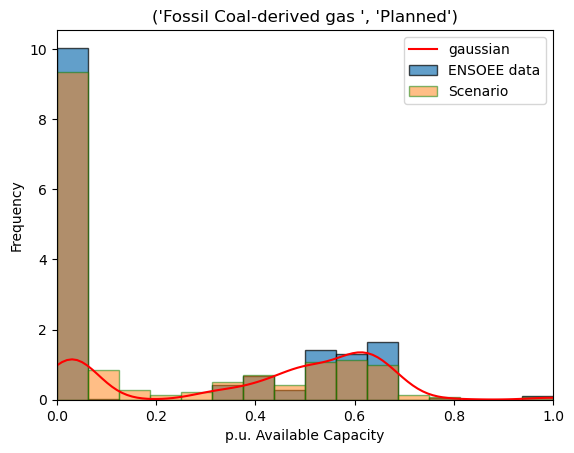

miao plotting
miao plotting2
miao plotting3


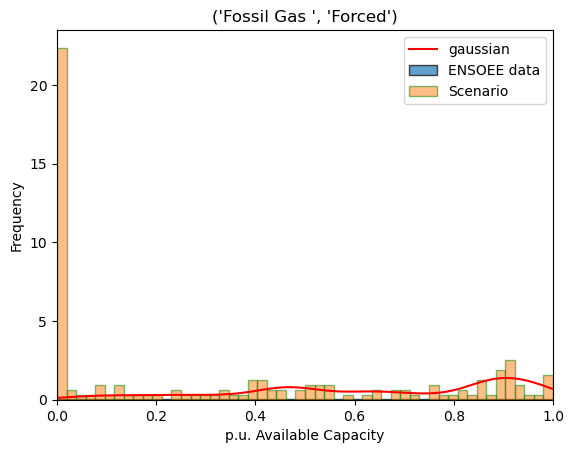

miao plotting
miao plotting2
miao plotting3


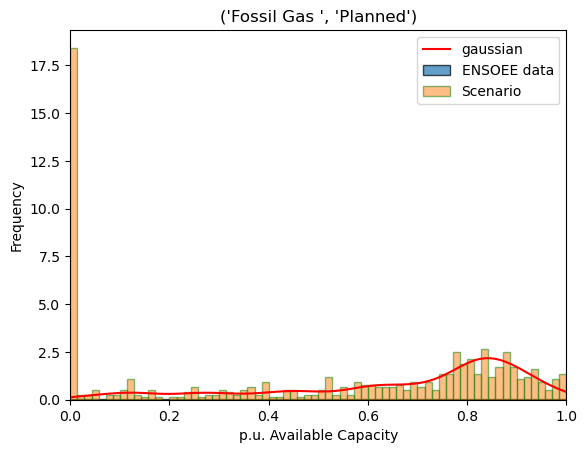

miao plotting
miao plotting2
miao plotting3


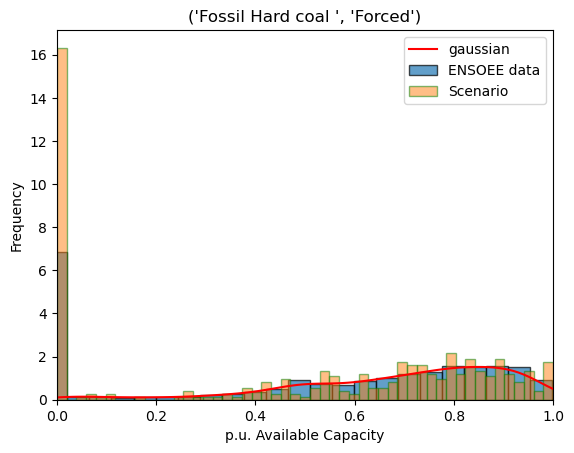

miao plotting
miao plotting2
miao plotting3


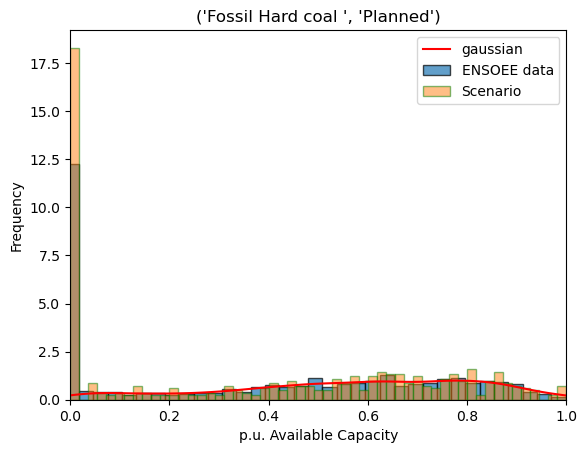

miao plotting
miao plotting2
miao plotting3


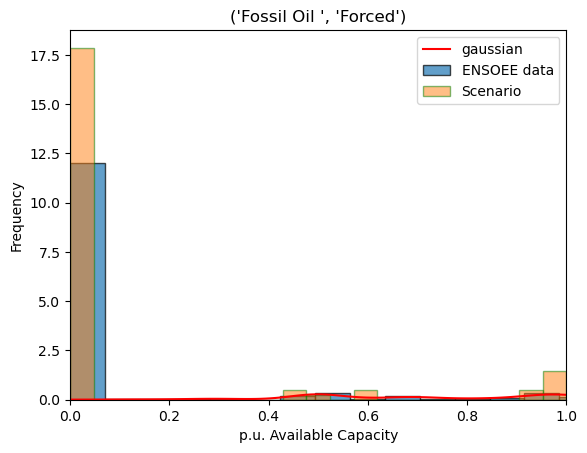

miao plotting
miao plotting2
miao plotting3


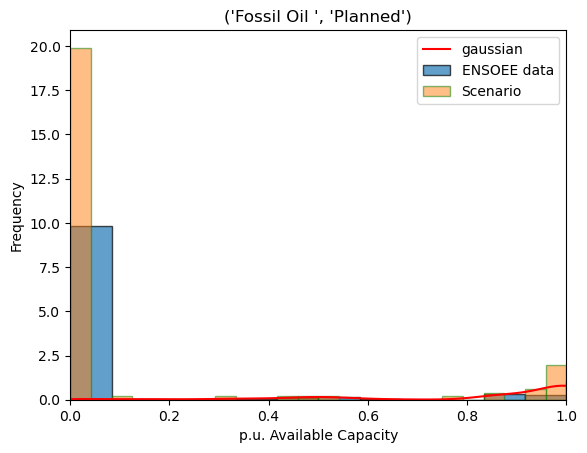

miao plotting
miao plotting2
miao plotting3


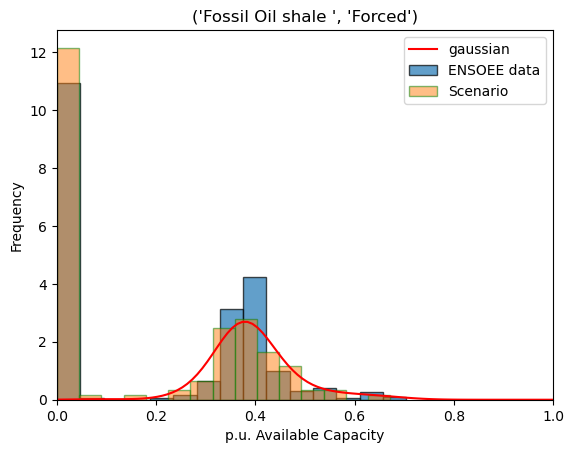

miao plotting
miao plotting2
miao plotting3


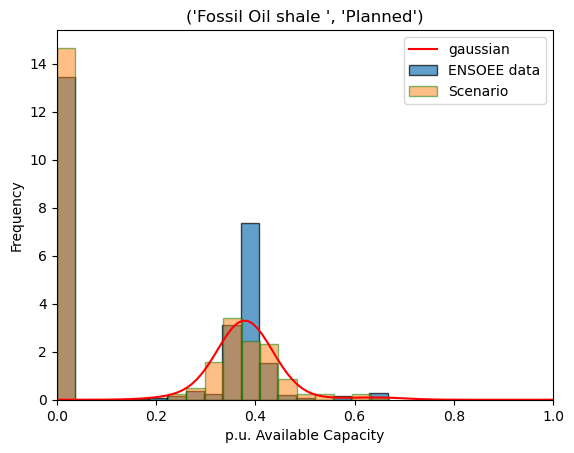

miao plotting
miao plotting2
miao plotting3


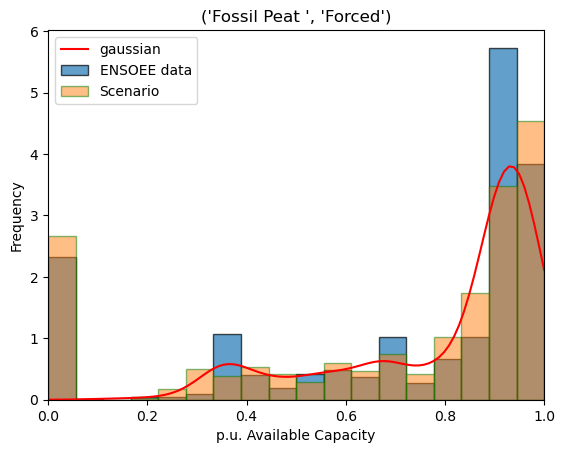

miao plotting
miao plotting2
miao plotting3


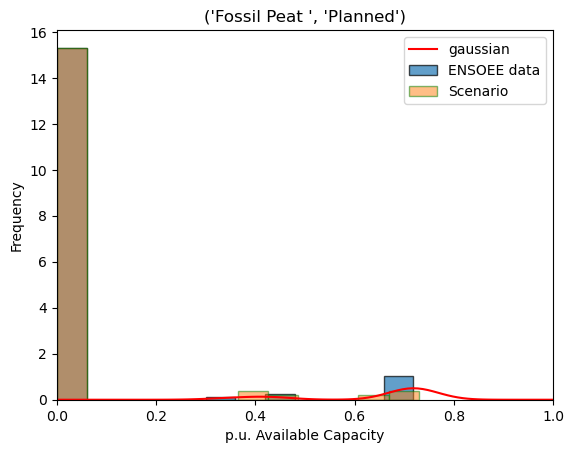

miao plotting
miao plotting2
miao plotting3


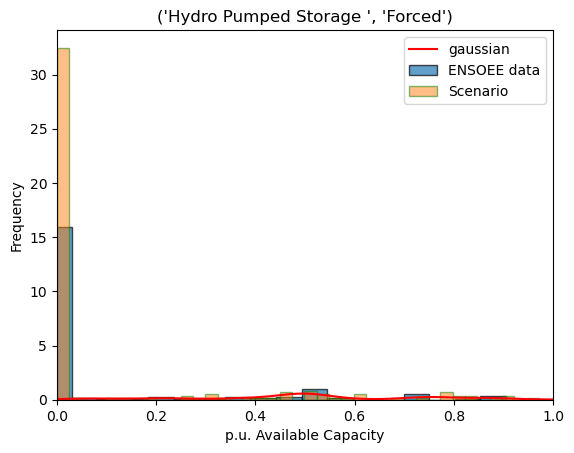

miao plotting
miao plotting2
miao plotting3


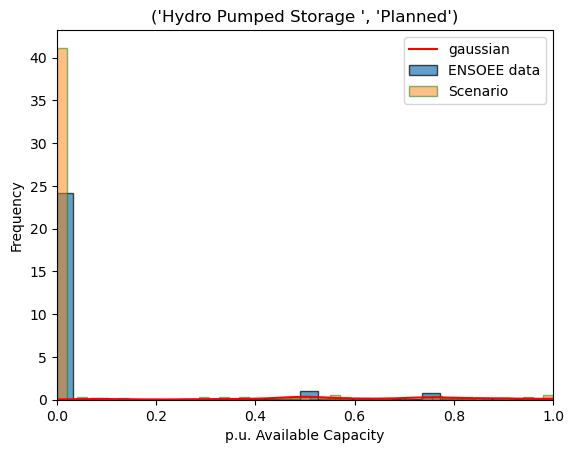

miao plotting
miao plotting2
miao plotting3


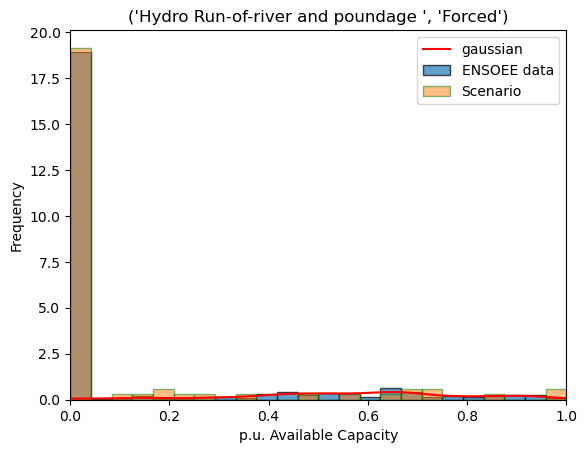

miao plotting
miao plotting2
miao plotting3


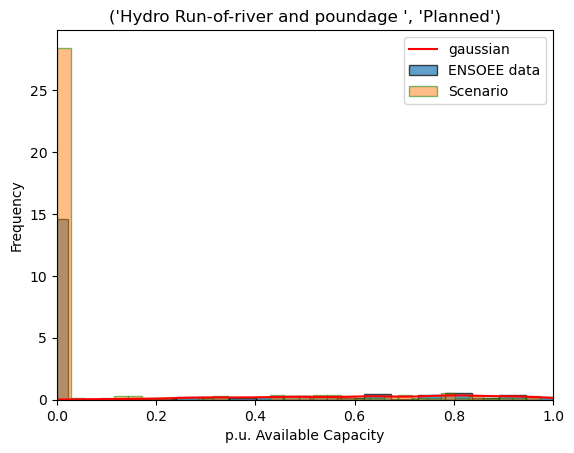

miao plotting
miao plotting2
miao plotting3


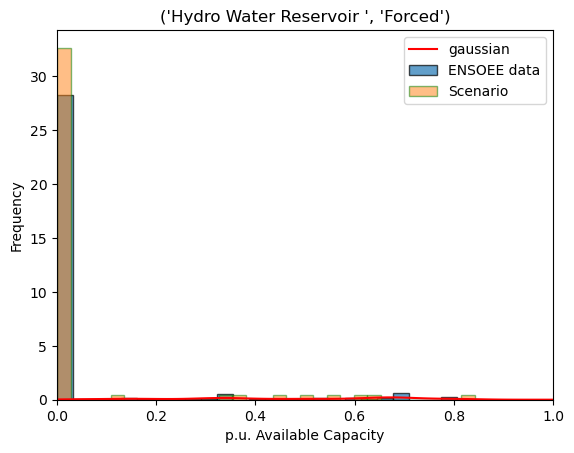

miao plotting
miao plotting2
miao plotting3


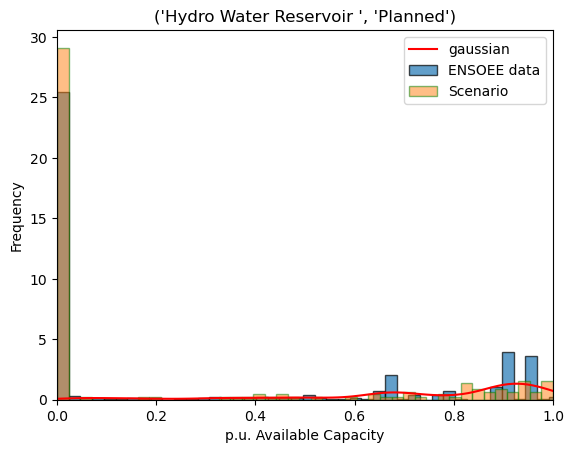

miao plotting
miao plotting2
miao plotting3


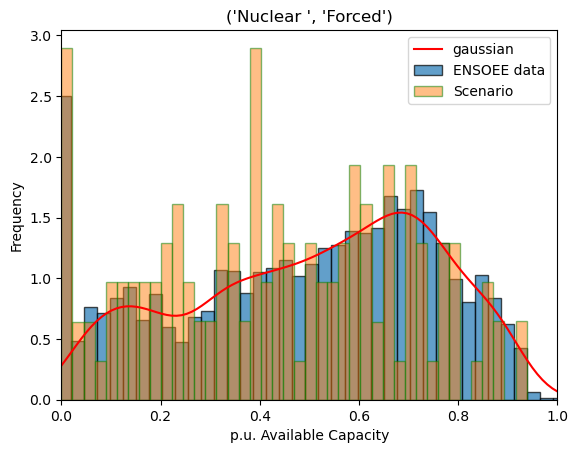

miao plotting
miao plotting2
miao plotting3


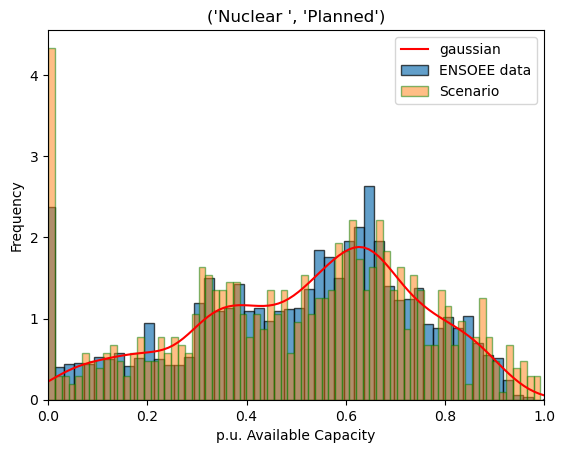

miao plotting
miao plotting2
miao plotting3


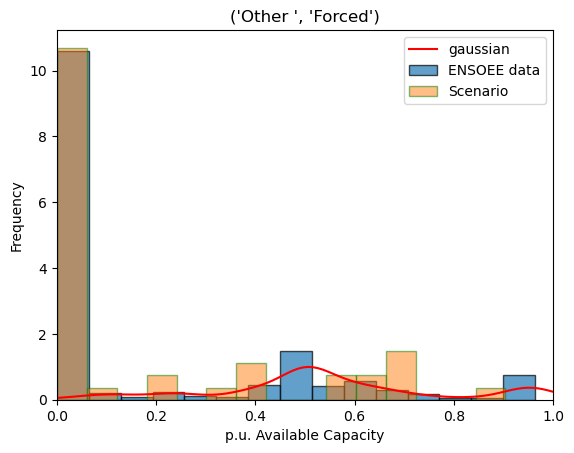

miao plotting
miao plotting2
miao plotting3


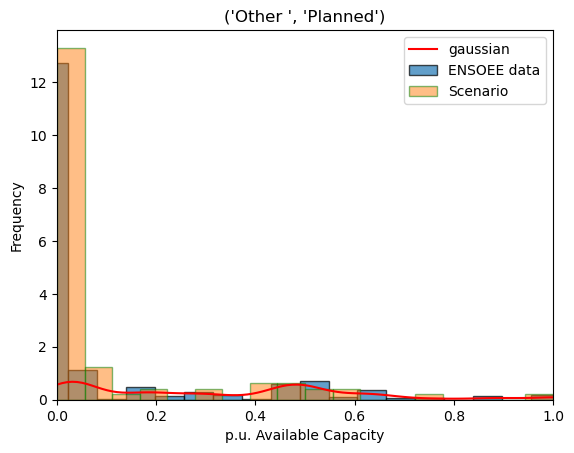

miao plotting
miao plotting2
miao plotting3


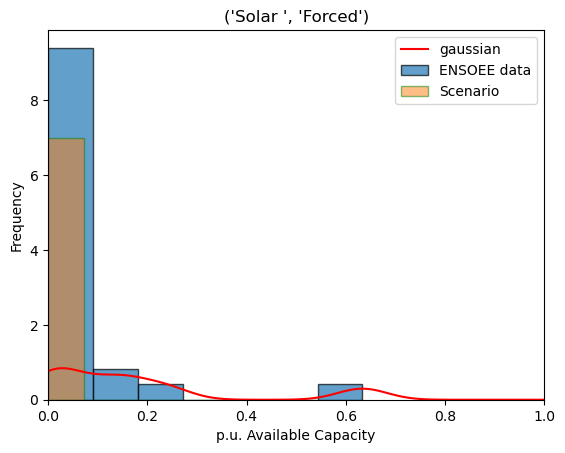

miao plotting
miao plotting2
miao plotting3


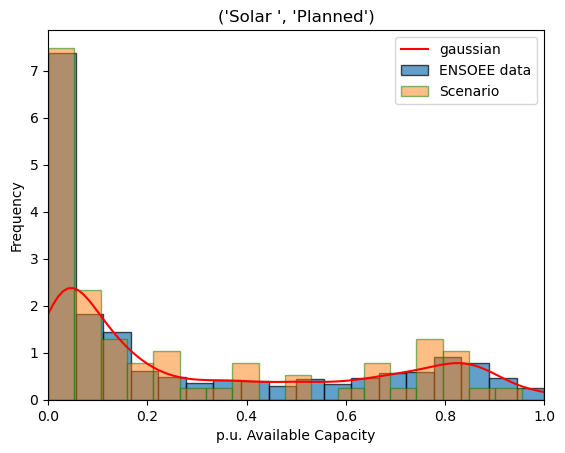

miao plotting
miao plotting2
miao plotting3


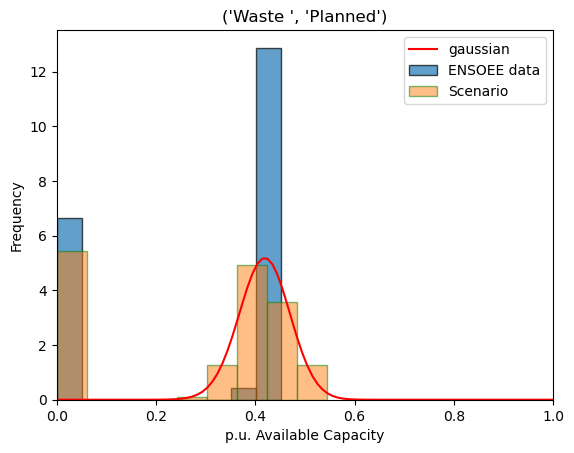

miao plotting
miao plotting2
miao plotting3


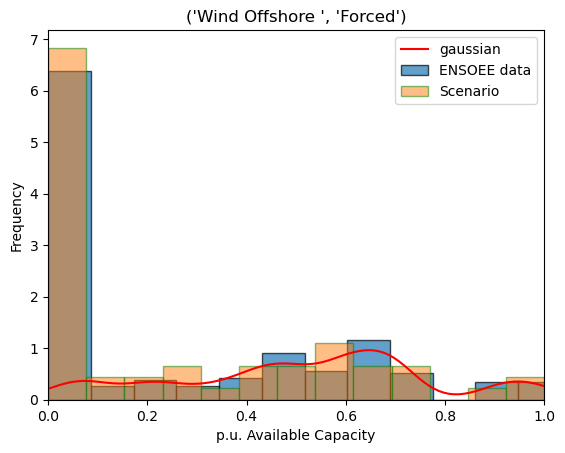

miao plotting
miao plotting2
miao plotting3


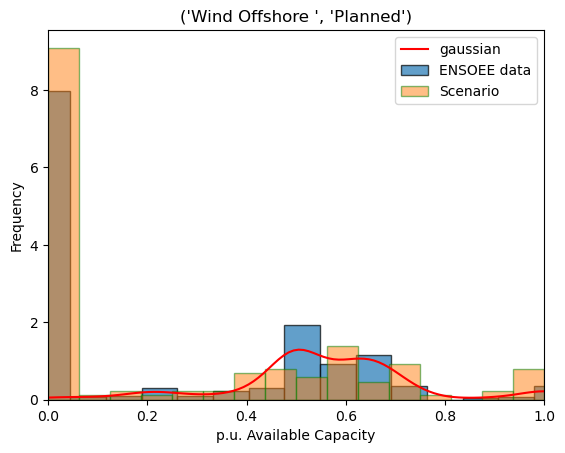

miao plotting
miao plotting2
miao plotting3


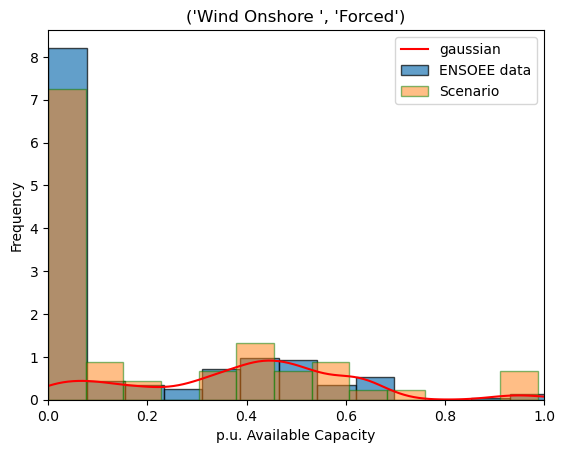

miao plotting
miao plotting2
miao plotting3


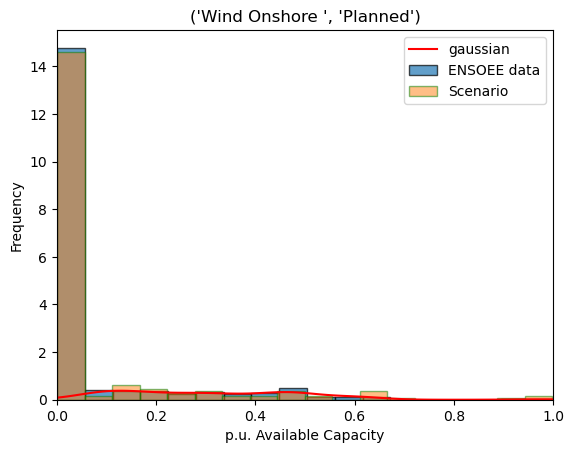

In [86]:
#confront plots with scenario

#With Kernel density estimation
grouped_df = df.groupby(["ProductionType", "Type"])
#idea: calculate prob for capacity = 0, remove and the use non parametric fit.
X = np.linspace(0,1,100)
for production_type, prod_df in grouped_df:
    #calculate per unit available capacity
    gen_type, state = production_type
    PU = prod_df["AvailableCapacity"] / prod_df["InstalledCapacity"]
    PU = PU[~np.isnan(PU)]
    PUplus = PU[PU != 0]
    
    if len(PUplus) != 0:
        scenario_df = gen_types_scenarios[gen_type] #get big scenario
        state_df = scenario_df[scenario_df["Type"] == state]
        
        plt.figure() 
        p_0, kde = pdf_pu[production_type]
        
        
        #plot distribution density of capacity
        log_dens = kde.score_samples(X[:, np.newaxis]) 
        Y = np.exp(log_dens) * len(PUplus) / len(PU) #scale to be prob on non zero values
        plt.plot(X, Y, color = "r", label = kernel)
        
        # Plot ENSOEE histogram
        print("miao plotting")
        plt.xlim(0, 1)
        print("miao plotting2")
        n_bins = min(500, int(np.ceil(len(PU) ** (1. / 3))*3/2)) + 3
        plt.hist(PU, bins= n_bins , edgecolor='black', alpha=0.7, density = True, label= "ENSOEE data")
        print("miao plotting3")
        # Plot Scenairo histogram
        plt.hist(state_df["AvailableCapacity"], alpha = 0.5, bins=n_bins,  edgecolor = "green", density = True, label = "Scenario")
        # Customize the plot (add labels, title, etc.)
        plt.xlabel('p.u. Available Capacity')
        plt.ylabel('Frequency')
        plt.title(f'{production_type}')
        plt.legend()
        plt.show()

In [70]:
#state_df["AvailableCapacity"]
scenario_df

StartTS               EndTS     Type       AvailableCapacity  \
0   2023-01-01 00:00:00 2023-01-02 21:00:00  Planned  [[0.6525037452651291]]   
1   2023-01-02 21:00:00 2023-01-10 22:00:00  Running                       1   
2   2023-01-10 22:00:00 2023-01-18 08:00:00  Planned                       0   
3   2023-01-18 08:00:00 2023-02-11 23:00:00  Running                       1   
4   2023-02-11 23:00:00 2023-02-28 04:00:00  Planned                       0   
..                  ...                 ...      ...                     ...   
273 2030-03-01 01:00:00 2030-03-21 06:00:00  Running                       1   
274 2030-03-21 06:00:00 2030-03-26 21:00:00  Planned                       0   
275 2030-03-26 21:00:00 2030-04-29 14:00:00  Running                       1   
276 2030-04-29 14:00:00 2030-05-04 05:00:00   Forced  [[0.8137699225320676]]   
277 2030-05-04 05:00:00 2030-06-01 02:00:00  Running                       1   

     StateTime  
0         45.0  
1        193.0  
2        178.0  
3        591.0  
4        389.0  
..         ...  
273      485.0  
274      135.0  
275      809.0  
276      111.0  
277      669.0  

[278 rows x 5 columns]

In [24]:
df

StartTS               EndTS TimeZone     Status     Type  \
0      2021-07-14 09:00:00 2021-07-14 10:00:00      CET     Active   Forced   
1      2021-07-14 11:00:00 2021-07-14 23:59:00      CET     Active   Forced   
2      2021-07-15 15:00:00 2021-10-01 00:00:00      CET     Active   Forced   
4      2021-10-01 01:00:00 2021-10-01 01:34:00      CET     Active   Forced   
6      2021-10-05 16:38:00 2021-10-05 22:00:00      CET     Active   Forced   
...                    ...                 ...      ...        ...      ...   
573766 2021-08-23 03:37:00 2021-08-23 04:01:00      CET     Active   Forced   
573767 2021-09-13 00:00:00 2021-09-14 00:00:00      CET  Cancelled  Planned   
573769 2021-09-15 00:00:00 2021-09-16 00:00:00      CET  Cancelled  Planned   
573771 2021-09-17 00:00:00 2021-09-18 00:00:00      CET  Cancelled  Planned   
573772 2022-06-19 00:00:00 2022-07-10 00:00:00      CET     Active  Planned   

                AreaCode AreaTypeCode AreaName MapCode  PowerResourceEIC  \
0       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
1       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
2       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
4       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
6       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
...                  ...          ...      ...     ...               ...   
573766  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573767  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573769  10YHU-MAVIR----U          BZN   HU BZN      HU  15WUJPESTG2--STI   
573771  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573772  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   

       UnitName     ProductionType  InstalledCapacity  AvailableCapacity  \
0       ABO¿O 1  Fossil Hard coal               341.7              230.0   
1       ABO¿O 1  Fossil Hard coal               341.7              220.0   
2       ABO¿O 1  Fossil Hard coal               341.7                0.0   
4       ABO¿O 1  Fossil Hard coal               341.7              210.0   
6       ABO¿O 1  Fossil Hard coal               341.7              240.0   
...         ...                ...                ...                ...   
573766    ÚJ_ST        Fossil Gas                33.0               -1.0   
573767    ÚJ_ST        Fossil Gas                33.0                0.0   
573769    ÚJ_ST        Fossil Gas                33.0                0.0   
573771    ÚJ_ST        Fossil Gas                33.0                0.0   
573772    ÚJ_ST        Fossil Gas                33.0                0.0   

        Version                     Reason             UpTime   ForcedTime  \
0             1                    Failure                NaN     1.000000   
1             7                    Failure    0 days 02:00:00    12.983333   
2             5                    Failure    1 days 04:00:00  1857.000000   
4             1  Complementary Information    0 days 01:00:00     0.566667   
6             1                    Failure    4 days 15:04:00     5.366667   
...         ...                        ...                ...          ...   
573766        2                    Failure   15 days 03:37:00     0.400000   
573767        2       Foreseen Maintenance   20 days 20:23:00          NaN   
573769        2       Foreseen Maintenance    1 days 00:00:00          NaN   
573771        2       Foreseen Maintenance    1 days 00:00:00          NaN   
573772        1       Foreseen Maintenance  275 days 00:00:00          NaN   

        PlannedTime  RunningTime  
0               NaN          NaN  
1               NaN     1.000000  
2               NaN    15.016667  
4               NaN     1.000000  
6               NaN   111.066667  
...             ...          ...  
573766          NaN   339.616667  
573767         24.0   499.9


# Other Data Analysis





### Maintenance modeling
In this section we look at the distribution of the maintenance for each generator.

Conclusion:
There seem to be some regularity in some of the generators but it's not clear to me how we could model it

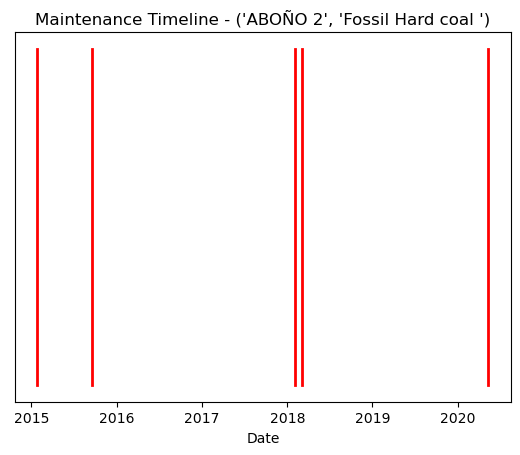

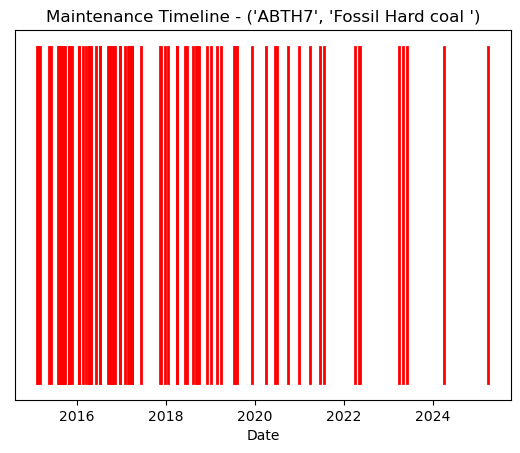

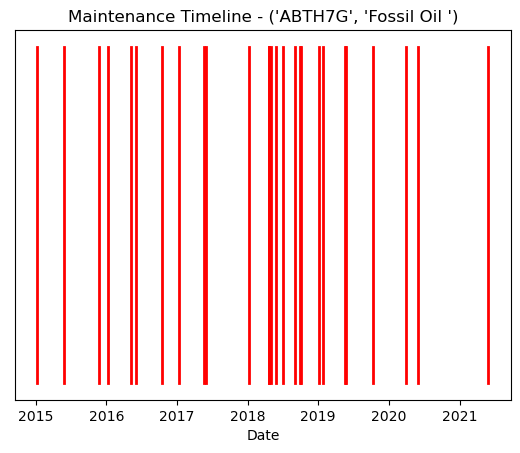

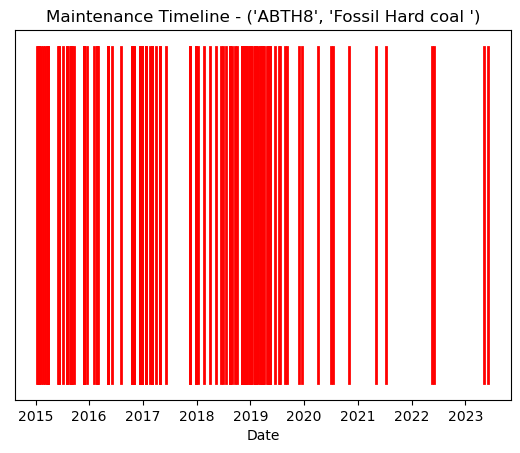

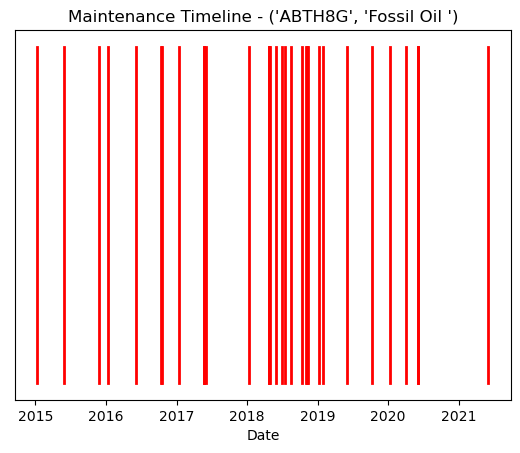

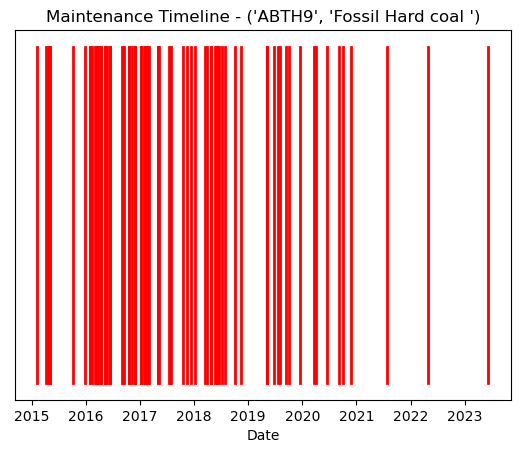

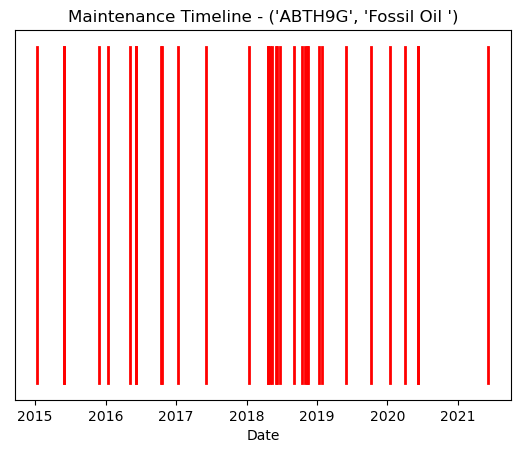

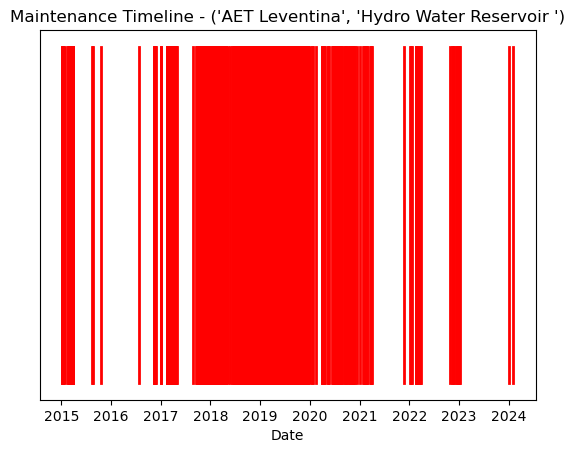

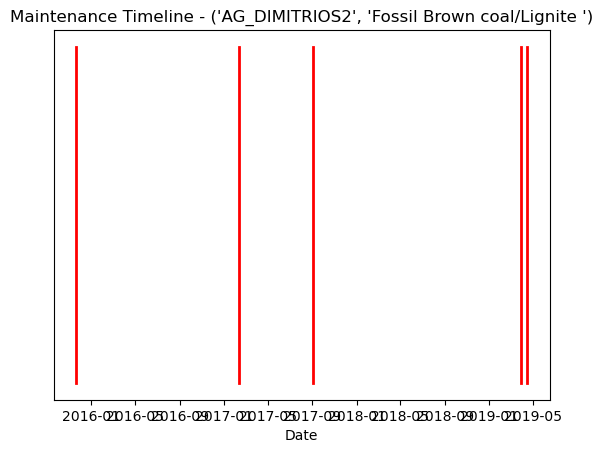

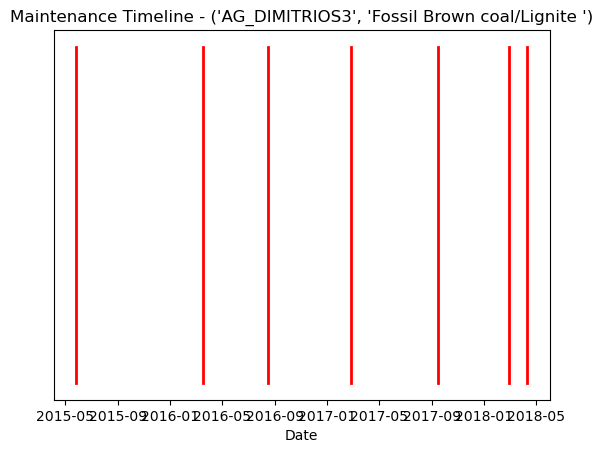

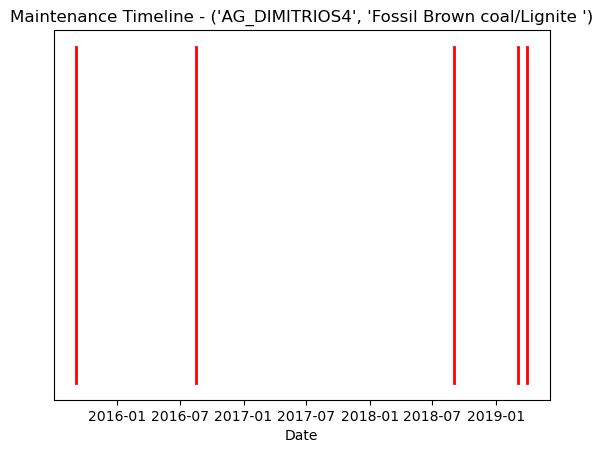

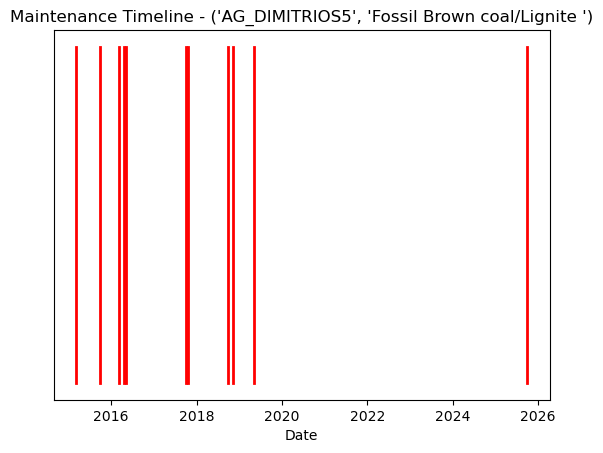

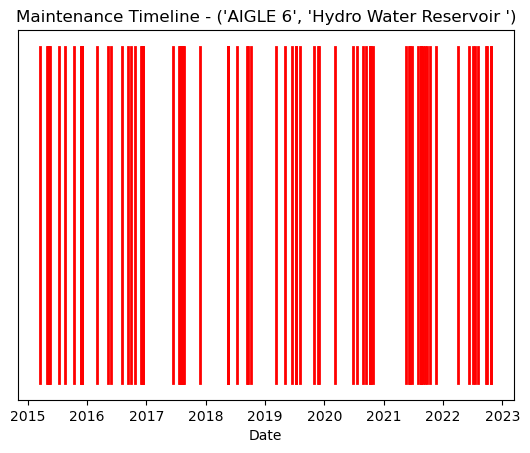

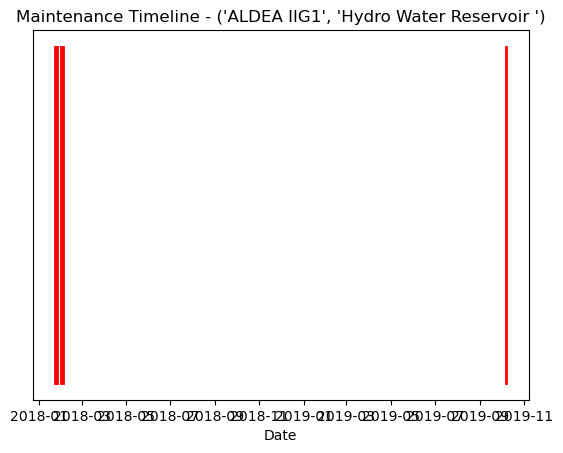

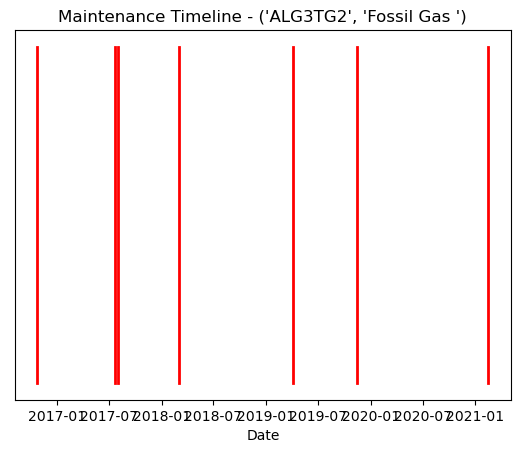

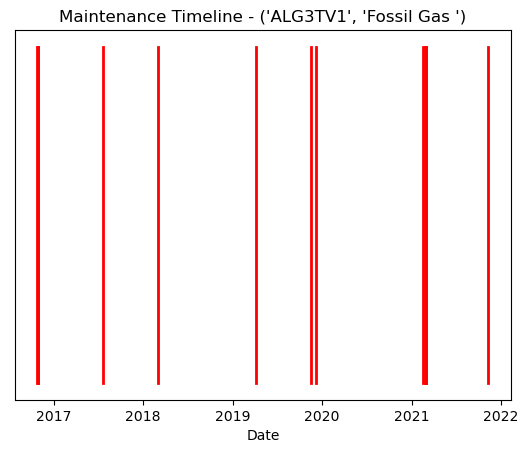

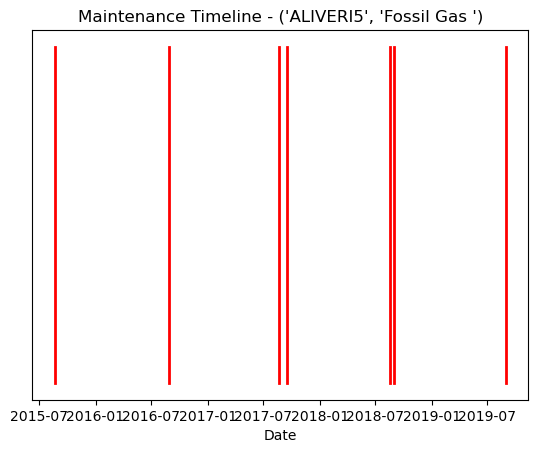

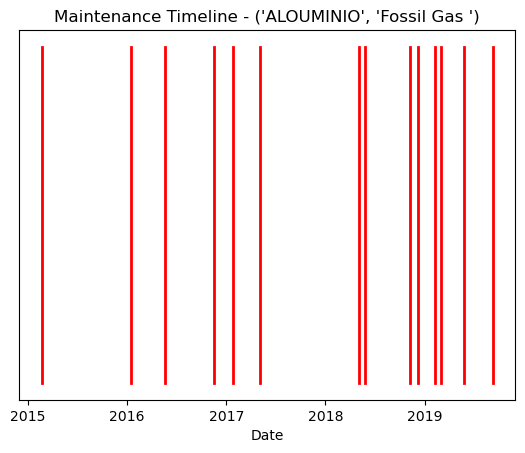

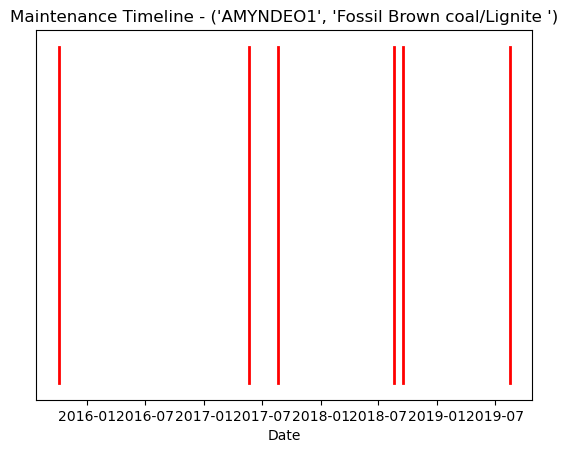

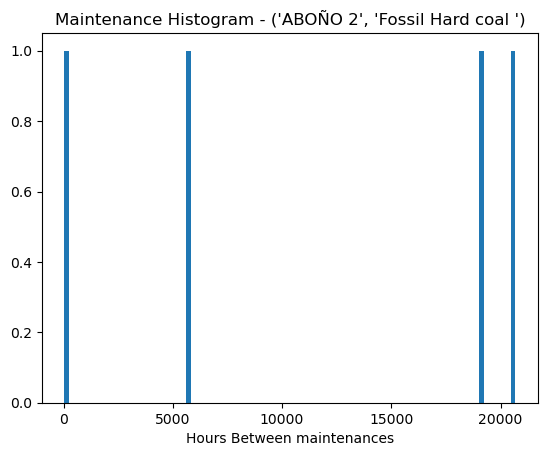

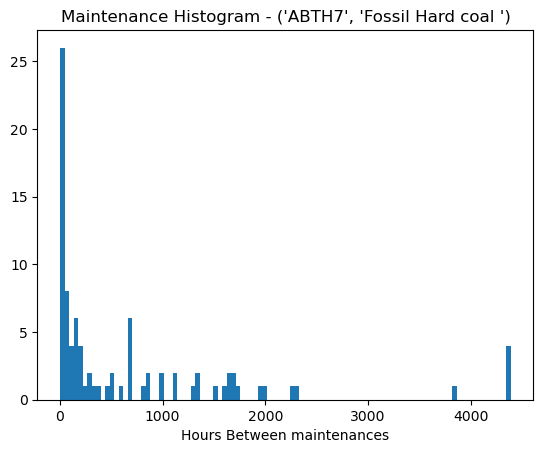

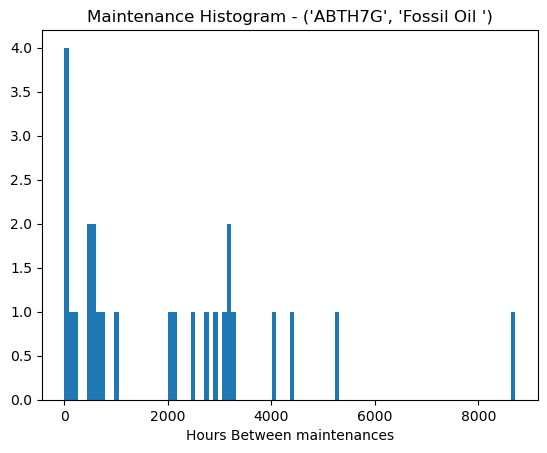

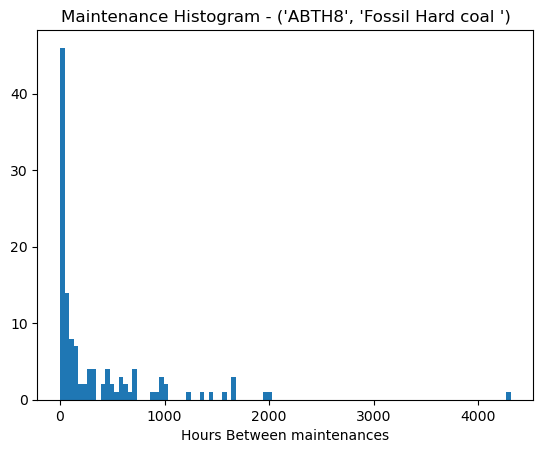

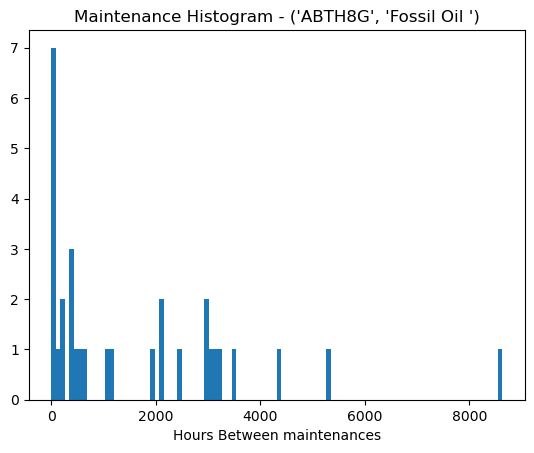

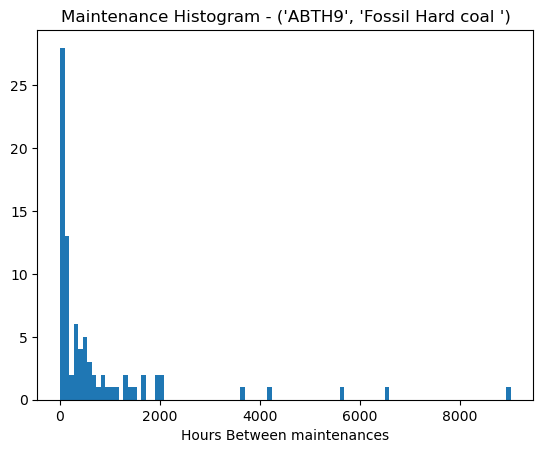

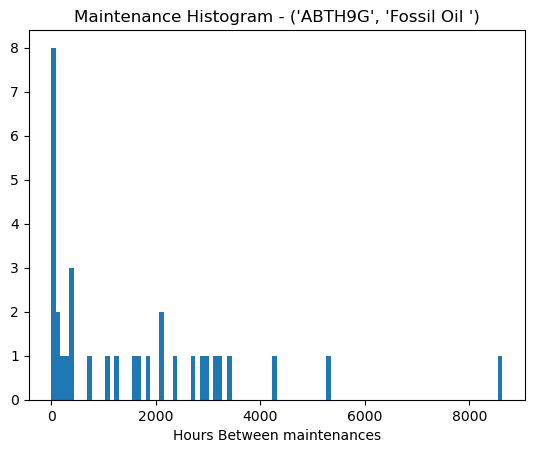

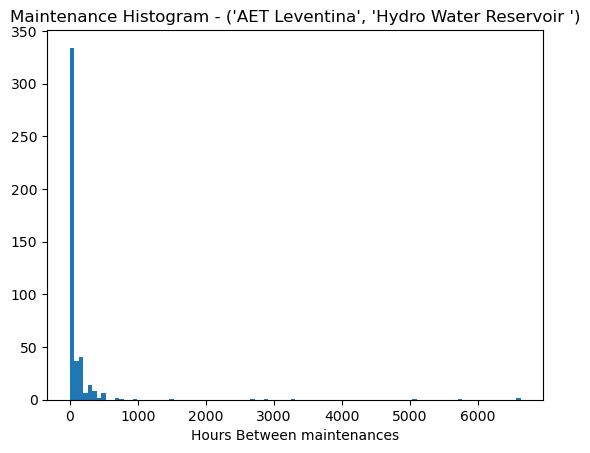

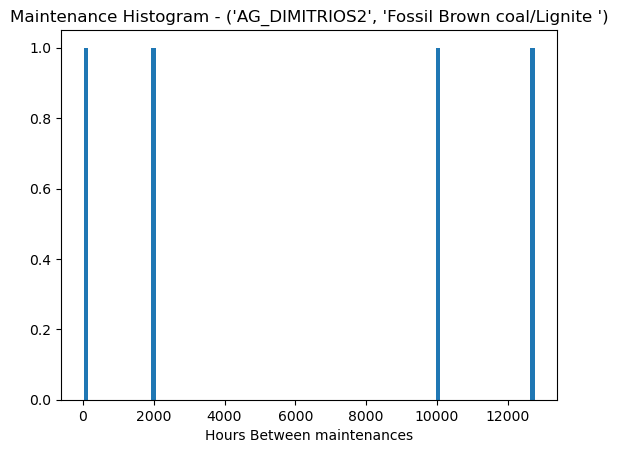

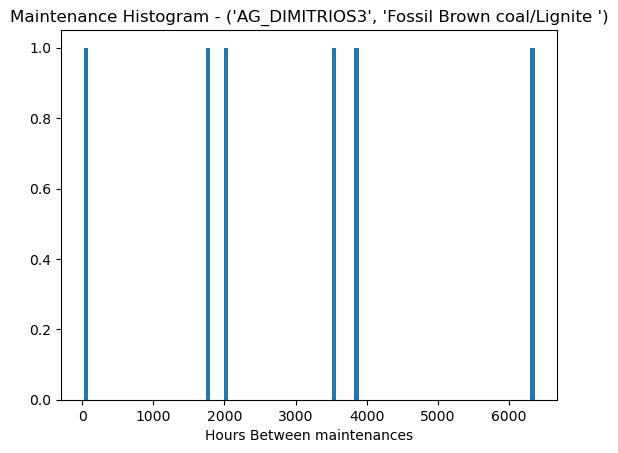

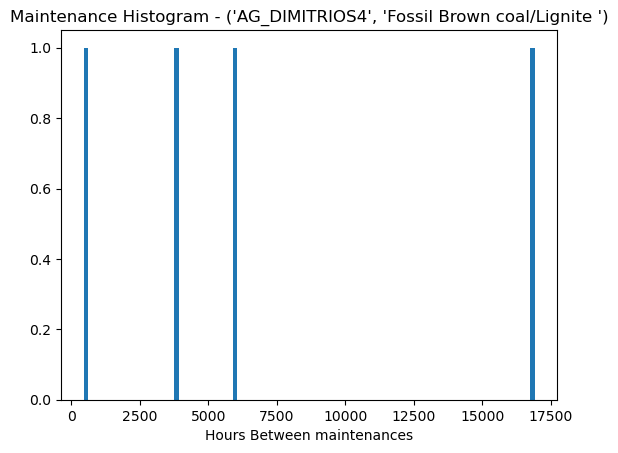

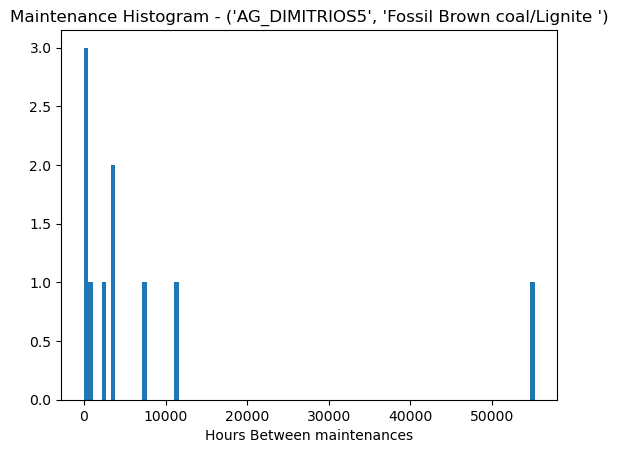

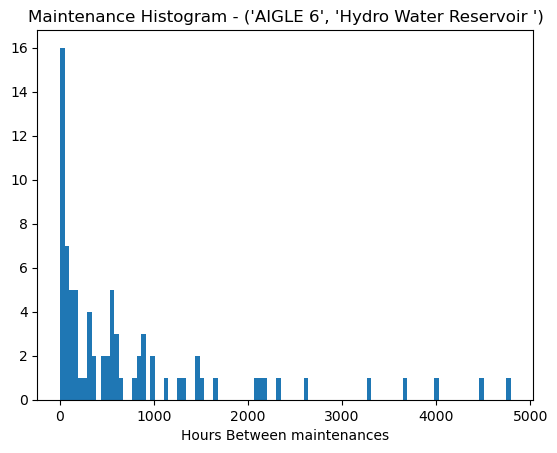

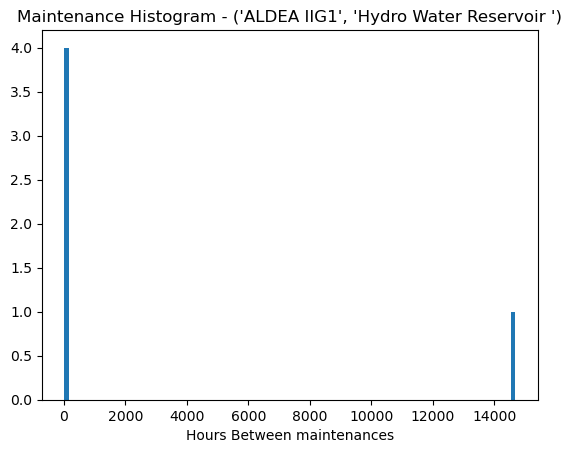

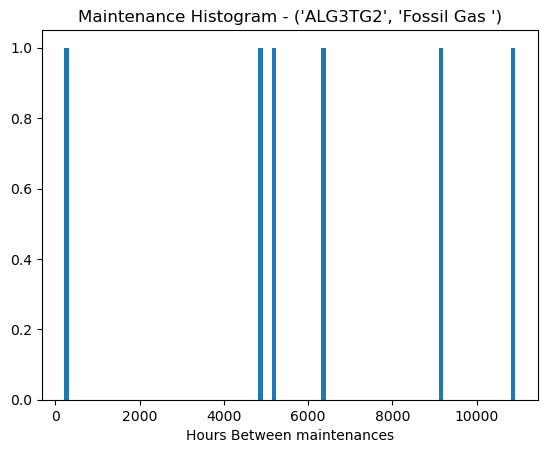

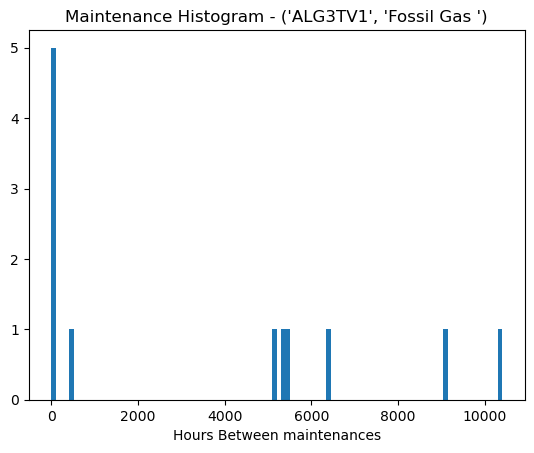

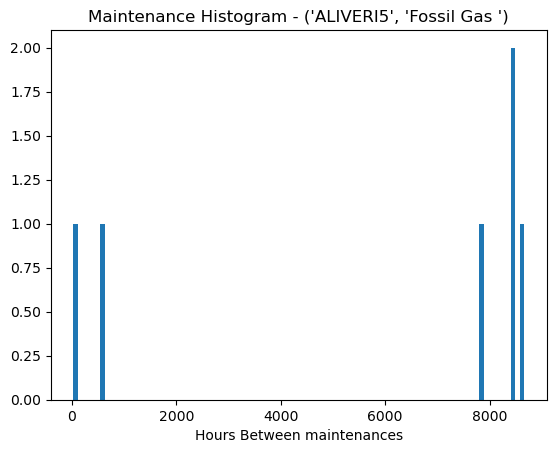

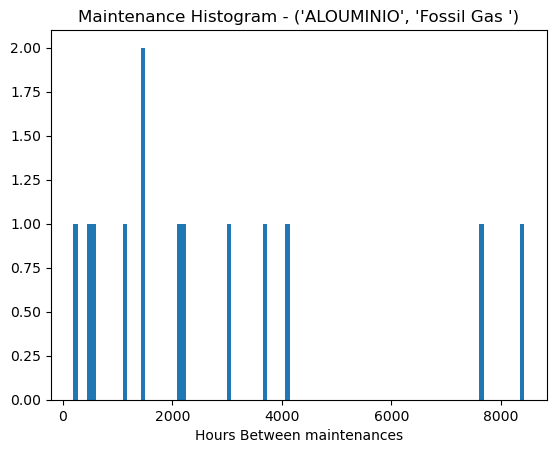

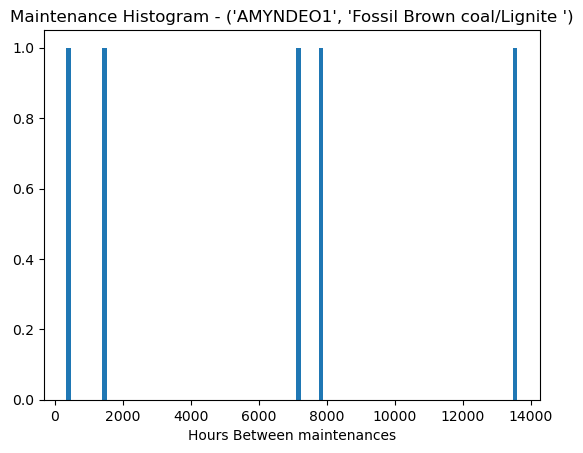

In [37]:
maintenance_df = df[df["Reason"] == "Foreseen Maintenance"].sort_values(by = ["UnitName","StartTS"])
#maintenance_df["Delta Maintenance"] = maintenance_df.groupby("UnitName")["StartTS"].diff() 
# time passed from the previous maintenance

for unit, unit_df in maintenance_df.groupby("UnitName"):
    shifted_endts = unit_df["EndTS"][:-1]
    start_ts = unit_df["StartTS"][1:]
    maintenance_df.loc[maintenance_df["UnitName"] == unit, "UpTime"] = np.array(start_ts) - shifted_endts
    
    
maintenance_df = maintenance_df.groupby("UnitName").filter(lambda x: len(x) > 4).reset_index() #take only generators with enough maintenance to see a pattern

k = 0
for unit_name , group_df in maintenance_df.groupby(["UnitName"]):
    unit_type = group_df["ProductionType"].iloc[0]
    plotted_types = []
    if k < 19 and unit_type not in plotted_types:
        
        plotted_types.append(unit_type)
        k = k+1
        plt.figure()  # Create a new figure for each UnitName
        for index, row in group_df.iterrows():
            plt.plot([row['StartTS'], row['StartTS']], [0, 1], color='red', linewidth=2)  # Adjust [0, 1] to set the height of the spike

            
        # Customize the plot
        plt.yticks([])  # Hide y-axis ticks
        plt.xlabel('Date')
        plt.title(f'Maintenance Timeline - {unit_name, unit_type}')
        plt.show()
        
k = 0
for unit_name, group_df in maintenance_df.groupby(["UnitName"]):
    unit_type = group_df["ProductionType"].iloc[0]
    plotted_types = []
    if k < 19 and unit_type not in plotted_types:
        k += 1
        y = group_df["UpTime"] / np.timedelta64(1,"h")
        plt.hist(y, bins = 100)
        plt.xlabel('Hours Between maintenances')
        plt.title(f'Maintenance Histogram - {unit_name, unit_type}')
        plt.show()

In [ ]:
#With Kernel density estimation
grouped_df = df.groupby(["ProductionType", "Type"])
#idea: calculate prob for capacity = 0, remove and the use non parametric fit.
for production_type, prod_df in grouped_df:
    #calculate per unit available capacity
    PU = prod_df["AvailableCapacity"] / prod_df["InstalledCapacity"]
    df.loc[(df["ProductionType"] == production_type[0]) & (df["Type"] == production_type[1]), "p.u."] = PU
    PU = PU[~np.isnan(PU)]
    p_0 = np.sum(PU == 0) / len(PU)
    PUplus = np.sort(PU[PU != 0]) #non zero capacities
    if len(PUplus) != 0:
        
        colors = ["r", "b", "g"]
        kernels = ["gaussian", "tophat", "epanechnikov"]
        lw = 2
        plt.figure()
        for color, kernel in zip(colors, kernels):
            kde = KernelDensity(kernel=kernel, bandwidth=0.05).fit(PUplus[:, np.newaxis])
            log_dens = kde.score_samples(PUplus[:, np.newaxis]) * len(PUplus) / len(PU) #scale to be prob on non zero values
            Y = np.exp(log_dens)
            plt.plot(PUplus, Y, color = color, label = kernel)
            
    
        # Plot histogram

        plt.xlim(0, 1)
        
        plt.hist(PU, bins=min(500, int(np.ceil(len(PU) ** (1. / 3))*3/2)) + 3 , edgecolor='black', alpha=0.7, density = True)

        # Customize the plot (add labels, title, etc.)
        plt.xlabel('p.u. Available Capacity')
        plt.ylabel('Frequency')
        plt.title(f'{production_type}')
        plt.legend()
        plt.show()

# Principal component analysis
We select the two most representative axes to see whether the are some obvious correlations between the data we are trying to generate:Questions:
- Is capacity in a certain state correlated with the time spent in that state?
- Notice other correlation which may make us want to model various groups singularly





[0.23852853 0.2042014  0.19726167 0.18848347 0.17152493]
[   1.63774903 -170.7173597 ]
[-143.10091898   44.63514041]
[-33.17442063 145.65138928]
[112.58790758  67.92235321]
[152.7837218   25.20940441]


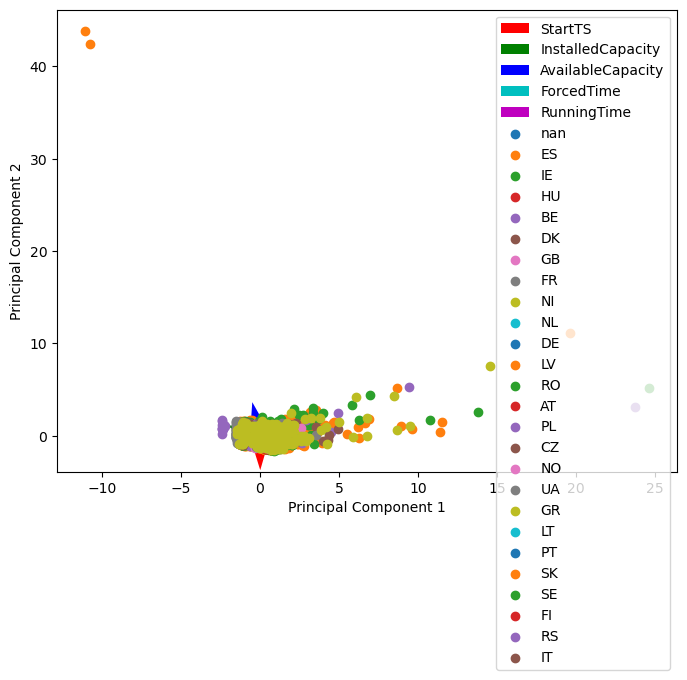

In [37]:
gen_type = "Fossil Gas "
reason = "Forced"
#startTS to hour number
features = ["StartTS", "InstalledCapacity", "AvailableCapacity", reason+"Time", "RunningTime"]
columns = features + ["MapCode"]
failure_df = delta_df.loc[(delta_df["Type"] == reason) & (delta_df["ProductionType"] == gen_type), columns]
failure_df["StartTS"] = failure_df["StartTS"].dt.hour + (failure_df["StartTS"].dt.dayofyear - 1) * 24

# Step 1: Generate the identity matrix
n_features = len(features)  # Replace with the actual number of features
identity_matrix = np.eye(n_features)

#conversion to p.u.
failure_df.loc[:,"AvailableCapacity"] = failure_df.loc[:,"AvailableCapacity"] / failure_df.loc[:,"InstalledCapacity"] 
df1 = failure_df.dropna().copy()
df["MapCode"] = df1["MapCode"].apply(lambda x: x[0:2]) #transform countries regions to country
# def pca(table, variable_names)

# Step 1: Preprocessing
x = df.loc[:, features].values  # Separating out the features
x = StandardScaler().fit_transform(x)  # Standardizing the features

# Step 2: PCA
pca = PCA()  # You can choose the number of components
principalComponents = pca.fit_transform(x)[:,:2]
reduced_variables = pca.components_[0:2,:]*240
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])  # Creating a new DataFrame with the principal components

# Step 3: Plotting

explained_var = pca.explained_variance_ratio_
print(explained_var)
finalDf = pd.concat([principalDf, df[['MapCode']]], axis=1)  # Adding country column to the principal components DataFrame

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)  # For 3D plot

colors = ["r","g","b","c","m"]
countries = finalDf['MapCode'].unique()  # Get unique country names
for i in np.arange(n_features):
    print(reduced_variables[:2, i])
    ax.quiver(0,0,reduced_variables[0, i], reduced_variables[1, i], color=colors[i], label=f'{features[i]}')

for country in countries:
    indicesToKeep = finalDf['MapCode'] == country
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], label=country)
    
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()
plt.show()




In [44]:
delta_df

StartTS               EndTS TimeZone     Status     Type  \
0      2021-07-14 09:00:00 2021-07-14 10:00:00      CET     Active   Forced   
1      2021-07-14 11:00:00 2021-07-14 23:59:00      CET     Active   Forced   
2      2021-07-15 15:00:00 2021-10-01 00:00:00      CET     Active   Forced   
4      2021-10-01 01:00:00 2021-10-01 01:34:00      CET     Active   Forced   
6      2021-10-05 16:38:00 2021-10-05 22:00:00      CET     Active   Forced   
...                    ...                 ...      ...        ...      ...   
573766 2021-08-23 03:37:00 2021-08-23 04:01:00      CET     Active   Forced   
573767 2021-09-13 00:00:00 2021-09-14 00:00:00      CET  Cancelled  Planned   
573769 2021-09-15 00:00:00 2021-09-16 00:00:00      CET  Cancelled  Planned   
573771 2021-09-17 00:00:00 2021-09-18 00:00:00      CET  Cancelled  Planned   
573772 2022-06-19 00:00:00 2022-07-10 00:00:00      CET     Active  Planned   

                AreaCode AreaTypeCode AreaName MapCode  PowerResourceEIC  \
0       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
1       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
2       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
4       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
6       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
...                  ...          ...      ...     ...               ...   
573766  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573767  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573769  10YHU-MAVIR----U          BZN   HU BZN      HU  15WUJPESTG2--STI   
573771  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573772  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   

       UnitName     ProductionType  InstalledCapacity  AvailableCapacity  \
0       ABO¿O 1  Fossil Hard coal               341.7              230.0   
1       ABO¿O 1  Fossil Hard coal               341.7              220.0   
2       ABO¿O 1  Fossil Hard coal               341.7                0.0   
4       ABO¿O 1  Fossil Hard coal               341.7              210.0   
6       ABO¿O 1  Fossil Hard coal               341.7              240.0   
...         ...                ...                ...                ...   
573766    ÚJ_ST        Fossil Gas                33.0               -1.0   
573767    ÚJ_ST        Fossil Gas                33.0                0.0   
573769    ÚJ_ST        Fossil Gas                33.0                0.0   
573771    ÚJ_ST        Fossil Gas                33.0                0.0   
573772    ÚJ_ST        Fossil Gas                33.0                0.0   

        Version                     Reason             UpTime   ForcedTime  \
0             1                    Failure                NaN     1.000000   
1             7                    Failure    0 days 02:00:00    12.983333   
2             5                    Failure    1 days 04:00:00  1857.000000   
4             1  Complementary Information    0 days 01:00:00     0.566667   
6             1                    Failure    4 days 15:04:00     5.366667   
...         ...                        ...                ...          ...   
573766        2                    Failure   15 days 03:37:00     0.400000   
573767        2       Foreseen Maintenance   20 days 20:23:00          NaN   
573769        2       Foreseen Maintenance    1 days 00:00:00          NaN   
573771        2       Foreseen Maintenance    1 days 00:00:00          NaN   
573772        1       Foreseen Maintenance  275 days 00:00:00          NaN   

        PlannedTime  RunningTime  
0               NaN          NaN  
1               NaN     1.000000  
2               NaN    15.016667  
4               NaN     1.000000  
6               NaN   111.066667  
...             ...          ...  
573766          NaN   339.616667  
573767         24.0   499.9

[0.25956769 0.20427233 0.19414815]
[ 0.9270171  -6.5896962   6.01804774]
[-3.78914996  3.73823068  4.83865791]
[-4.94881259 -1.34593771 -1.87590954]
[2.79482327 4.71591907 4.05956511]
[ 5.82551431  0.07424648 -1.35159303]


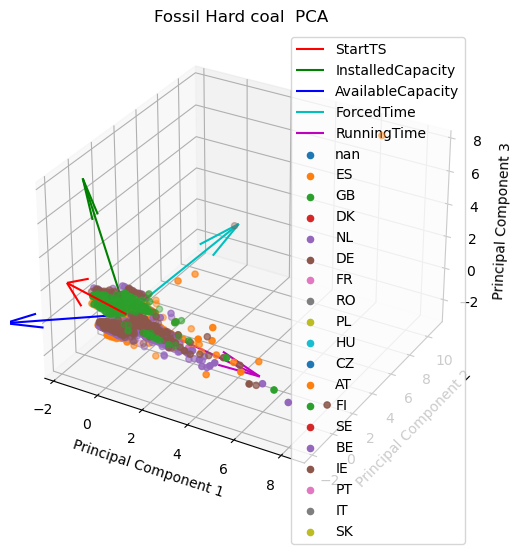

[0.24458171 0.20876457 0.19891758]
[ 0.8134685   7.01940373 -0.50278412]
[-5.0145441   0.85538559  2.29572242]
[-4.57975234  3.04677208  1.54790228]
[ 1.94252122 -0.75293691  7.82859434]
[4.40416563 3.1777557  0.86345499]


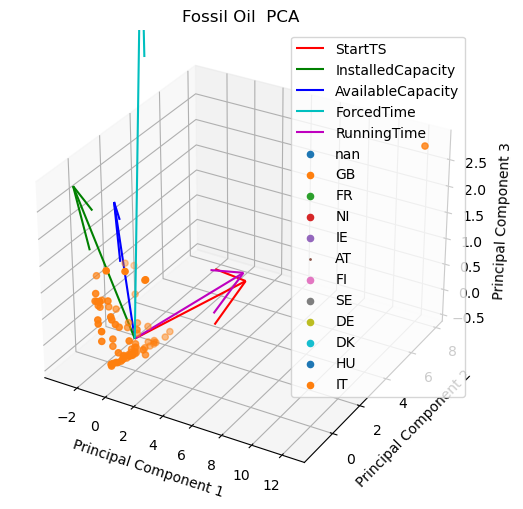

[0.23852853 0.2042014  0.19726167]
[ 0.04853491 -5.0592319   4.63690779]
[-4.24081497  1.32276839 -0.39919887]
[-0.98312841  4.3163985   5.34410345]
[3.33655777 2.01288807 0.25269122]
[4.52776613 0.74708409 0.55056744]


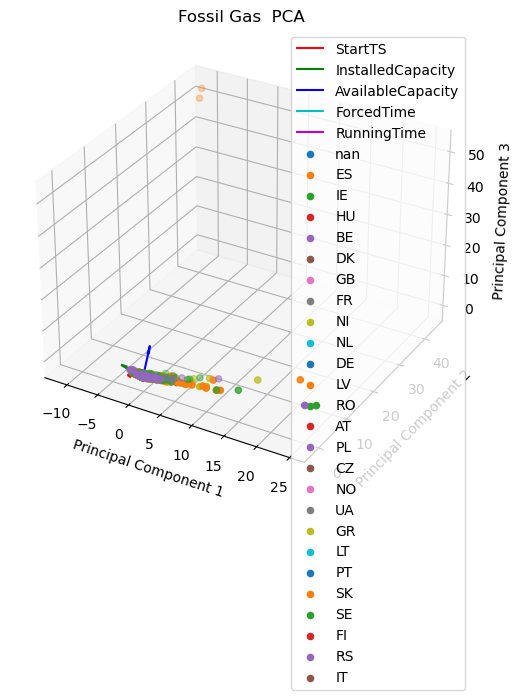

[0.4469113  0.31177094 0.16207154]
[1.6854006  7.18932402 6.19333114]
[ 6.29937394 -1.36809497  2.90279175]
[ 6.23655225 -3.21194094 -4.04106488]
[-0.8078938   6.53998058 -7.34094272]
[ 6.10957395  3.57083787 -1.54714626]


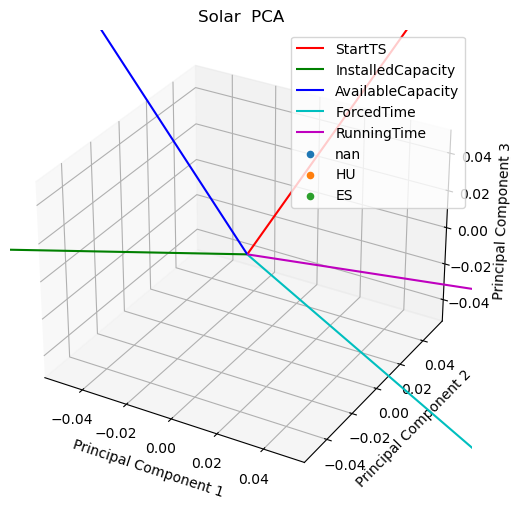

[0.31664783 0.20760625 0.20006348]
[ 0.18266915 -5.83480753 -0.92883808]
[5.238572   0.48445668 0.07440574]
[5.21308149 0.92533827 0.18841859]
[-0.2891047  -0.33080832  7.43446448]
[-1.38166631  4.62595335 -0.68539515]


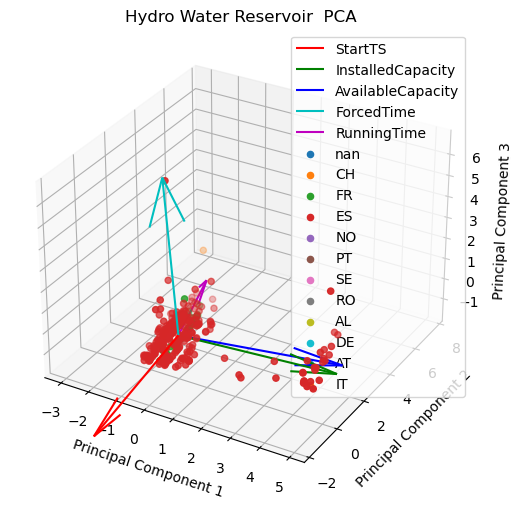

[0.30021821 0.20872189 0.18516082]
[-0.38374493 -7.7102803   4.76179262]
[-5.31601986  3.07518039  3.44350438]
[-5.66159889  1.49756723  2.08463306]
[3.70724362 2.51674486 6.81986988]
[3.77923217 3.31744046 1.76027517]


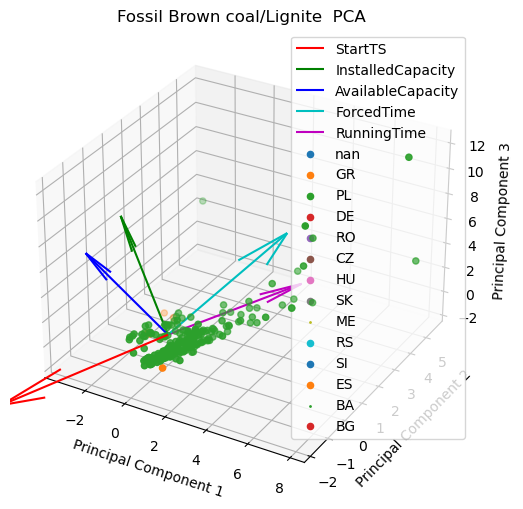

[0.36814723 0.20289412 0.19750521]
[ 0.34527928 -5.98377206  4.61731071]
[ 5.92286443  0.10112633 -0.74626834]
[ 5.92978958  0.16189947 -0.75318587]
[0.21564225 5.9868005  5.13923317]
[-1.28380679  0.61062299 -4.81675468]


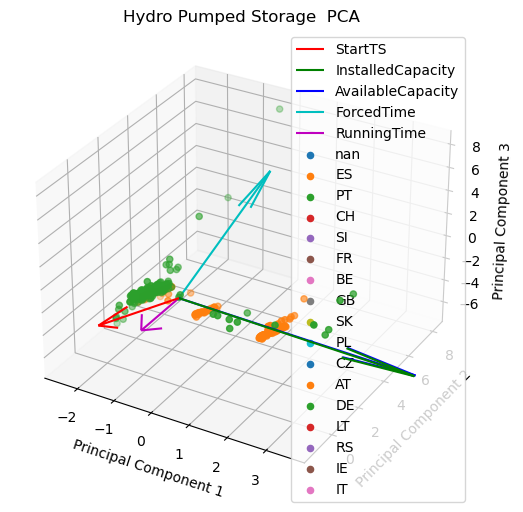

[0.25014116 0.21094545 0.19915846]
[-0.8552186   2.93865084 -8.32977165]
[-3.58478807  5.98924071  2.10541385]
[-5.61402632 -0.18666358 -0.54190122]
[3.55143514 6.11701946 2.00297502]
[ 4.93028487  0.24566843 -1.9739218 ]


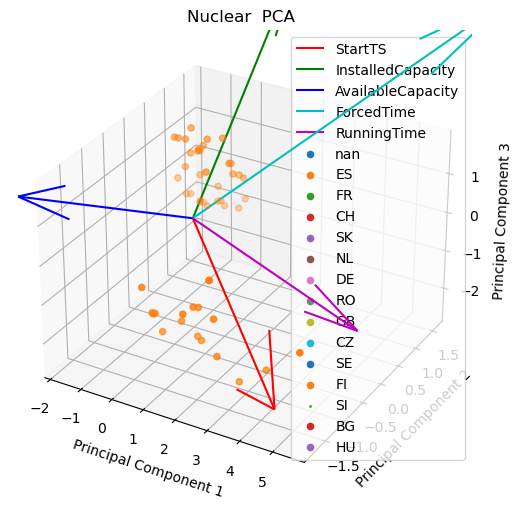

[0.33397802 0.21723796 0.18456743]
[ 1.67593714  8.28539262 -2.23968273]
[-6.43781624 -0.34652609  2.20063167]
[-5.15896458  3.01852882  4.58377223]
[3.15960388 3.44768617 6.04510389]
[ 4.09047333 -2.79613309  5.49281533]


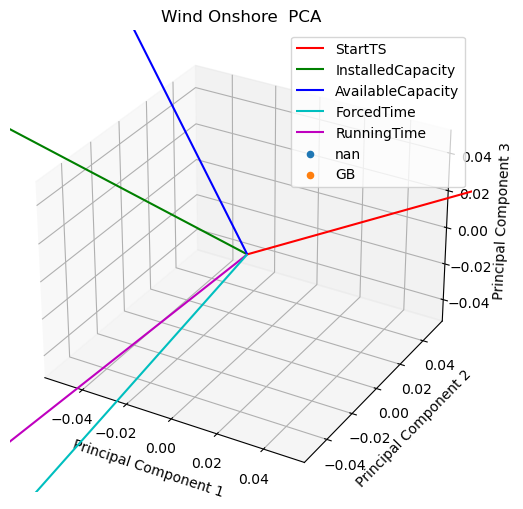

[0.21841575 0.21219782 0.19970459]
[ 2.87166076  4.82254238 -0.14048743]
[ 4.46953225 -3.36379652 -0.096087  ]
[-3.33922463 -4.18763414  0.37399231]
[ 2.25175806 -1.02628126  6.94852346]
[-3.96424205  2.64530332  3.42175199]


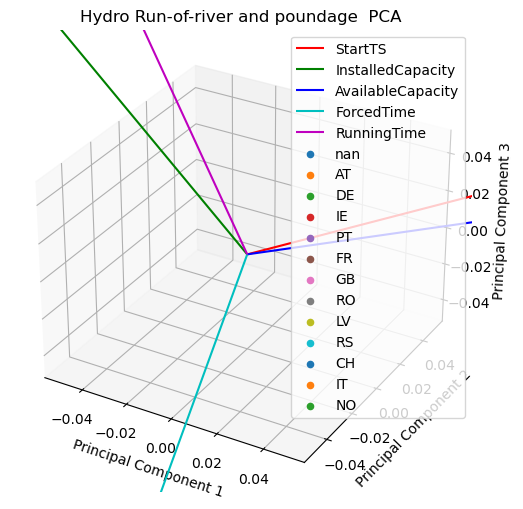

[0.3801244  0.20340716 0.18861618]
[ 0.13881591 -7.38664036  2.62753104]
[-5.05398766  0.39821194  1.09866564]
[-4.58155467  1.08436044  0.50002056]
[1.80446466 2.69962797 7.29554755]
[ 3.75156015  0.83554965 -1.51557925]


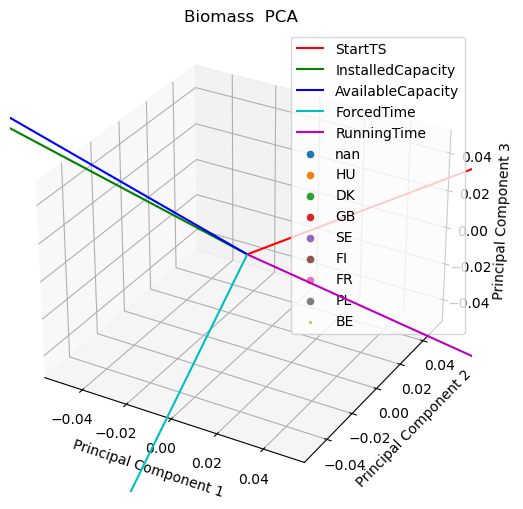

[0.33816494 0.21915551 0.19755437]
[1.23175246 0.07818416 8.95079088]
[ 5.24357778 -3.7783654  -0.42298074]
[-5.52979438  2.92561406  0.99398732]
[ 3.08613615  5.72258986 -0.34747447]
[ 3.561478   5.1195605 -0.6284827]


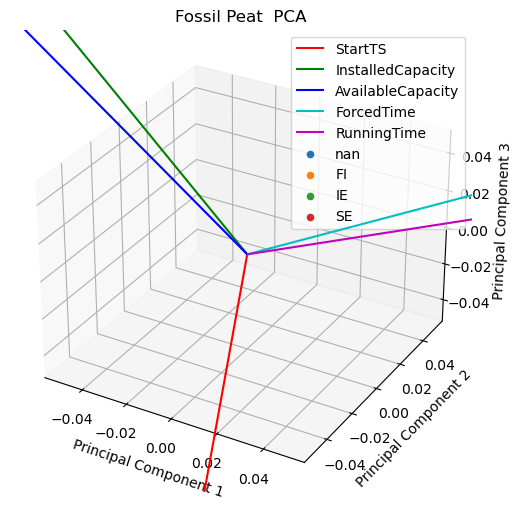

[0.27745091 0.20761032 0.19386678]
[ 1.03024523 -8.94864247  1.64411523]
[-6.59791669  1.59639405 -0.86794405]
[-4.30377894  1.01324852  6.5525359 ]
[ 4.00032472  3.10846496 -2.59470167]
[4.55682699 2.56277002 6.83805878]


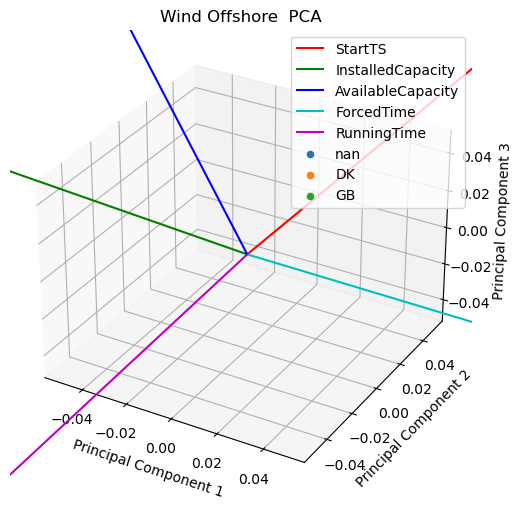

[0.26470885 0.22186222 0.19706592]
[ 0.85732478 -4.27400654 -8.49589093]
[-4.66913513  5.45056635 -3.13145586]
[-4.29023993 -5.42100083  3.91095898]
[4.80172636 4.0336005  0.95288768]
[ 5.90510278 -2.28819007  0.82403201]


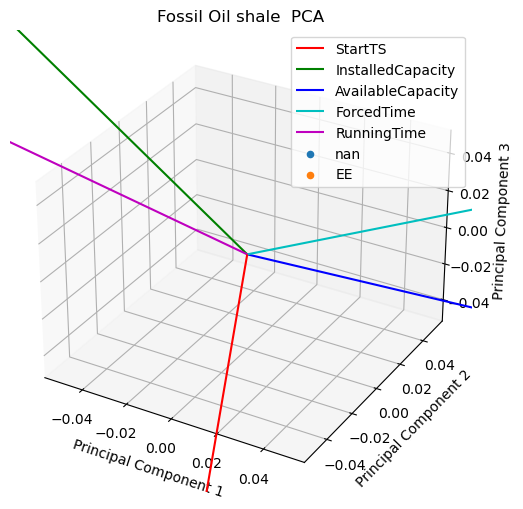

[0.26959526 0.21095733 0.18603944]
[-0.16495177  7.85542616  0.01631743]
[-5.26733938  2.82602964  0.7538644 ]
[-5.15281132  0.69784036  0.29624962]
[3.80583189 2.06287875 7.18210487]
[ 3.88178058  3.07237708 -5.62469044]


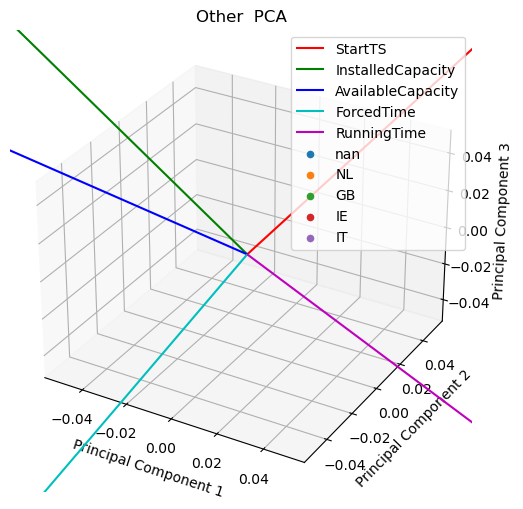

[0.24647864 0.20959875 0.20027385]
[-2.41246337  1.52901188  7.11481491]
[ 1.04915218  7.00735959 -0.4088193 ]
[-4.32446787  2.07705491 -4.19273065]
[ 4.68532475 -1.83596775 -0.21230564]
[4.56593864 3.04891546 0.0999873 ]


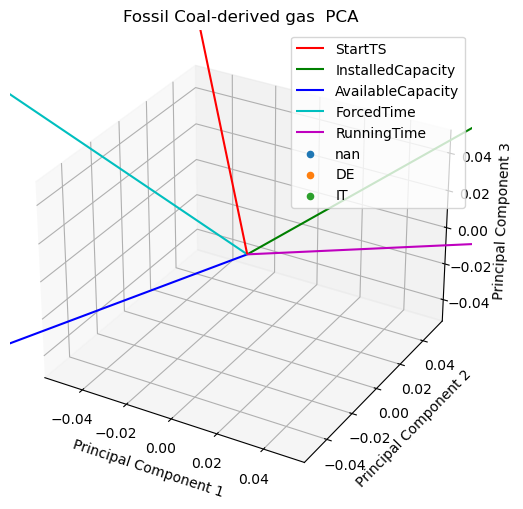

In [131]:
reason = "Forced"
gen_types = delta_df["ProductionType"].unique()
features = ["StartTS", "InstalledCapacity", "AvailableCapacity", reason+"Time", "RunningTime"] #
columns = features + ["MapCode"]
n_features = len(features)  # Replace with the actual number of features
identity_matrix = np.eye(n_features)

for gen_type in gen_types:
    
    failure_df = delta_df.loc[(delta_df["Type"] == reason) & (delta_df["ProductionType"] == gen_type), columns].copy()
    failure_df1 = failure_df.copy() 
    failure_df["StartTS"] = failure_df["StartTS"].dt.hour + (failure_df["StartTS"].dt.dayofyear - 1) * 24

    #conversion to p.u.
    failure_df.loc[:,"AvailableCapacity"] = failure_df1.loc[:,"AvailableCapacity"] / failure_df1.loc[:,"InstalledCapacity"] 
    df = failure_df.dropna().copy()
    df["MapCode"] = df["MapCode"].apply(lambda x: x[0:2]).copy() #transform countries regions to country
    if df.shape[0] != 0:
        # def pca(table, variable_names)

        # Step 1: Preprocessing
        x = df.loc[:, features].values  # Separating out the features
        x = StandardScaler().fit_transform(x)  # Standardizing the features

        # Step 2: PCA
        pca = PCA(n_components=3)  # You can choose the number of components
        principalComponents = pca.fit_transform(x)
        mean_norm = (np.sum(np.abs(principalComponents)**2,axis=-1)**(1./2)).mean()
        principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])  # Creating a new DataFrame with the principal components
        reduced_variables = pca.components_[0:3,:]*mean_norm*6
        # Step 3: Plotting

        explained_var = pca.explained_variance_ratio_
        print(explained_var)
        finalDf = pd.concat([principalDf, df[['MapCode']]], axis=1)  # Adding country column to the principal components DataFrame

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')  # For 3D plot

        countries = finalDf['MapCode'].unique()  # Get unique country names
        colors = ["r","g","b","c","m"]
       
        for i in np.arange(n_features):
            print(reduced_variables[:3, i])
            ax.quiver(0,0,0,reduced_variables[0, i], reduced_variables[1, i], reduced_variables[2, i], color=colors[i], label=f'{features[i]}')
        for country in countries:
            indicesToKeep = finalDf['MapCode'] == country
            ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], finalDf.loc[indicesToKeep, 'PC3'], label=country)

        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.legend()
        ax.set_title(f"{gen_type} PCA")
        plt.show()

[0.30292187 0.26149092 0.2231388 ]
[0.96453754 5.05043202 1.50404499]
[-3.47512472  2.08763841  2.22519686]
[ 3.37639942 -1.41224002  4.6389817 ]
[ 3.43374696  2.08278567 -2.73197952]
moap
moap
moap


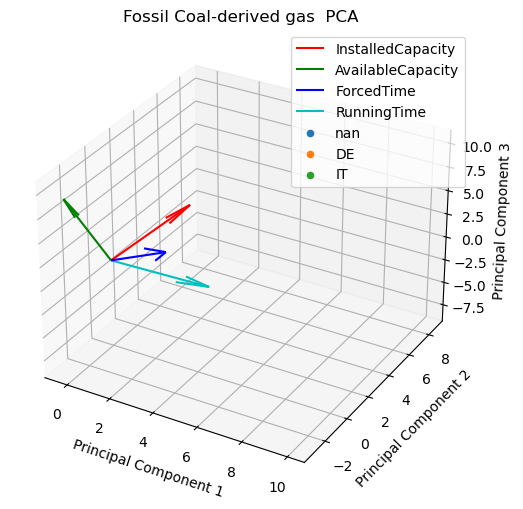

In [111]:
gen_type = "Fossil Coal-derived gas "
df1 = delta_df.loc[ (delta_df["ProductionType"] == gen_type) & (delta_df["Type"] == reason),columns]
df1.loc[:,"AvailableCapacity"] = df1.loc[:,"AvailableCapacity"] / df1.loc[:,"InstalledCapacity"] 
df = df1.dropna().copy()
x = df.loc[:, features].values  # Separating out the features
x = StandardScaler().fit_transform(x)  # Standardizing the features

# Step 2: PCA
pca = PCA(n_components=3)  # You can choose the number of components
principalComponents = pca.fit_transform(x)
mean_norm = (np.sum(np.abs(principalComponents)**2,axis=-1)**(1./2)).mean()
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])  # Creating a new DataFrame with the principal components
reduced_variables = pca.components_[0:3,:]*mean_norm*6
# Step 3: Plotting

explained_var = pca.explained_variance_ratio_
print(explained_var)
finalDf = pd.concat([principalDf, df[['MapCode']]], axis=1)  # Adding country column to the principal components DataFrame

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')  # For 3D plot

countries = finalDf['MapCode'].unique()  # Get unique country names
colors = ["r","g","b","c","m"]

for i in np.arange(n_features):
    print(reduced_variables[:3, i])
    ax.quiver(0,0,0,reduced_variables[0, i], reduced_variables[1, i], reduced_variables[2, i], color=colors[i], label=f'{features[i]}')
for country in countries:
    print("moap")
    indicesToKeep = finalDf['MapCode'] == country
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], finalDf.loc[indicesToKeep, 'PC3'], label=country)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_xlim(np.min(finalDf['PC1']), np.max(finalDf['PC1']))
ax.set_ylim(np.min(finalDf['PC2']), np.max(finalDf['PC2']))
ax.set_zlim(np.min(finalDf['PC3']), np.max(finalDf['PC3']))

ax.legend()
ax.set_title(f"{gen_type} PCA")
plt.show()

In [124]:
print(principalDf.shape)
print(df[['MapCode']].shape)


(586, 3)
(586, 1)


In [129]:
 pd.concat([principalDf, df[['MapCode']]], axis=1)

PC1       PC2       PC3 MapCode
0       2.226620 -2.676848 -3.009589     NaN
1       0.256415 -0.229847 -0.413452     NaN
2       0.729404 -0.519315 -0.698669     NaN
3       0.104327 -0.135485 -0.311152     NaN
4       0.063049 -0.347633 -0.258552     NaN
...          ...       ...       ...     ...
527765       NaN       NaN       NaN      IT
527766       NaN       NaN       NaN      IT
527768       NaN       NaN       NaN      IT
527769       NaN       NaN       NaN      IT
527772       NaN       NaN       NaN      IT

[1172 rows x 4 columns]

# Results analysis

In [17]:
delta_df

StartTS               EndTS TimeZone     Status     Type  \
0      2021-07-14 09:00:00 2021-07-14 10:00:00      CET     Active   Forced   
1      2021-07-14 11:00:00 2021-07-14 23:59:00      CET     Active   Forced   
2      2021-07-15 15:00:00 2021-10-01 00:00:00      CET     Active   Forced   
4      2021-10-01 01:00:00 2021-10-01 01:34:00      CET     Active   Forced   
6      2021-10-05 16:38:00 2021-10-05 22:00:00      CET     Active   Forced   
...                    ...                 ...      ...        ...      ...   
573766 2021-08-23 03:37:00 2021-08-23 04:01:00      CET     Active   Forced   
573767 2021-09-13 00:00:00 2021-09-14 00:00:00      CET  Cancelled  Planned   
573769 2021-09-15 00:00:00 2021-09-16 00:00:00      CET  Cancelled  Planned   
573771 2021-09-17 00:00:00 2021-09-18 00:00:00      CET  Cancelled  Planned   
573772 2022-06-19 00:00:00 2022-07-10 00:00:00      CET     Active  Planned   

                AreaCode AreaTypeCode AreaName MapCode  PowerResourceEIC  \
0       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
1       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
2       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
4       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
6       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
...                  ...          ...      ...     ...               ...   
573766  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573767  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573769  10YHU-MAVIR----U          BZN   HU BZN      HU  15WUJPESTG2--STI   
573771  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573772  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   

       UnitName     ProductionType  InstalledCapacity  AvailableCapacity  \
0       ABO¿O 1  Fossil Hard coal               341.7              230.0   
1       ABO¿O 1  Fossil Hard coal               341.7              220.0   
2       ABO¿O 1  Fossil Hard coal               341.7                0.0   
4       ABO¿O 1  Fossil Hard coal               341.7              210.0   
6       ABO¿O 1  Fossil Hard coal               341.7              240.0   
...         ...                ...                ...                ...   
573766    ÚJ_ST        Fossil Gas                33.0               -1.0   
573767    ÚJ_ST        Fossil Gas                33.0                0.0   
573769    ÚJ_ST        Fossil Gas                33.0                0.0   
573771    ÚJ_ST        Fossil Gas                33.0                0.0   
573772    ÚJ_ST        Fossil Gas                33.0                0.0   

        Version                     Reason             UpTime   ForcedTime  \
0             1                    Failure                NaN     1.000000   
1             7                    Failure    0 days 02:00:00    12.983333   
2             5                    Failure    1 days 04:00:00  1857.000000   
4             1  Complementary Information    0 days 01:00:00     0.566667   
6             1                    Failure    4 days 15:04:00     5.366667   
...         ...                        ...                ...          ...   
573766        2                    Failure   15 days 03:37:00     0.400000   
573767        2       Foreseen Maintenance   20 days 20:23:00          NaN   
573769        2       Foreseen Maintenance    1 days 00:00:00          NaN   
573771        2       Foreseen Maintenance    1 days 00:00:00          NaN   
573772        1       Foreseen Maintenance  275 days 00:00:00          NaN   

        PlannedTime  RunningTime  
0               NaN          NaN  
1               NaN     1.000000  
2               NaN    15.016667  
4               NaN     1.000000  
6               NaN   111.066667  
...             ...          ...  
573766          NaN   339.616667  
573767         24.0   499.9